<div style="border-radius:10px;
    border:#410159 solid;
    background-color:#fef1ff;
    font-size:110%;
    letter-spacing:0.5px;
    text-align: center">
<center><h1 style="padding: 25px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Home credit default risk</h1></center>
<center><h3 style="padding-bottom: 25px; color:#410159; font-weight: bold; font-style:italic; font-family: Cursive">With Boosting models</h3></center>
<center><h4 style="padding-bottom: 25px; color:#410159; font-weight: bold; font-style:italic; font-family: Cursive">(Modelisation)</h4></center>
</div>

<div style="padding: 5px 0px; font-family: Cursive; font-size:16px; background-color:#fef1ff;padding: 25px 10px">
To view EDA for this case, please refer to the notebook exploration 1&2 and preprocess</div>

#### After a careful study and consideration of all given files and the goal of the problem, we can notice that most files contain info about the previous loans, which means if we depend on these info, our model will struggle in generalization with new clients with no previous loans experience or info, so we will try to make the best use of only application info to make a model can generalize well.

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from pandas import MultiIndex, Int64Index

# ----------------------------------------------------
import sklearn
import scipy
import statsmodels.api as sm 
from scipy.stats import shapiro
import pickle
from sklearn import metrics

# ----------------------------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# ----------------------------------------------------
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import pycaret
from pycaret.classification import *

# ----------------------------------------------------
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# ----------------------------------------------------
from sklearn.metrics import auc, roc_curve, roc_auc_score
from collections import Counter

from sklearn.metrics import confusion_matrix, recall_score, fbeta_score, precision_score, average_precision_score
from sklearn.metrics import f1_score, accuracy_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_validate
import outils_model

import mlflow
import mlflow.sklearn

# ----------------------------------------------------
import warnings
warnings.filterwarnings("ignore")
import time

C:\Users\Sofia\AppData\Local\Temp\ipykernel_18072\51650459.py:6: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Changement de l'affichage

pd.set_option('display.max_row',200)
pd.set_option('display.max_column',200)
pd.set_option('display.precision', 5)
pd.set_option('display.max_colwidth', None)

In [4]:
df_train = pd.read_csv(r"C:\Users\Sofia\OneDrive\Documents\OpenClassrooms\Project_7\API\data_model_train.csv")
df_train.shape

(307511, 71)

In [5]:
col = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC',
       'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'AGE',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

y = df_train['TARGET']

### Modélisation simple

In [6]:
# Dataset d'enrengistrement des différents résultats
df_resultats = pd.DataFrame({})
df_taux = pd.DataFrame({})
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
recall_table = pd.DataFrame(columns=['classifiers', 'precision','recall','threshold', 'score'])

In [7]:
from sklearn.model_selection import train_test_split

# Découpage du jeu d'entraînement

X_train, X_test, y_train, y_test = train_test_split(df_train[col], y, test_size=0.2, random_state=100)

print(f'X_train : {X_train.shape} - y_train : {y_train.shape}')
print(f'X_test : {X_test.shape} - y_test : {y_test.shape}')

X_train : (246008, 69) - y_train : (246008,)
X_test : (61503, 69) - y_test : (61503,)


### On va lancer un premier jet, avec plusieurs modèle sans recherche de paramètres afin de voir comment les modèles se débrouille avec nos données

In [8]:
# Modèle avec hyperparamètres par defauts

dummy = DummyClassifier(random_state=100)
lgb = LGBMClassifier(random_state=100)
xgbc = XGBClassifier(random_state=100)
ada = AdaBoostClassifier(random_state=100)
lr = LogisticRegression(random_state=100)
rand = RandomForestClassifier(random_state=100)
cat = CatBoostClassifier(random_state=100)

In [9]:
model_simple = [dummy, lgb, xgbc, ada, lr, rand, cat]
titre = ['Dummy', 'LGBM', 'XGBC', 'AdaBoost', 'LogisticRegressor', 'RandomForest', 'CatBoost']

Registered model 'Dummy' already exists. Creating a new version of this model...
2023/04/17 23:23:39 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Dummy, version 4
Created version '4' of model 'Dummy'.


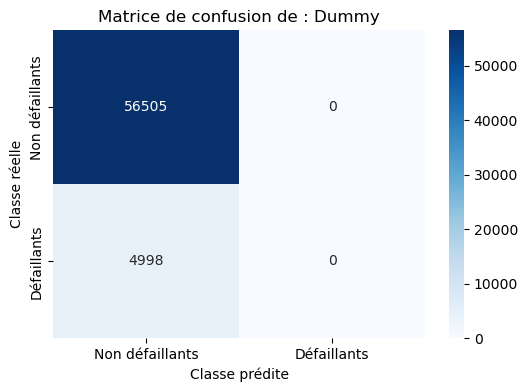

Successfully registered model 'LGBM'.
2023/04/17 23:24:17 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LGBM, version 1
Created version '1' of model 'LGBM'.


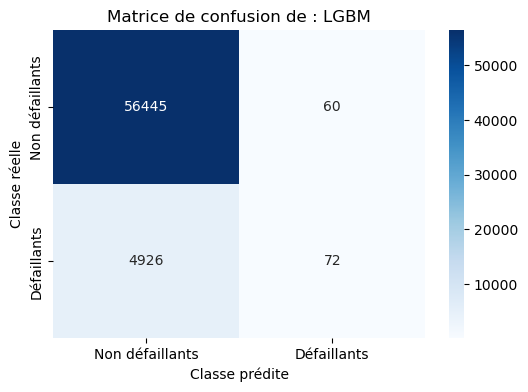

[23:24:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:38] WARNING:

Successfully registered model 'XGBC'.
2023/04/17 23:30:04 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGBC, version 1
Created version '1' of model 'XGBC'.


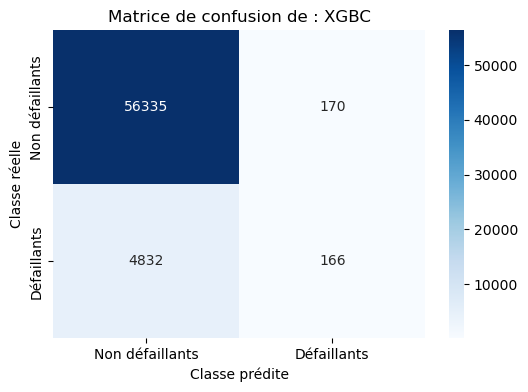

Successfully registered model 'AdaBoost'.
2023/04/17 23:35:34 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: AdaBoost, version 1
Created version '1' of model 'AdaBoost'.


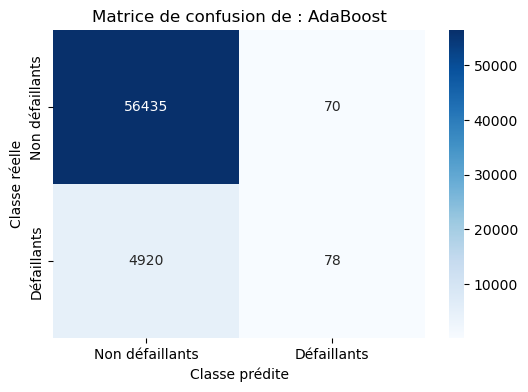

Successfully registered model 'LogisticRegressor'.
2023/04/17 23:35:59 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LogisticRegressor, version 1
Created version '1' of model 'LogisticRegressor'.


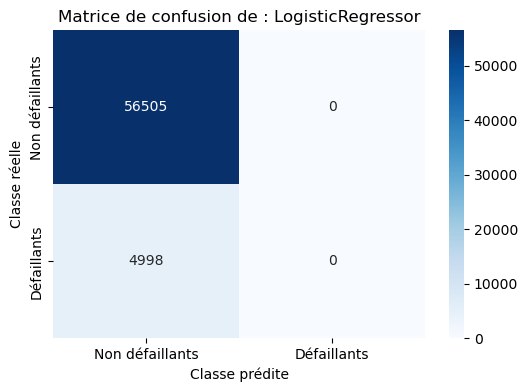

Successfully registered model 'RandomForest'.
2023/04/17 23:49:09 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: RandomForest, version 1
Created version '1' of model 'RandomForest'.


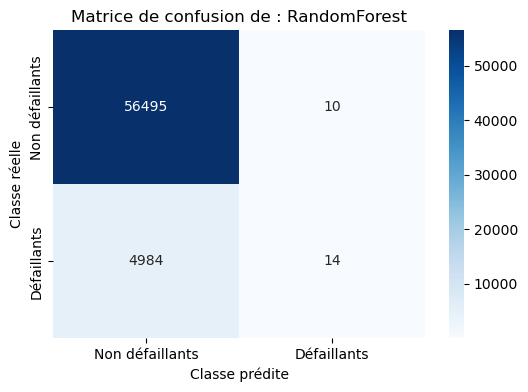

Learning rate set to 0.108111
0:	learn: 0.5815098	total: 197ms	remaining: 3m 16s
1:	learn: 0.5035473	total: 222ms	remaining: 1m 50s
2:	learn: 0.4413445	total: 250ms	remaining: 1m 23s
3:	learn: 0.3971748	total: 277ms	remaining: 1m 8s
4:	learn: 0.3650335	total: 302ms	remaining: 1m
5:	learn: 0.3403400	total: 327ms	remaining: 54.2s
6:	learn: 0.3204327	total: 350ms	remaining: 49.6s
7:	learn: 0.3063457	total: 375ms	remaining: 46.5s
8:	learn: 0.2946145	total: 398ms	remaining: 43.8s
9:	learn: 0.2860705	total: 423ms	remaining: 41.9s
10:	learn: 0.2794439	total: 448ms	remaining: 40.2s
11:	learn: 0.2747581	total: 472ms	remaining: 38.8s
12:	learn: 0.2709002	total: 494ms	remaining: 37.5s
13:	learn: 0.2673286	total: 517ms	remaining: 36.4s
14:	learn: 0.2644696	total: 540ms	remaining: 35.5s
15:	learn: 0.2623112	total: 565ms	remaining: 34.7s
16:	learn: 0.2605143	total: 588ms	remaining: 34s
17:	learn: 0.2587931	total: 614ms	remaining: 33.5s
18:	learn: 0.2575763	total: 638ms	remaining: 33s
19:	learn: 0.25

161:	learn: 0.2419188	total: 4.05s	remaining: 21s
162:	learn: 0.2418839	total: 4.08s	remaining: 20.9s
163:	learn: 0.2418487	total: 4.1s	remaining: 20.9s
164:	learn: 0.2417956	total: 4.12s	remaining: 20.9s
165:	learn: 0.2417478	total: 4.15s	remaining: 20.8s
166:	learn: 0.2417048	total: 4.17s	remaining: 20.8s
167:	learn: 0.2416515	total: 4.19s	remaining: 20.8s
168:	learn: 0.2416119	total: 4.21s	remaining: 20.7s
169:	learn: 0.2415676	total: 4.24s	remaining: 20.7s
170:	learn: 0.2415292	total: 4.26s	remaining: 20.7s
171:	learn: 0.2414874	total: 4.29s	remaining: 20.6s
172:	learn: 0.2414432	total: 4.31s	remaining: 20.6s
173:	learn: 0.2413890	total: 4.34s	remaining: 20.6s
174:	learn: 0.2413440	total: 4.36s	remaining: 20.5s
175:	learn: 0.2413140	total: 4.38s	remaining: 20.5s
176:	learn: 0.2412637	total: 4.4s	remaining: 20.5s
177:	learn: 0.2412242	total: 4.43s	remaining: 20.5s
178:	learn: 0.2411850	total: 4.45s	remaining: 20.4s
179:	learn: 0.2411361	total: 4.47s	remaining: 20.4s
180:	learn: 0.24

323:	learn: 0.2357697	total: 7.86s	remaining: 16.4s
324:	learn: 0.2357313	total: 7.88s	remaining: 16.4s
325:	learn: 0.2357077	total: 7.91s	remaining: 16.3s
326:	learn: 0.2356616	total: 7.93s	remaining: 16.3s
327:	learn: 0.2356285	total: 7.95s	remaining: 16.3s
328:	learn: 0.2356036	total: 7.97s	remaining: 16.3s
329:	learn: 0.2355598	total: 8s	remaining: 16.2s
330:	learn: 0.2355247	total: 8.02s	remaining: 16.2s
331:	learn: 0.2354830	total: 8.04s	remaining: 16.2s
332:	learn: 0.2354408	total: 8.07s	remaining: 16.2s
333:	learn: 0.2354151	total: 8.09s	remaining: 16.1s
334:	learn: 0.2353746	total: 8.12s	remaining: 16.1s
335:	learn: 0.2353415	total: 8.14s	remaining: 16.1s
336:	learn: 0.2353157	total: 8.16s	remaining: 16.1s
337:	learn: 0.2352747	total: 8.18s	remaining: 16s
338:	learn: 0.2352433	total: 8.21s	remaining: 16s
339:	learn: 0.2351964	total: 8.23s	remaining: 16s
340:	learn: 0.2351484	total: 8.25s	remaining: 15.9s
341:	learn: 0.2351082	total: 8.28s	remaining: 15.9s
342:	learn: 0.2350845

484:	learn: 0.2305400	total: 11.8s	remaining: 12.5s
485:	learn: 0.2305040	total: 11.8s	remaining: 12.5s
486:	learn: 0.2304769	total: 11.8s	remaining: 12.5s
487:	learn: 0.2304620	total: 11.8s	remaining: 12.4s
488:	learn: 0.2304381	total: 11.9s	remaining: 12.4s
489:	learn: 0.2304184	total: 11.9s	remaining: 12.4s
490:	learn: 0.2303871	total: 11.9s	remaining: 12.4s
491:	learn: 0.2303550	total: 12s	remaining: 12.4s
492:	learn: 0.2303237	total: 12s	remaining: 12.3s
493:	learn: 0.2302833	total: 12s	remaining: 12.3s
494:	learn: 0.2302510	total: 12.1s	remaining: 12.3s
495:	learn: 0.2302156	total: 12.1s	remaining: 12.3s
496:	learn: 0.2301758	total: 12.1s	remaining: 12.3s
497:	learn: 0.2301507	total: 12.2s	remaining: 12.3s
498:	learn: 0.2301298	total: 12.2s	remaining: 12.2s
499:	learn: 0.2301145	total: 12.2s	remaining: 12.2s
500:	learn: 0.2300943	total: 12.3s	remaining: 12.2s
501:	learn: 0.2300698	total: 12.3s	remaining: 12.2s
502:	learn: 0.2300379	total: 12.3s	remaining: 12.2s
503:	learn: 0.2300

647:	learn: 0.2257212	total: 18.2s	remaining: 9.87s
648:	learn: 0.2256903	total: 18.2s	remaining: 9.85s
649:	learn: 0.2256689	total: 18.2s	remaining: 9.82s
650:	learn: 0.2256362	total: 18.3s	remaining: 9.8s
651:	learn: 0.2256081	total: 18.3s	remaining: 9.77s
652:	learn: 0.2255888	total: 18.3s	remaining: 9.75s
653:	learn: 0.2255563	total: 18.4s	remaining: 9.73s
654:	learn: 0.2255246	total: 18.4s	remaining: 9.7s
655:	learn: 0.2255070	total: 18.5s	remaining: 9.68s
656:	learn: 0.2254834	total: 18.5s	remaining: 9.65s
657:	learn: 0.2254532	total: 18.5s	remaining: 9.63s
658:	learn: 0.2254276	total: 18.6s	remaining: 9.6s
659:	learn: 0.2254023	total: 18.6s	remaining: 9.57s
660:	learn: 0.2253693	total: 18.6s	remaining: 9.55s
661:	learn: 0.2253289	total: 18.7s	remaining: 9.53s
662:	learn: 0.2252958	total: 18.7s	remaining: 9.5s
663:	learn: 0.2252725	total: 18.7s	remaining: 9.47s
664:	learn: 0.2252438	total: 18.8s	remaining: 9.45s
665:	learn: 0.2252145	total: 18.8s	remaining: 9.42s
666:	learn: 0.22

808:	learn: 0.2212081	total: 23.9s	remaining: 5.65s
809:	learn: 0.2211704	total: 24s	remaining: 5.62s
810:	learn: 0.2211459	total: 24s	remaining: 5.59s
811:	learn: 0.2211209	total: 24s	remaining: 5.56s
812:	learn: 0.2210925	total: 24.1s	remaining: 5.54s
813:	learn: 0.2210708	total: 24.1s	remaining: 5.51s
814:	learn: 0.2210414	total: 24.2s	remaining: 5.48s
815:	learn: 0.2210147	total: 24.2s	remaining: 5.46s
816:	learn: 0.2209985	total: 24.2s	remaining: 5.43s
817:	learn: 0.2209726	total: 24.3s	remaining: 5.4s
818:	learn: 0.2209575	total: 24.3s	remaining: 5.37s
819:	learn: 0.2209302	total: 24.3s	remaining: 5.34s
820:	learn: 0.2209014	total: 24.4s	remaining: 5.31s
821:	learn: 0.2208747	total: 24.4s	remaining: 5.28s
822:	learn: 0.2208475	total: 24.4s	remaining: 5.25s
823:	learn: 0.2208157	total: 24.5s	remaining: 5.22s
824:	learn: 0.2207974	total: 24.5s	remaining: 5.2s
825:	learn: 0.2207683	total: 24.5s	remaining: 5.17s
826:	learn: 0.2207460	total: 24.6s	remaining: 5.14s
827:	learn: 0.220716

970:	learn: 0.2169428	total: 29.6s	remaining: 885ms
971:	learn: 0.2169075	total: 29.7s	remaining: 854ms
972:	learn: 0.2168782	total: 29.7s	remaining: 824ms
973:	learn: 0.2168452	total: 29.7s	remaining: 793ms
974:	learn: 0.2168140	total: 29.8s	remaining: 763ms
975:	learn: 0.2167862	total: 29.8s	remaining: 733ms
976:	learn: 0.2167577	total: 29.8s	remaining: 702ms
977:	learn: 0.2167245	total: 29.9s	remaining: 672ms
978:	learn: 0.2166974	total: 29.9s	remaining: 642ms
979:	learn: 0.2166738	total: 30s	remaining: 612ms
980:	learn: 0.2166435	total: 30s	remaining: 581ms
981:	learn: 0.2166225	total: 30.1s	remaining: 551ms
982:	learn: 0.2166011	total: 30.1s	remaining: 521ms
983:	learn: 0.2165711	total: 30.2s	remaining: 490ms
984:	learn: 0.2165412	total: 30.2s	remaining: 460ms
985:	learn: 0.2165213	total: 30.3s	remaining: 430ms
986:	learn: 0.2164905	total: 30.3s	remaining: 399ms
987:	learn: 0.2164665	total: 30.4s	remaining: 369ms
988:	learn: 0.2164461	total: 30.4s	remaining: 338ms
989:	learn: 0.21

133:	learn: 0.2433838	total: 5.89s	remaining: 38.1s
134:	learn: 0.2432970	total: 5.94s	remaining: 38.1s
135:	learn: 0.2432567	total: 5.97s	remaining: 38s
136:	learn: 0.2432066	total: 6.01s	remaining: 37.9s
137:	learn: 0.2431534	total: 6.04s	remaining: 37.8s
138:	learn: 0.2431163	total: 6.08s	remaining: 37.6s
139:	learn: 0.2430579	total: 6.12s	remaining: 37.6s
140:	learn: 0.2430079	total: 6.15s	remaining: 37.5s
141:	learn: 0.2429642	total: 6.18s	remaining: 37.4s
142:	learn: 0.2429318	total: 6.21s	remaining: 37.2s
143:	learn: 0.2428733	total: 6.25s	remaining: 37.1s
144:	learn: 0.2428176	total: 6.28s	remaining: 37s
145:	learn: 0.2427669	total: 6.31s	remaining: 36.9s
146:	learn: 0.2427102	total: 6.34s	remaining: 36.8s
147:	learn: 0.2426629	total: 6.38s	remaining: 36.7s
148:	learn: 0.2426200	total: 6.4s	remaining: 36.6s
149:	learn: 0.2425680	total: 6.44s	remaining: 36.5s
150:	learn: 0.2425147	total: 6.47s	remaining: 36.4s
151:	learn: 0.2424540	total: 6.5s	remaining: 36.3s
152:	learn: 0.2424

295:	learn: 0.2365417	total: 11.4s	remaining: 27s
296:	learn: 0.2364989	total: 11.4s	remaining: 27s
297:	learn: 0.2364505	total: 11.5s	remaining: 27s
298:	learn: 0.2364156	total: 11.5s	remaining: 26.9s
299:	learn: 0.2363810	total: 11.5s	remaining: 26.9s
300:	learn: 0.2363431	total: 11.5s	remaining: 26.8s
301:	learn: 0.2363055	total: 11.6s	remaining: 26.7s
302:	learn: 0.2362639	total: 11.6s	remaining: 26.7s
303:	learn: 0.2362212	total: 11.6s	remaining: 26.7s
304:	learn: 0.2361788	total: 11.7s	remaining: 26.6s
305:	learn: 0.2361317	total: 11.7s	remaining: 26.5s
306:	learn: 0.2360762	total: 11.7s	remaining: 26.5s
307:	learn: 0.2360355	total: 11.8s	remaining: 26.4s
308:	learn: 0.2359986	total: 11.8s	remaining: 26.4s
309:	learn: 0.2359563	total: 11.8s	remaining: 26.4s
310:	learn: 0.2359293	total: 11.9s	remaining: 26.3s
311:	learn: 0.2358883	total: 11.9s	remaining: 26.3s
312:	learn: 0.2358667	total: 11.9s	remaining: 26.2s
313:	learn: 0.2358364	total: 12s	remaining: 26.1s
314:	learn: 0.235791

456:	learn: 0.2308539	total: 17.8s	remaining: 21.2s
457:	learn: 0.2308227	total: 17.9s	remaining: 21.1s
458:	learn: 0.2307930	total: 17.9s	remaining: 21.1s
459:	learn: 0.2307592	total: 18s	remaining: 21.1s
460:	learn: 0.2307320	total: 18s	remaining: 21.1s
461:	learn: 0.2307158	total: 18.1s	remaining: 21.1s
462:	learn: 0.2306823	total: 18.1s	remaining: 21s
463:	learn: 0.2306435	total: 18.2s	remaining: 21s
464:	learn: 0.2306218	total: 18.2s	remaining: 20.9s
465:	learn: 0.2305869	total: 18.2s	remaining: 20.9s
466:	learn: 0.2305642	total: 18.3s	remaining: 20.9s
467:	learn: 0.2305234	total: 18.3s	remaining: 20.8s
468:	learn: 0.2304851	total: 18.3s	remaining: 20.8s
469:	learn: 0.2304514	total: 18.4s	remaining: 20.7s
470:	learn: 0.2304302	total: 18.4s	remaining: 20.7s
471:	learn: 0.2303855	total: 18.4s	remaining: 20.6s
472:	learn: 0.2303484	total: 18.5s	remaining: 20.6s
473:	learn: 0.2303316	total: 18.5s	remaining: 20.6s
474:	learn: 0.2302894	total: 18.6s	remaining: 20.5s
475:	learn: 0.230251

618:	learn: 0.2256917	total: 23.7s	remaining: 14.6s
619:	learn: 0.2256559	total: 23.8s	remaining: 14.6s
620:	learn: 0.2256205	total: 23.8s	remaining: 14.5s
621:	learn: 0.2255815	total: 23.8s	remaining: 14.5s
622:	learn: 0.2255491	total: 23.9s	remaining: 14.4s
623:	learn: 0.2255108	total: 23.9s	remaining: 14.4s
624:	learn: 0.2254780	total: 23.9s	remaining: 14.4s
625:	learn: 0.2254436	total: 24s	remaining: 14.3s
626:	learn: 0.2254142	total: 24s	remaining: 14.3s
627:	learn: 0.2253750	total: 24s	remaining: 14.2s
628:	learn: 0.2253371	total: 24.1s	remaining: 14.2s
629:	learn: 0.2253038	total: 24.1s	remaining: 14.1s
630:	learn: 0.2252792	total: 24.1s	remaining: 14.1s
631:	learn: 0.2252452	total: 24.2s	remaining: 14.1s
632:	learn: 0.2252192	total: 24.2s	remaining: 14s
633:	learn: 0.2251779	total: 24.2s	remaining: 14s
634:	learn: 0.2251522	total: 24.3s	remaining: 14s
635:	learn: 0.2251257	total: 24.3s	remaining: 13.9s
636:	learn: 0.2250954	total: 24.3s	remaining: 13.9s
637:	learn: 0.2250619	to

778:	learn: 0.2209112	total: 29.2s	remaining: 8.28s
779:	learn: 0.2208803	total: 29.2s	remaining: 8.25s
780:	learn: 0.2208585	total: 29.3s	remaining: 8.21s
781:	learn: 0.2208498	total: 29.3s	remaining: 8.17s
782:	learn: 0.2208256	total: 29.3s	remaining: 8.13s
783:	learn: 0.2208001	total: 29.4s	remaining: 8.09s
784:	learn: 0.2207771	total: 29.4s	remaining: 8.06s
785:	learn: 0.2207520	total: 29.5s	remaining: 8.02s
786:	learn: 0.2207063	total: 29.5s	remaining: 7.99s
787:	learn: 0.2206820	total: 29.6s	remaining: 7.95s
788:	learn: 0.2206525	total: 29.6s	remaining: 7.92s
789:	learn: 0.2206401	total: 29.6s	remaining: 7.88s
790:	learn: 0.2206181	total: 29.7s	remaining: 7.84s
791:	learn: 0.2205782	total: 29.7s	remaining: 7.8s
792:	learn: 0.2205597	total: 29.7s	remaining: 7.76s
793:	learn: 0.2205247	total: 29.8s	remaining: 7.73s
794:	learn: 0.2205017	total: 29.8s	remaining: 7.7s
795:	learn: 0.2204773	total: 29.9s	remaining: 7.66s
796:	learn: 0.2204528	total: 29.9s	remaining: 7.62s
797:	learn: 0.

942:	learn: 0.2163218	total: 36.1s	remaining: 2.18s
943:	learn: 0.2162963	total: 36.1s	remaining: 2.14s
944:	learn: 0.2162596	total: 36.1s	remaining: 2.1s
945:	learn: 0.2162293	total: 36.2s	remaining: 2.06s
946:	learn: 0.2162020	total: 36.2s	remaining: 2.03s
947:	learn: 0.2161715	total: 36.2s	remaining: 1.99s
948:	learn: 0.2161398	total: 36.3s	remaining: 1.95s
949:	learn: 0.2161136	total: 36.3s	remaining: 1.91s
950:	learn: 0.2160746	total: 36.4s	remaining: 1.87s
951:	learn: 0.2160494	total: 36.4s	remaining: 1.83s
952:	learn: 0.2160317	total: 36.4s	remaining: 1.8s
953:	learn: 0.2159997	total: 36.5s	remaining: 1.76s
954:	learn: 0.2159616	total: 36.5s	remaining: 1.72s
955:	learn: 0.2159296	total: 36.5s	remaining: 1.68s
956:	learn: 0.2158990	total: 36.6s	remaining: 1.64s
957:	learn: 0.2158946	total: 36.6s	remaining: 1.6s
958:	learn: 0.2158614	total: 36.6s	remaining: 1.56s
959:	learn: 0.2158341	total: 36.7s	remaining: 1.53s
960:	learn: 0.2158105	total: 36.7s	remaining: 1.49s
961:	learn: 0.2

105:	learn: 0.2445480	total: 3.68s	remaining: 31s
106:	learn: 0.2444981	total: 3.72s	remaining: 31s
107:	learn: 0.2444538	total: 3.76s	remaining: 31s
108:	learn: 0.2444093	total: 3.79s	remaining: 31s
109:	learn: 0.2443463	total: 3.83s	remaining: 31s
110:	learn: 0.2443006	total: 3.86s	remaining: 30.9s
111:	learn: 0.2442378	total: 3.9s	remaining: 30.9s
112:	learn: 0.2441902	total: 3.94s	remaining: 30.9s
113:	learn: 0.2441411	total: 3.98s	remaining: 30.9s
114:	learn: 0.2441066	total: 4.02s	remaining: 30.9s
115:	learn: 0.2440325	total: 4.05s	remaining: 30.9s
116:	learn: 0.2439866	total: 4.09s	remaining: 30.8s
117:	learn: 0.2439374	total: 4.13s	remaining: 30.9s
118:	learn: 0.2438481	total: 4.17s	remaining: 30.8s
119:	learn: 0.2437969	total: 4.2s	remaining: 30.8s
120:	learn: 0.2437491	total: 4.23s	remaining: 30.7s
121:	learn: 0.2437071	total: 4.26s	remaining: 30.7s
122:	learn: 0.2436656	total: 4.29s	remaining: 30.6s
123:	learn: 0.2436134	total: 4.32s	remaining: 30.5s
124:	learn: 0.2435739	to

267:	learn: 0.2371914	total: 10.6s	remaining: 28.9s
268:	learn: 0.2371488	total: 10.6s	remaining: 28.9s
269:	learn: 0.2370988	total: 10.7s	remaining: 28.9s
270:	learn: 0.2370532	total: 10.7s	remaining: 28.9s
271:	learn: 0.2370130	total: 10.8s	remaining: 28.9s
272:	learn: 0.2369779	total: 10.8s	remaining: 28.8s
273:	learn: 0.2369512	total: 10.9s	remaining: 28.8s
274:	learn: 0.2369077	total: 10.9s	remaining: 28.7s
275:	learn: 0.2368670	total: 10.9s	remaining: 28.6s
276:	learn: 0.2368214	total: 10.9s	remaining: 28.6s
277:	learn: 0.2367792	total: 11s	remaining: 28.5s
278:	learn: 0.2367481	total: 11s	remaining: 28.5s
279:	learn: 0.2367163	total: 11s	remaining: 28.4s
280:	learn: 0.2366755	total: 11.1s	remaining: 28.4s
281:	learn: 0.2366346	total: 11.1s	remaining: 28.3s
282:	learn: 0.2365893	total: 11.1s	remaining: 28.2s
283:	learn: 0.2365517	total: 11.2s	remaining: 28.2s
284:	learn: 0.2365202	total: 11.2s	remaining: 28.1s
285:	learn: 0.2364936	total: 11.3s	remaining: 28.1s
286:	learn: 0.2364

426:	learn: 0.2313543	total: 16.2s	remaining: 21.8s
427:	learn: 0.2313102	total: 16.3s	remaining: 21.7s
428:	learn: 0.2312760	total: 16.3s	remaining: 21.7s
429:	learn: 0.2312600	total: 16.3s	remaining: 21.6s
430:	learn: 0.2312367	total: 16.3s	remaining: 21.6s
431:	learn: 0.2311966	total: 16.4s	remaining: 21.5s
432:	learn: 0.2311663	total: 16.4s	remaining: 21.5s
433:	learn: 0.2311313	total: 16.4s	remaining: 21.4s
434:	learn: 0.2310978	total: 16.5s	remaining: 21.4s
435:	learn: 0.2310604	total: 16.5s	remaining: 21.3s
436:	learn: 0.2310299	total: 16.5s	remaining: 21.3s
437:	learn: 0.2310037	total: 16.6s	remaining: 21.3s
438:	learn: 0.2309823	total: 16.6s	remaining: 21.2s
439:	learn: 0.2309524	total: 16.6s	remaining: 21.2s
440:	learn: 0.2309230	total: 16.7s	remaining: 21.1s
441:	learn: 0.2308957	total: 16.7s	remaining: 21.1s
442:	learn: 0.2308746	total: 16.7s	remaining: 21.1s
443:	learn: 0.2308421	total: 16.8s	remaining: 21s
444:	learn: 0.2308090	total: 16.8s	remaining: 21s
445:	learn: 0.23

586:	learn: 0.2263262	total: 21.6s	remaining: 15.2s
587:	learn: 0.2262986	total: 21.7s	remaining: 15.2s
588:	learn: 0.2262635	total: 21.7s	remaining: 15.1s
589:	learn: 0.2262334	total: 21.7s	remaining: 15.1s
590:	learn: 0.2261947	total: 21.8s	remaining: 15.1s
591:	learn: 0.2261491	total: 21.8s	remaining: 15s
592:	learn: 0.2261203	total: 21.8s	remaining: 15s
593:	learn: 0.2260866	total: 21.9s	remaining: 14.9s
594:	learn: 0.2260471	total: 21.9s	remaining: 14.9s
595:	learn: 0.2260264	total: 21.9s	remaining: 14.9s
596:	learn: 0.2260013	total: 22s	remaining: 14.8s
597:	learn: 0.2259726	total: 22s	remaining: 14.8s
598:	learn: 0.2259390	total: 22s	remaining: 14.7s
599:	learn: 0.2259074	total: 22s	remaining: 14.7s
600:	learn: 0.2258788	total: 22.1s	remaining: 14.7s
601:	learn: 0.2258638	total: 22.1s	remaining: 14.6s
602:	learn: 0.2258304	total: 22.1s	remaining: 14.6s
603:	learn: 0.2258029	total: 22.2s	remaining: 14.5s
604:	learn: 0.2257815	total: 22.2s	remaining: 14.5s
605:	learn: 0.2257588	to

749:	learn: 0.2213516	total: 28.2s	remaining: 9.4s
750:	learn: 0.2213407	total: 28.2s	remaining: 9.36s
751:	learn: 0.2213175	total: 28.3s	remaining: 9.32s
752:	learn: 0.2212904	total: 28.3s	remaining: 9.29s
753:	learn: 0.2212619	total: 28.3s	remaining: 9.24s
754:	learn: 0.2212419	total: 28.4s	remaining: 9.2s
755:	learn: 0.2212075	total: 28.4s	remaining: 9.16s
756:	learn: 0.2211815	total: 28.4s	remaining: 9.13s
757:	learn: 0.2211534	total: 28.5s	remaining: 9.09s
758:	learn: 0.2211158	total: 28.5s	remaining: 9.05s
759:	learn: 0.2210908	total: 28.5s	remaining: 9.01s
760:	learn: 0.2210648	total: 28.6s	remaining: 8.97s
761:	learn: 0.2210317	total: 28.6s	remaining: 8.93s
762:	learn: 0.2210075	total: 28.6s	remaining: 8.89s
763:	learn: 0.2209708	total: 28.7s	remaining: 8.86s
764:	learn: 0.2209430	total: 28.7s	remaining: 8.82s
765:	learn: 0.2209139	total: 28.7s	remaining: 8.78s
766:	learn: 0.2208785	total: 28.8s	remaining: 8.74s
767:	learn: 0.2208394	total: 28.8s	remaining: 8.7s
768:	learn: 0.2

908:	learn: 0.2168971	total: 34.7s	remaining: 3.47s
909:	learn: 0.2168620	total: 34.7s	remaining: 3.43s
910:	learn: 0.2168425	total: 34.7s	remaining: 3.39s
911:	learn: 0.2168271	total: 34.8s	remaining: 3.35s
912:	learn: 0.2167913	total: 34.8s	remaining: 3.31s
913:	learn: 0.2167658	total: 34.8s	remaining: 3.28s
914:	learn: 0.2167316	total: 34.8s	remaining: 3.24s
915:	learn: 0.2167128	total: 34.9s	remaining: 3.2s
916:	learn: 0.2166933	total: 34.9s	remaining: 3.16s
917:	learn: 0.2166669	total: 35s	remaining: 3.12s
918:	learn: 0.2166373	total: 35s	remaining: 3.08s
919:	learn: 0.2166106	total: 35s	remaining: 3.04s
920:	learn: 0.2165739	total: 35.1s	remaining: 3.01s
921:	learn: 0.2165468	total: 35.1s	remaining: 2.97s
922:	learn: 0.2165089	total: 35.1s	remaining: 2.93s
923:	learn: 0.2164792	total: 35.2s	remaining: 2.89s
924:	learn: 0.2164735	total: 35.2s	remaining: 2.85s
925:	learn: 0.2164417	total: 35.2s	remaining: 2.81s
926:	learn: 0.2164164	total: 35.3s	remaining: 2.78s
927:	learn: 0.21638

72:	learn: 0.2469759	total: 3.25s	remaining: 41.3s
73:	learn: 0.2469331	total: 3.31s	remaining: 41.4s
74:	learn: 0.2468111	total: 3.34s	remaining: 41.2s
75:	learn: 0.2467464	total: 3.38s	remaining: 41.1s
76:	learn: 0.2466664	total: 3.42s	remaining: 40.9s
77:	learn: 0.2466041	total: 3.45s	remaining: 40.8s
78:	learn: 0.2465496	total: 3.5s	remaining: 40.8s
79:	learn: 0.2464981	total: 3.53s	remaining: 40.6s
80:	learn: 0.2464326	total: 3.56s	remaining: 40.4s
81:	learn: 0.2463660	total: 3.6s	remaining: 40.3s
82:	learn: 0.2463274	total: 3.64s	remaining: 40.2s
83:	learn: 0.2462542	total: 3.68s	remaining: 40.1s
84:	learn: 0.2462209	total: 3.71s	remaining: 40s
85:	learn: 0.2461629	total: 3.76s	remaining: 39.9s
86:	learn: 0.2460991	total: 3.79s	remaining: 39.8s
87:	learn: 0.2460497	total: 3.82s	remaining: 39.6s
88:	learn: 0.2460089	total: 3.85s	remaining: 39.4s
89:	learn: 0.2459543	total: 3.88s	remaining: 39.2s
90:	learn: 0.2459080	total: 3.91s	remaining: 39.1s
91:	learn: 0.2458483	total: 3.95s	r

234:	learn: 0.2389894	total: 8.9s	remaining: 29s
235:	learn: 0.2389615	total: 8.94s	remaining: 29s
236:	learn: 0.2389216	total: 8.98s	remaining: 28.9s
237:	learn: 0.2388871	total: 9.02s	remaining: 28.9s
238:	learn: 0.2388532	total: 9.05s	remaining: 28.8s
239:	learn: 0.2388179	total: 9.09s	remaining: 28.8s
240:	learn: 0.2387706	total: 9.13s	remaining: 28.8s
241:	learn: 0.2387325	total: 9.18s	remaining: 28.7s
242:	learn: 0.2387062	total: 9.22s	remaining: 28.7s
243:	learn: 0.2386696	total: 9.26s	remaining: 28.7s
244:	learn: 0.2386213	total: 9.31s	remaining: 28.7s
245:	learn: 0.2385821	total: 9.35s	remaining: 28.7s
246:	learn: 0.2385481	total: 9.39s	remaining: 28.6s
247:	learn: 0.2385117	total: 9.44s	remaining: 28.6s
248:	learn: 0.2384581	total: 9.47s	remaining: 28.6s
249:	learn: 0.2384054	total: 9.51s	remaining: 28.5s
250:	learn: 0.2383705	total: 9.54s	remaining: 28.5s
251:	learn: 0.2383280	total: 9.57s	remaining: 28.4s
252:	learn: 0.2382992	total: 9.61s	remaining: 28.4s
253:	learn: 0.238

396:	learn: 0.2329141	total: 14.9s	remaining: 22.6s
397:	learn: 0.2328786	total: 14.9s	remaining: 22.6s
398:	learn: 0.2328413	total: 15s	remaining: 22.6s
399:	learn: 0.2328005	total: 15s	remaining: 22.6s
400:	learn: 0.2327737	total: 15.1s	remaining: 22.6s
401:	learn: 0.2327441	total: 15.1s	remaining: 22.5s
402:	learn: 0.2327023	total: 15.2s	remaining: 22.5s
403:	learn: 0.2326777	total: 15.2s	remaining: 22.5s
404:	learn: 0.2326483	total: 15.3s	remaining: 22.4s
405:	learn: 0.2326290	total: 15.3s	remaining: 22.4s
406:	learn: 0.2325852	total: 15.4s	remaining: 22.4s
407:	learn: 0.2325479	total: 15.4s	remaining: 22.4s
408:	learn: 0.2325112	total: 15.5s	remaining: 22.4s
409:	learn: 0.2324615	total: 15.5s	remaining: 22.3s
410:	learn: 0.2324281	total: 15.6s	remaining: 22.3s
411:	learn: 0.2323997	total: 15.6s	remaining: 22.3s
412:	learn: 0.2323708	total: 15.6s	remaining: 22.2s
413:	learn: 0.2323333	total: 15.7s	remaining: 22.2s
414:	learn: 0.2323117	total: 15.7s	remaining: 22.2s
415:	learn: 0.23

555:	learn: 0.2277115	total: 21.7s	remaining: 17.3s
556:	learn: 0.2276751	total: 21.7s	remaining: 17.3s
557:	learn: 0.2276403	total: 21.7s	remaining: 17.2s
558:	learn: 0.2276079	total: 21.8s	remaining: 17.2s
559:	learn: 0.2275915	total: 21.8s	remaining: 17.1s
560:	learn: 0.2275724	total: 21.8s	remaining: 17.1s
561:	learn: 0.2275394	total: 21.9s	remaining: 17s
562:	learn: 0.2275139	total: 21.9s	remaining: 17s
563:	learn: 0.2274843	total: 21.9s	remaining: 17s
564:	learn: 0.2274472	total: 22s	remaining: 16.9s
565:	learn: 0.2274181	total: 22s	remaining: 16.9s
566:	learn: 0.2273753	total: 22s	remaining: 16.8s
567:	learn: 0.2273387	total: 22.1s	remaining: 16.8s
568:	learn: 0.2273029	total: 22.1s	remaining: 16.8s
569:	learn: 0.2272777	total: 22.2s	remaining: 16.7s
570:	learn: 0.2272490	total: 22.2s	remaining: 16.7s
571:	learn: 0.2272077	total: 22.3s	remaining: 16.7s
572:	learn: 0.2271709	total: 22.3s	remaining: 16.6s
573:	learn: 0.2271358	total: 22.3s	remaining: 16.6s
574:	learn: 0.2271143	to

717:	learn: 0.2227516	total: 27.4s	remaining: 10.7s
718:	learn: 0.2227160	total: 27.4s	remaining: 10.7s
719:	learn: 0.2226901	total: 27.4s	remaining: 10.7s
720:	learn: 0.2226662	total: 27.5s	remaining: 10.6s
721:	learn: 0.2226362	total: 27.5s	remaining: 10.6s
722:	learn: 0.2226088	total: 27.5s	remaining: 10.5s
723:	learn: 0.2225694	total: 27.6s	remaining: 10.5s
724:	learn: 0.2225362	total: 27.6s	remaining: 10.5s
725:	learn: 0.2225084	total: 27.6s	remaining: 10.4s
726:	learn: 0.2224755	total: 27.7s	remaining: 10.4s
727:	learn: 0.2224393	total: 27.7s	remaining: 10.4s
728:	learn: 0.2224040	total: 27.7s	remaining: 10.3s
729:	learn: 0.2223735	total: 27.8s	remaining: 10.3s
730:	learn: 0.2223437	total: 27.8s	remaining: 10.2s
731:	learn: 0.2223134	total: 27.9s	remaining: 10.2s
732:	learn: 0.2222760	total: 27.9s	remaining: 10.2s
733:	learn: 0.2222459	total: 27.9s	remaining: 10.1s
734:	learn: 0.2222187	total: 28s	remaining: 10.1s
735:	learn: 0.2221875	total: 28s	remaining: 10s
736:	learn: 0.2221

880:	learn: 0.2179897	total: 34s	remaining: 4.6s
881:	learn: 0.2179725	total: 34.1s	remaining: 4.56s
882:	learn: 0.2179405	total: 34.1s	remaining: 4.52s
883:	learn: 0.2179089	total: 34.2s	remaining: 4.49s
884:	learn: 0.2178823	total: 34.2s	remaining: 4.45s
885:	learn: 0.2178546	total: 34.3s	remaining: 4.41s
886:	learn: 0.2178388	total: 34.3s	remaining: 4.37s
887:	learn: 0.2178031	total: 34.4s	remaining: 4.34s
888:	learn: 0.2177730	total: 34.4s	remaining: 4.3s
889:	learn: 0.2177478	total: 34.5s	remaining: 4.26s
890:	learn: 0.2177153	total: 34.5s	remaining: 4.22s
891:	learn: 0.2176853	total: 34.6s	remaining: 4.19s
892:	learn: 0.2176639	total: 34.6s	remaining: 4.15s
893:	learn: 0.2176415	total: 34.7s	remaining: 4.11s
894:	learn: 0.2176090	total: 34.7s	remaining: 4.08s
895:	learn: 0.2175826	total: 34.8s	remaining: 4.04s
896:	learn: 0.2175557	total: 34.9s	remaining: 4s
897:	learn: 0.2175273	total: 34.9s	remaining: 3.97s
898:	learn: 0.2175079	total: 35s	remaining: 3.93s
899:	learn: 0.2174755

42:	learn: 0.2490203	total: 1.36s	remaining: 30.4s
43:	learn: 0.2489065	total: 1.41s	remaining: 30.6s
44:	learn: 0.2487884	total: 1.44s	remaining: 30.6s
45:	learn: 0.2486626	total: 1.47s	remaining: 30.6s
46:	learn: 0.2485184	total: 1.5s	remaining: 30.5s
47:	learn: 0.2484073	total: 1.53s	remaining: 30.4s
48:	learn: 0.2482977	total: 1.57s	remaining: 30.5s
49:	learn: 0.2481684	total: 1.61s	remaining: 30.7s
50:	learn: 0.2480660	total: 1.65s	remaining: 30.6s
51:	learn: 0.2479897	total: 1.68s	remaining: 30.6s
52:	learn: 0.2479183	total: 1.71s	remaining: 30.5s
53:	learn: 0.2477657	total: 1.74s	remaining: 30.4s
54:	learn: 0.2476927	total: 1.77s	remaining: 30.4s
55:	learn: 0.2475846	total: 1.81s	remaining: 30.5s
56:	learn: 0.2475096	total: 1.84s	remaining: 30.4s
57:	learn: 0.2474361	total: 1.88s	remaining: 30.5s
58:	learn: 0.2473188	total: 1.91s	remaining: 30.5s
59:	learn: 0.2472485	total: 1.94s	remaining: 30.5s
60:	learn: 0.2471796	total: 1.98s	remaining: 30.4s
61:	learn: 0.2470989	total: 2.01

206:	learn: 0.2397316	total: 8.3s	remaining: 31.8s
207:	learn: 0.2396834	total: 8.35s	remaining: 31.8s
208:	learn: 0.2396468	total: 8.39s	remaining: 31.8s
209:	learn: 0.2396089	total: 8.44s	remaining: 31.7s
210:	learn: 0.2395669	total: 8.47s	remaining: 31.7s
211:	learn: 0.2395368	total: 8.52s	remaining: 31.7s
212:	learn: 0.2395066	total: 8.56s	remaining: 31.6s
213:	learn: 0.2394679	total: 8.6s	remaining: 31.6s
214:	learn: 0.2394246	total: 8.64s	remaining: 31.6s
215:	learn: 0.2393883	total: 8.68s	remaining: 31.5s
216:	learn: 0.2393440	total: 8.72s	remaining: 31.5s
217:	learn: 0.2393033	total: 8.78s	remaining: 31.5s
218:	learn: 0.2392568	total: 8.82s	remaining: 31.5s
219:	learn: 0.2392229	total: 8.86s	remaining: 31.4s
220:	learn: 0.2391807	total: 8.9s	remaining: 31.4s
221:	learn: 0.2391495	total: 8.94s	remaining: 31.3s
222:	learn: 0.2391136	total: 8.97s	remaining: 31.3s
223:	learn: 0.2390769	total: 9.02s	remaining: 31.2s
224:	learn: 0.2390366	total: 9.06s	remaining: 31.2s
225:	learn: 0.2

371:	learn: 0.2336996	total: 14.5s	remaining: 24.6s
372:	learn: 0.2336595	total: 14.6s	remaining: 24.5s
373:	learn: 0.2336222	total: 14.6s	remaining: 24.4s
374:	learn: 0.2335859	total: 14.6s	remaining: 24.4s
375:	learn: 0.2335591	total: 14.7s	remaining: 24.3s
376:	learn: 0.2335113	total: 14.7s	remaining: 24.3s
377:	learn: 0.2334766	total: 14.7s	remaining: 24.2s
378:	learn: 0.2334499	total: 14.7s	remaining: 24.2s
379:	learn: 0.2334043	total: 14.8s	remaining: 24.1s
380:	learn: 0.2333767	total: 14.8s	remaining: 24.1s
381:	learn: 0.2333406	total: 14.9s	remaining: 24s
382:	learn: 0.2333076	total: 14.9s	remaining: 24s
383:	learn: 0.2332731	total: 14.9s	remaining: 23.9s
384:	learn: 0.2332403	total: 14.9s	remaining: 23.9s
385:	learn: 0.2332080	total: 15s	remaining: 23.8s
386:	learn: 0.2331953	total: 15s	remaining: 23.8s
387:	learn: 0.2331581	total: 15.1s	remaining: 23.7s
388:	learn: 0.2331303	total: 15.1s	remaining: 23.7s
389:	learn: 0.2330961	total: 15.1s	remaining: 23.6s
390:	learn: 0.233052

536:	learn: 0.2281650	total: 20.1s	remaining: 17.3s
537:	learn: 0.2281244	total: 20.2s	remaining: 17.3s
538:	learn: 0.2280853	total: 20.2s	remaining: 17.3s
539:	learn: 0.2280699	total: 20.3s	remaining: 17.3s
540:	learn: 0.2280361	total: 20.3s	remaining: 17.2s
541:	learn: 0.2279992	total: 20.3s	remaining: 17.2s
542:	learn: 0.2279720	total: 20.4s	remaining: 17.2s
543:	learn: 0.2279353	total: 20.4s	remaining: 17.1s
544:	learn: 0.2279052	total: 20.5s	remaining: 17.1s
545:	learn: 0.2278615	total: 20.5s	remaining: 17.1s
546:	learn: 0.2278225	total: 20.6s	remaining: 17s
547:	learn: 0.2277955	total: 20.6s	remaining: 17s
548:	learn: 0.2277681	total: 20.6s	remaining: 17s
549:	learn: 0.2277326	total: 20.7s	remaining: 16.9s
550:	learn: 0.2276857	total: 20.7s	remaining: 16.9s
551:	learn: 0.2276614	total: 20.8s	remaining: 16.9s
552:	learn: 0.2276285	total: 20.8s	remaining: 16.8s
553:	learn: 0.2275966	total: 20.9s	remaining: 16.8s
554:	learn: 0.2275553	total: 20.9s	remaining: 16.8s
555:	learn: 0.2275

696:	learn: 0.2231154	total: 27.4s	remaining: 11.9s
697:	learn: 0.2230865	total: 27.4s	remaining: 11.9s
698:	learn: 0.2230619	total: 27.5s	remaining: 11.8s
699:	learn: 0.2230241	total: 27.5s	remaining: 11.8s
700:	learn: 0.2229986	total: 27.5s	remaining: 11.7s
701:	learn: 0.2229645	total: 27.6s	remaining: 11.7s
702:	learn: 0.2229341	total: 27.6s	remaining: 11.7s
703:	learn: 0.2229219	total: 27.6s	remaining: 11.6s
704:	learn: 0.2228861	total: 27.7s	remaining: 11.6s
705:	learn: 0.2228628	total: 27.7s	remaining: 11.5s
706:	learn: 0.2228419	total: 27.7s	remaining: 11.5s
707:	learn: 0.2228094	total: 27.8s	remaining: 11.4s
708:	learn: 0.2227856	total: 27.8s	remaining: 11.4s
709:	learn: 0.2227619	total: 27.8s	remaining: 11.4s
710:	learn: 0.2227195	total: 27.8s	remaining: 11.3s
711:	learn: 0.2226862	total: 27.9s	remaining: 11.3s
712:	learn: 0.2226522	total: 27.9s	remaining: 11.2s
713:	learn: 0.2226124	total: 28s	remaining: 11.2s
714:	learn: 0.2225847	total: 28s	remaining: 11.2s
715:	learn: 0.22

858:	learn: 0.2184434	total: 33.1s	remaining: 5.43s
859:	learn: 0.2184158	total: 33.1s	remaining: 5.39s
860:	learn: 0.2183936	total: 33.2s	remaining: 5.36s
861:	learn: 0.2183748	total: 33.2s	remaining: 5.32s
862:	learn: 0.2183420	total: 33.2s	remaining: 5.28s
863:	learn: 0.2183133	total: 33.3s	remaining: 5.24s
864:	learn: 0.2182827	total: 33.3s	remaining: 5.2s
865:	learn: 0.2182533	total: 33.4s	remaining: 5.16s
866:	learn: 0.2182236	total: 33.4s	remaining: 5.12s
867:	learn: 0.2181844	total: 33.4s	remaining: 5.08s
868:	learn: 0.2181545	total: 33.5s	remaining: 5.04s
869:	learn: 0.2181330	total: 33.5s	remaining: 5s
870:	learn: 0.2180927	total: 33.5s	remaining: 4.96s
871:	learn: 0.2180630	total: 33.6s	remaining: 4.93s
872:	learn: 0.2180511	total: 33.6s	remaining: 4.89s
873:	learn: 0.2180193	total: 33.6s	remaining: 4.85s
874:	learn: 0.2179884	total: 33.7s	remaining: 4.81s
875:	learn: 0.2179606	total: 33.7s	remaining: 4.77s
876:	learn: 0.2179289	total: 33.7s	remaining: 4.73s
877:	learn: 0.21

19:	learn: 0.2575153	total: 923ms	remaining: 45.2s
20:	learn: 0.2564778	total: 968ms	remaining: 45.1s
21:	learn: 0.2555982	total: 1.01s	remaining: 45.2s
22:	learn: 0.2549310	total: 1.06s	remaining: 44.9s
23:	learn: 0.2541901	total: 1.1s	remaining: 44.9s
24:	learn: 0.2535740	total: 1.15s	remaining: 44.9s
25:	learn: 0.2530833	total: 1.2s	remaining: 44.8s
26:	learn: 0.2526591	total: 1.25s	remaining: 44.9s
27:	learn: 0.2523826	total: 1.29s	remaining: 44.9s
28:	learn: 0.2520047	total: 1.35s	remaining: 45.3s
29:	learn: 0.2516224	total: 1.41s	remaining: 45.5s
30:	learn: 0.2513684	total: 1.46s	remaining: 45.5s
31:	learn: 0.2510514	total: 1.5s	remaining: 45.6s
32:	learn: 0.2508143	total: 1.57s	remaining: 45.9s
33:	learn: 0.2505455	total: 1.62s	remaining: 46s
34:	learn: 0.2503254	total: 1.66s	remaining: 45.8s
35:	learn: 0.2501041	total: 1.71s	remaining: 45.7s
36:	learn: 0.2499741	total: 1.75s	remaining: 45.5s
37:	learn: 0.2497532	total: 1.79s	remaining: 45.4s
38:	learn: 0.2496210	total: 1.83s	re

181:	learn: 0.2407529	total: 7.3s	remaining: 32.8s
182:	learn: 0.2406968	total: 7.34s	remaining: 32.8s
183:	learn: 0.2406387	total: 7.37s	remaining: 32.7s
184:	learn: 0.2405996	total: 7.4s	remaining: 32.6s
185:	learn: 0.2405476	total: 7.43s	remaining: 32.5s
186:	learn: 0.2405090	total: 7.46s	remaining: 32.4s
187:	learn: 0.2404782	total: 7.49s	remaining: 32.4s
188:	learn: 0.2404461	total: 7.54s	remaining: 32.3s
189:	learn: 0.2404050	total: 7.58s	remaining: 32.3s
190:	learn: 0.2403498	total: 7.62s	remaining: 32.3s
191:	learn: 0.2402938	total: 7.65s	remaining: 32.2s
192:	learn: 0.2402477	total: 7.68s	remaining: 32.1s
193:	learn: 0.2402219	total: 7.71s	remaining: 32s
194:	learn: 0.2401634	total: 7.76s	remaining: 32s
195:	learn: 0.2401216	total: 7.79s	remaining: 32s
196:	learn: 0.2400653	total: 7.83s	remaining: 31.9s
197:	learn: 0.2400137	total: 7.87s	remaining: 31.9s
198:	learn: 0.2399616	total: 7.9s	remaining: 31.8s
199:	learn: 0.2399082	total: 7.94s	remaining: 31.7s
200:	learn: 0.2398645

343:	learn: 0.2343206	total: 13.1s	remaining: 25s
344:	learn: 0.2342914	total: 13.1s	remaining: 24.9s
345:	learn: 0.2342488	total: 13.2s	remaining: 24.9s
346:	learn: 0.2342107	total: 13.2s	remaining: 24.8s
347:	learn: 0.2341725	total: 13.2s	remaining: 24.8s
348:	learn: 0.2341347	total: 13.3s	remaining: 24.7s
349:	learn: 0.2341124	total: 13.3s	remaining: 24.7s
350:	learn: 0.2340687	total: 13.3s	remaining: 24.7s
351:	learn: 0.2340328	total: 13.4s	remaining: 24.6s
352:	learn: 0.2339961	total: 13.4s	remaining: 24.5s
353:	learn: 0.2339656	total: 13.4s	remaining: 24.5s
354:	learn: 0.2339176	total: 13.5s	remaining: 24.5s
355:	learn: 0.2338764	total: 13.5s	remaining: 24.4s
356:	learn: 0.2338386	total: 13.5s	remaining: 24.4s
357:	learn: 0.2338146	total: 13.6s	remaining: 24.3s
358:	learn: 0.2337748	total: 13.6s	remaining: 24.3s
359:	learn: 0.2337387	total: 13.6s	remaining: 24.3s
360:	learn: 0.2337104	total: 13.7s	remaining: 24.2s
361:	learn: 0.2336728	total: 13.7s	remaining: 24.2s
362:	learn: 0.

506:	learn: 0.2287771	total: 19.8s	remaining: 19.3s
507:	learn: 0.2287433	total: 19.9s	remaining: 19.2s
508:	learn: 0.2287157	total: 19.9s	remaining: 19.2s
509:	learn: 0.2286807	total: 19.9s	remaining: 19.1s
510:	learn: 0.2286449	total: 20s	remaining: 19.1s
511:	learn: 0.2286173	total: 20s	remaining: 19.1s
512:	learn: 0.2285946	total: 20s	remaining: 19s
513:	learn: 0.2285706	total: 20.1s	remaining: 19s
514:	learn: 0.2285417	total: 20.1s	remaining: 18.9s
515:	learn: 0.2285106	total: 20.1s	remaining: 18.9s
516:	learn: 0.2284725	total: 20.1s	remaining: 18.8s
517:	learn: 0.2284441	total: 20.2s	remaining: 18.8s
518:	learn: 0.2284287	total: 20.2s	remaining: 18.7s
519:	learn: 0.2283880	total: 20.2s	remaining: 18.7s
520:	learn: 0.2283578	total: 20.3s	remaining: 18.6s
521:	learn: 0.2283200	total: 20.3s	remaining: 18.6s
522:	learn: 0.2282764	total: 20.3s	remaining: 18.5s
523:	learn: 0.2282397	total: 20.4s	remaining: 18.5s
524:	learn: 0.2282046	total: 20.4s	remaining: 18.5s
525:	learn: 0.2281562	

669:	learn: 0.2235983	total: 25.3s	remaining: 12.4s
670:	learn: 0.2235707	total: 25.3s	remaining: 12.4s
671:	learn: 0.2235393	total: 25.3s	remaining: 12.4s
672:	learn: 0.2235047	total: 25.4s	remaining: 12.3s
673:	learn: 0.2234783	total: 25.4s	remaining: 12.3s
674:	learn: 0.2234535	total: 25.4s	remaining: 12.2s
675:	learn: 0.2234258	total: 25.5s	remaining: 12.2s
676:	learn: 0.2234102	total: 25.5s	remaining: 12.2s
677:	learn: 0.2233791	total: 25.5s	remaining: 12.1s
678:	learn: 0.2233514	total: 25.6s	remaining: 12.1s
679:	learn: 0.2233348	total: 25.6s	remaining: 12s
680:	learn: 0.2233006	total: 25.6s	remaining: 12s
681:	learn: 0.2232689	total: 25.7s	remaining: 12s
682:	learn: 0.2232480	total: 25.7s	remaining: 11.9s
683:	learn: 0.2232161	total: 25.7s	remaining: 11.9s
684:	learn: 0.2231882	total: 25.8s	remaining: 11.8s
685:	learn: 0.2231571	total: 25.8s	remaining: 11.8s
686:	learn: 0.2231238	total: 25.8s	remaining: 11.8s
687:	learn: 0.2231014	total: 25.8s	remaining: 11.7s
688:	learn: 0.2230

829:	learn: 0.2190004	total: 30.6s	remaining: 6.26s
830:	learn: 0.2189694	total: 30.6s	remaining: 6.22s
831:	learn: 0.2189377	total: 30.6s	remaining: 6.19s
832:	learn: 0.2189071	total: 30.7s	remaining: 6.15s
833:	learn: 0.2188898	total: 30.7s	remaining: 6.11s
834:	learn: 0.2188548	total: 30.7s	remaining: 6.07s
835:	learn: 0.2188267	total: 30.8s	remaining: 6.03s
836:	learn: 0.2187947	total: 30.8s	remaining: 6s
837:	learn: 0.2187551	total: 30.8s	remaining: 5.96s
838:	learn: 0.2187228	total: 30.9s	remaining: 5.92s
839:	learn: 0.2187034	total: 30.9s	remaining: 5.88s
840:	learn: 0.2186849	total: 30.9s	remaining: 5.84s
841:	learn: 0.2186548	total: 30.9s	remaining: 5.81s
842:	learn: 0.2186439	total: 31s	remaining: 5.77s
843:	learn: 0.2186008	total: 31s	remaining: 5.73s
844:	learn: 0.2185780	total: 31.1s	remaining: 5.7s
845:	learn: 0.2185429	total: 31.1s	remaining: 5.66s
846:	learn: 0.2185094	total: 31.1s	remaining: 5.62s
847:	learn: 0.2184869	total: 31.2s	remaining: 5.59s
848:	learn: 0.218461

988:	learn: 0.2145968	total: 36.9s	remaining: 411ms
989:	learn: 0.2145684	total: 37s	remaining: 373ms
990:	learn: 0.2145391	total: 37s	remaining: 336ms
991:	learn: 0.2145186	total: 37s	remaining: 299ms
992:	learn: 0.2144894	total: 37.1s	remaining: 261ms
993:	learn: 0.2144637	total: 37.1s	remaining: 224ms
994:	learn: 0.2144354	total: 37.1s	remaining: 187ms
995:	learn: 0.2144266	total: 37.2s	remaining: 149ms
996:	learn: 0.2144011	total: 37.2s	remaining: 112ms
997:	learn: 0.2143709	total: 37.2s	remaining: 74.6ms
998:	learn: 0.2143503	total: 37.2s	remaining: 37.3ms
999:	learn: 0.2143152	total: 37.3s	remaining: 0us
Learning rate set to 0.103355
0:	learn: 0.5859786	total: 51.8ms	remaining: 51.8s
1:	learn: 0.5102411	total: 92.6ms	remaining: 46.2s
2:	learn: 0.4486875	total: 130ms	remaining: 43.3s
3:	learn: 0.4068318	total: 161ms	remaining: 40s
4:	learn: 0.3725842	total: 183ms	remaining: 36.4s
5:	learn: 0.3460482	total: 212ms	remaining: 35.1s
6:	learn: 0.3255951	total: 234ms	remaining: 33.2s
7:

153:	learn: 0.2420758	total: 5.16s	remaining: 28.4s
154:	learn: 0.2420319	total: 5.19s	remaining: 28.3s
155:	learn: 0.2419862	total: 5.23s	remaining: 28.3s
156:	learn: 0.2419551	total: 5.25s	remaining: 28.2s
157:	learn: 0.2419072	total: 5.29s	remaining: 28.2s
158:	learn: 0.2418592	total: 5.32s	remaining: 28.1s
159:	learn: 0.2418279	total: 5.35s	remaining: 28.1s
160:	learn: 0.2417768	total: 5.39s	remaining: 28.1s
161:	learn: 0.2417165	total: 5.43s	remaining: 28.1s
162:	learn: 0.2416639	total: 5.46s	remaining: 28s
163:	learn: 0.2416079	total: 5.49s	remaining: 28s
164:	learn: 0.2415503	total: 5.52s	remaining: 27.9s
165:	learn: 0.2415025	total: 5.55s	remaining: 27.9s
166:	learn: 0.2414648	total: 5.58s	remaining: 27.8s
167:	learn: 0.2414165	total: 5.63s	remaining: 27.9s
168:	learn: 0.2413733	total: 5.66s	remaining: 27.8s
169:	learn: 0.2413026	total: 5.69s	remaining: 27.8s
170:	learn: 0.2412523	total: 5.73s	remaining: 27.8s
171:	learn: 0.2411981	total: 5.77s	remaining: 27.8s
172:	learn: 0.24

316:	learn: 0.2354827	total: 11.5s	remaining: 24.8s
317:	learn: 0.2354467	total: 11.5s	remaining: 24.7s
318:	learn: 0.2353990	total: 11.6s	remaining: 24.7s
319:	learn: 0.2353694	total: 11.6s	remaining: 24.7s
320:	learn: 0.2353462	total: 11.6s	remaining: 24.6s
321:	learn: 0.2353032	total: 11.7s	remaining: 24.6s
322:	learn: 0.2352668	total: 11.7s	remaining: 24.6s
323:	learn: 0.2352248	total: 11.8s	remaining: 24.6s
324:	learn: 0.2351944	total: 11.8s	remaining: 24.6s
325:	learn: 0.2351634	total: 11.9s	remaining: 24.6s
326:	learn: 0.2351241	total: 11.9s	remaining: 24.6s
327:	learn: 0.2350880	total: 12s	remaining: 24.6s
328:	learn: 0.2350419	total: 12s	remaining: 24.5s
329:	learn: 0.2350079	total: 12.1s	remaining: 24.5s
330:	learn: 0.2349760	total: 12.1s	remaining: 24.5s
331:	learn: 0.2349400	total: 12.2s	remaining: 24.5s
332:	learn: 0.2349009	total: 12.2s	remaining: 24.5s
333:	learn: 0.2348724	total: 12.3s	remaining: 24.5s
334:	learn: 0.2348355	total: 12.3s	remaining: 24.4s
335:	learn: 0.23

479:	learn: 0.2297387	total: 17.8s	remaining: 19.3s
480:	learn: 0.2297066	total: 17.9s	remaining: 19.3s
481:	learn: 0.2296720	total: 17.9s	remaining: 19.2s
482:	learn: 0.2296341	total: 17.9s	remaining: 19.2s
483:	learn: 0.2296008	total: 18s	remaining: 19.1s
484:	learn: 0.2295743	total: 18s	remaining: 19.1s
485:	learn: 0.2295365	total: 18s	remaining: 19.1s
486:	learn: 0.2295049	total: 18.1s	remaining: 19s
487:	learn: 0.2294750	total: 18.1s	remaining: 19s
488:	learn: 0.2294431	total: 18.1s	remaining: 19s
489:	learn: 0.2294052	total: 18.2s	remaining: 18.9s
490:	learn: 0.2293746	total: 18.2s	remaining: 18.9s
491:	learn: 0.2293357	total: 18.3s	remaining: 18.9s
492:	learn: 0.2293040	total: 18.3s	remaining: 18.8s
493:	learn: 0.2292734	total: 18.3s	remaining: 18.8s
494:	learn: 0.2292464	total: 18.4s	remaining: 18.7s
495:	learn: 0.2292196	total: 18.4s	remaining: 18.7s
496:	learn: 0.2291854	total: 18.4s	remaining: 18.6s
497:	learn: 0.2291435	total: 18.5s	remaining: 18.6s
498:	learn: 0.2291107	to

642:	learn: 0.2245369	total: 23.7s	remaining: 13.1s
643:	learn: 0.2245067	total: 23.7s	remaining: 13.1s
644:	learn: 0.2244730	total: 23.8s	remaining: 13.1s
645:	learn: 0.2244441	total: 23.8s	remaining: 13s
646:	learn: 0.2244307	total: 23.8s	remaining: 13s
647:	learn: 0.2244011	total: 23.9s	remaining: 13s
648:	learn: 0.2243900	total: 23.9s	remaining: 12.9s
649:	learn: 0.2243540	total: 23.9s	remaining: 12.9s
650:	learn: 0.2243155	total: 24s	remaining: 12.8s
651:	learn: 0.2242753	total: 24s	remaining: 12.8s
652:	learn: 0.2242390	total: 24s	remaining: 12.8s
653:	learn: 0.2242237	total: 24.1s	remaining: 12.7s
654:	learn: 0.2241876	total: 24.1s	remaining: 12.7s
655:	learn: 0.2241656	total: 24.1s	remaining: 12.7s
656:	learn: 0.2241302	total: 24.2s	remaining: 12.6s
657:	learn: 0.2240992	total: 24.2s	remaining: 12.6s
658:	learn: 0.2240709	total: 24.2s	remaining: 12.5s
659:	learn: 0.2240386	total: 24.3s	remaining: 12.5s
660:	learn: 0.2240097	total: 24.3s	remaining: 12.5s
661:	learn: 0.2239714	to

805:	learn: 0.2196287	total: 30.5s	remaining: 7.35s
806:	learn: 0.2196001	total: 30.6s	remaining: 7.31s
807:	learn: 0.2195657	total: 30.6s	remaining: 7.27s
808:	learn: 0.2195439	total: 30.6s	remaining: 7.23s
809:	learn: 0.2195103	total: 30.7s	remaining: 7.19s
810:	learn: 0.2194921	total: 30.7s	remaining: 7.15s
811:	learn: 0.2194525	total: 30.7s	remaining: 7.11s
812:	learn: 0.2194217	total: 30.8s	remaining: 7.08s
813:	learn: 0.2193923	total: 30.8s	remaining: 7.04s
814:	learn: 0.2193660	total: 30.9s	remaining: 7s
815:	learn: 0.2193317	total: 30.9s	remaining: 6.96s
816:	learn: 0.2193117	total: 30.9s	remaining: 6.92s
817:	learn: 0.2192858	total: 31s	remaining: 6.89s
818:	learn: 0.2192542	total: 31s	remaining: 6.85s
819:	learn: 0.2192258	total: 31s	remaining: 6.81s
820:	learn: 0.2191933	total: 31.1s	remaining: 6.77s
821:	learn: 0.2191700	total: 31.1s	remaining: 6.73s
822:	learn: 0.2191387	total: 31.1s	remaining: 6.7s
823:	learn: 0.2191208	total: 31.2s	remaining: 6.66s
824:	learn: 0.2190906	

969:	learn: 0.2151103	total: 36.2s	remaining: 1.12s
970:	learn: 0.2150805	total: 36.3s	remaining: 1.08s
971:	learn: 0.2150460	total: 36.3s	remaining: 1.04s
972:	learn: 0.2150262	total: 36.3s	remaining: 1.01s
973:	learn: 0.2149966	total: 36.4s	remaining: 970ms
974:	learn: 0.2149656	total: 36.4s	remaining: 933ms
975:	learn: 0.2149537	total: 36.4s	remaining: 895ms
976:	learn: 0.2149338	total: 36.5s	remaining: 858ms
977:	learn: 0.2149095	total: 36.5s	remaining: 821ms
978:	learn: 0.2148774	total: 36.5s	remaining: 783ms
979:	learn: 0.2148590	total: 36.5s	remaining: 746ms
980:	learn: 0.2148344	total: 36.6s	remaining: 708ms
981:	learn: 0.2148030	total: 36.6s	remaining: 671ms
982:	learn: 0.2147908	total: 36.6s	remaining: 634ms
983:	learn: 0.2147646	total: 36.7s	remaining: 596ms
984:	learn: 0.2147472	total: 36.7s	remaining: 559ms
985:	learn: 0.2147100	total: 36.7s	remaining: 522ms
986:	learn: 0.2146877	total: 36.8s	remaining: 484ms
987:	learn: 0.2146651	total: 36.8s	remaining: 447ms
988:	learn: 

133:	learn: 0.2427668	total: 5.18s	remaining: 33.5s
134:	learn: 0.2427148	total: 5.22s	remaining: 33.5s
135:	learn: 0.2426590	total: 5.26s	remaining: 33.5s
136:	learn: 0.2426045	total: 5.31s	remaining: 33.5s
137:	learn: 0.2425565	total: 5.37s	remaining: 33.5s
138:	learn: 0.2424977	total: 5.42s	remaining: 33.5s
139:	learn: 0.2424583	total: 5.46s	remaining: 33.5s
140:	learn: 0.2424185	total: 5.5s	remaining: 33.5s
141:	learn: 0.2423613	total: 5.55s	remaining: 33.5s
142:	learn: 0.2422898	total: 5.59s	remaining: 33.5s
143:	learn: 0.2422325	total: 5.64s	remaining: 33.5s
144:	learn: 0.2421881	total: 5.68s	remaining: 33.5s
145:	learn: 0.2420920	total: 5.73s	remaining: 33.5s
146:	learn: 0.2420303	total: 5.78s	remaining: 33.5s
147:	learn: 0.2419894	total: 5.82s	remaining: 33.5s
148:	learn: 0.2419378	total: 5.88s	remaining: 33.6s
149:	learn: 0.2418763	total: 5.93s	remaining: 33.6s
150:	learn: 0.2418255	total: 5.98s	remaining: 33.6s
151:	learn: 0.2417709	total: 6.04s	remaining: 33.7s
152:	learn: 0

294:	learn: 0.2357895	total: 11.9s	remaining: 28.4s
295:	learn: 0.2357551	total: 11.9s	remaining: 28.4s
296:	learn: 0.2357197	total: 12s	remaining: 28.3s
297:	learn: 0.2356767	total: 12s	remaining: 28.3s
298:	learn: 0.2356503	total: 12s	remaining: 28.2s
299:	learn: 0.2356212	total: 12.1s	remaining: 28.2s
300:	learn: 0.2355887	total: 12.1s	remaining: 28.1s
301:	learn: 0.2355790	total: 12.1s	remaining: 28.1s
302:	learn: 0.2355503	total: 12.2s	remaining: 28s
303:	learn: 0.2355198	total: 12.2s	remaining: 27.9s
304:	learn: 0.2354739	total: 12.2s	remaining: 27.9s
305:	learn: 0.2354343	total: 12.3s	remaining: 27.8s
306:	learn: 0.2353981	total: 12.3s	remaining: 27.8s
307:	learn: 0.2353562	total: 12.3s	remaining: 27.7s
308:	learn: 0.2353299	total: 12.4s	remaining: 27.7s
309:	learn: 0.2353035	total: 12.4s	remaining: 27.6s
310:	learn: 0.2352673	total: 12.4s	remaining: 27.5s
311:	learn: 0.2352294	total: 12.5s	remaining: 27.5s
312:	learn: 0.2351910	total: 12.5s	remaining: 27.5s
313:	learn: 0.235153

453:	learn: 0.2303690	total: 17.5s	remaining: 21.1s
454:	learn: 0.2303311	total: 17.6s	remaining: 21s
455:	learn: 0.2302920	total: 17.6s	remaining: 21s
456:	learn: 0.2302630	total: 17.6s	remaining: 20.9s
457:	learn: 0.2302315	total: 17.7s	remaining: 20.9s
458:	learn: 0.2301967	total: 17.7s	remaining: 20.8s
459:	learn: 0.2301616	total: 17.7s	remaining: 20.8s
460:	learn: 0.2301249	total: 17.8s	remaining: 20.8s
461:	learn: 0.2300895	total: 17.8s	remaining: 20.7s
462:	learn: 0.2300523	total: 17.8s	remaining: 20.7s
463:	learn: 0.2300319	total: 17.9s	remaining: 20.6s
464:	learn: 0.2300027	total: 17.9s	remaining: 20.6s
465:	learn: 0.2299612	total: 17.9s	remaining: 20.6s
466:	learn: 0.2299228	total: 18s	remaining: 20.5s
467:	learn: 0.2298947	total: 18s	remaining: 20.5s
468:	learn: 0.2298580	total: 18.1s	remaining: 20.5s
469:	learn: 0.2298220	total: 18.1s	remaining: 20.4s
470:	learn: 0.2297892	total: 18.2s	remaining: 20.4s
471:	learn: 0.2297652	total: 18.2s	remaining: 20.4s
472:	learn: 0.229736

613:	learn: 0.2254658	total: 24.2s	remaining: 15.2s
614:	learn: 0.2254377	total: 24.2s	remaining: 15.2s
615:	learn: 0.2254221	total: 24.3s	remaining: 15.1s
616:	learn: 0.2253935	total: 24.3s	remaining: 15.1s
617:	learn: 0.2253515	total: 24.3s	remaining: 15s
618:	learn: 0.2253162	total: 24.4s	remaining: 15s
619:	learn: 0.2252842	total: 24.4s	remaining: 14.9s
620:	learn: 0.2252453	total: 24.4s	remaining: 14.9s
621:	learn: 0.2252252	total: 24.5s	remaining: 14.9s
622:	learn: 0.2251920	total: 24.5s	remaining: 14.8s
623:	learn: 0.2251537	total: 24.5s	remaining: 14.8s
624:	learn: 0.2251357	total: 24.6s	remaining: 14.7s
625:	learn: 0.2251147	total: 24.6s	remaining: 14.7s
626:	learn: 0.2250873	total: 24.6s	remaining: 14.6s
627:	learn: 0.2250524	total: 24.7s	remaining: 14.6s
628:	learn: 0.2250010	total: 24.7s	remaining: 14.6s
629:	learn: 0.2249772	total: 24.7s	remaining: 14.5s
630:	learn: 0.2249530	total: 24.8s	remaining: 14.5s
631:	learn: 0.2249128	total: 24.8s	remaining: 14.4s
632:	learn: 0.22

775:	learn: 0.2208161	total: 29.8s	remaining: 8.61s
776:	learn: 0.2207933	total: 29.9s	remaining: 8.57s
777:	learn: 0.2207558	total: 29.9s	remaining: 8.53s
778:	learn: 0.2207450	total: 29.9s	remaining: 8.49s
779:	learn: 0.2207228	total: 30s	remaining: 8.45s
780:	learn: 0.2206938	total: 30s	remaining: 8.41s
781:	learn: 0.2206617	total: 30s	remaining: 8.37s
782:	learn: 0.2206327	total: 30.1s	remaining: 8.33s
783:	learn: 0.2205948	total: 30.1s	remaining: 8.29s
784:	learn: 0.2205750	total: 30.1s	remaining: 8.25s
785:	learn: 0.2205288	total: 30.2s	remaining: 8.21s
786:	learn: 0.2204983	total: 30.2s	remaining: 8.17s
787:	learn: 0.2204722	total: 30.2s	remaining: 8.13s
788:	learn: 0.2204394	total: 30.3s	remaining: 8.09s
789:	learn: 0.2204177	total: 30.3s	remaining: 8.05s
790:	learn: 0.2203832	total: 30.3s	remaining: 8.01s
791:	learn: 0.2203397	total: 30.4s	remaining: 7.98s
792:	learn: 0.2203048	total: 30.4s	remaining: 7.94s
793:	learn: 0.2202885	total: 30.5s	remaining: 7.9s
794:	learn: 0.22026

935:	learn: 0.2163949	total: 35.8s	remaining: 2.45s
936:	learn: 0.2163715	total: 35.9s	remaining: 2.41s
937:	learn: 0.2163468	total: 35.9s	remaining: 2.37s
938:	learn: 0.2163248	total: 36s	remaining: 2.33s
939:	learn: 0.2162902	total: 36s	remaining: 2.3s
940:	learn: 0.2162645	total: 36s	remaining: 2.26s
941:	learn: 0.2162448	total: 36.1s	remaining: 2.22s
942:	learn: 0.2162291	total: 36.1s	remaining: 2.18s
943:	learn: 0.2161995	total: 36.2s	remaining: 2.15s
944:	learn: 0.2161800	total: 36.2s	remaining: 2.11s
945:	learn: 0.2161634	total: 36.3s	remaining: 2.07s
946:	learn: 0.2161309	total: 36.3s	remaining: 2.03s
947:	learn: 0.2161002	total: 36.4s	remaining: 2s
948:	learn: 0.2160751	total: 36.4s	remaining: 1.96s
949:	learn: 0.2160545	total: 36.5s	remaining: 1.92s
950:	learn: 0.2160325	total: 36.5s	remaining: 1.88s
951:	learn: 0.2159954	total: 36.5s	remaining: 1.84s
952:	learn: 0.2159646	total: 36.6s	remaining: 1.8s
953:	learn: 0.2159282	total: 36.6s	remaining: 1.76s
954:	learn: 0.2159003	t

100:	learn: 0.2450658	total: 3.36s	remaining: 29.9s
101:	learn: 0.2450010	total: 3.39s	remaining: 29.9s
102:	learn: 0.2449590	total: 3.42s	remaining: 29.8s
103:	learn: 0.2449305	total: 3.46s	remaining: 29.9s
104:	learn: 0.2448861	total: 3.5s	remaining: 29.8s
105:	learn: 0.2448343	total: 3.53s	remaining: 29.8s
106:	learn: 0.2447752	total: 3.58s	remaining: 29.8s
107:	learn: 0.2447134	total: 3.62s	remaining: 29.9s
108:	learn: 0.2446608	total: 3.65s	remaining: 29.8s
109:	learn: 0.2446152	total: 3.68s	remaining: 29.8s
110:	learn: 0.2445622	total: 3.71s	remaining: 29.7s
111:	learn: 0.2445322	total: 3.74s	remaining: 29.7s
112:	learn: 0.2444632	total: 3.77s	remaining: 29.6s
113:	learn: 0.2444246	total: 3.82s	remaining: 29.7s
114:	learn: 0.2443813	total: 3.85s	remaining: 29.6s
115:	learn: 0.2443322	total: 3.88s	remaining: 29.6s
116:	learn: 0.2442471	total: 3.91s	remaining: 29.5s
117:	learn: 0.2441840	total: 3.94s	remaining: 29.5s
118:	learn: 0.2441446	total: 3.98s	remaining: 29.5s
119:	learn: 0

265:	learn: 0.2377001	total: 9.15s	remaining: 25.3s
266:	learn: 0.2376590	total: 9.19s	remaining: 25.2s
267:	learn: 0.2376060	total: 9.22s	remaining: 25.2s
268:	learn: 0.2375738	total: 9.26s	remaining: 25.2s
269:	learn: 0.2375250	total: 9.29s	remaining: 25.1s
270:	learn: 0.2374905	total: 9.32s	remaining: 25.1s
271:	learn: 0.2374657	total: 9.35s	remaining: 25s
272:	learn: 0.2374211	total: 9.4s	remaining: 25s
273:	learn: 0.2373930	total: 9.44s	remaining: 25s
274:	learn: 0.2373549	total: 9.47s	remaining: 25s
275:	learn: 0.2373280	total: 9.5s	remaining: 24.9s
276:	learn: 0.2372802	total: 9.54s	remaining: 24.9s
277:	learn: 0.2372398	total: 9.57s	remaining: 24.9s
278:	learn: 0.2372002	total: 9.61s	remaining: 24.8s
279:	learn: 0.2371732	total: 9.65s	remaining: 24.8s
280:	learn: 0.2371294	total: 9.69s	remaining: 24.8s
281:	learn: 0.2370778	total: 9.73s	remaining: 24.8s
282:	learn: 0.2370483	total: 9.76s	remaining: 24.7s
283:	learn: 0.2370087	total: 9.79s	remaining: 24.7s
284:	learn: 0.2369819	

424:	learn: 0.2321008	total: 15.8s	remaining: 21.4s
425:	learn: 0.2320612	total: 15.9s	remaining: 21.4s
426:	learn: 0.2320400	total: 15.9s	remaining: 21.4s
427:	learn: 0.2319886	total: 15.9s	remaining: 21.3s
428:	learn: 0.2319448	total: 16s	remaining: 21.3s
429:	learn: 0.2319106	total: 16s	remaining: 21.2s
430:	learn: 0.2318657	total: 16.1s	remaining: 21.2s
431:	learn: 0.2318412	total: 16.1s	remaining: 21.2s
432:	learn: 0.2318108	total: 16.1s	remaining: 21.1s
433:	learn: 0.2317718	total: 16.2s	remaining: 21.1s
434:	learn: 0.2317393	total: 16.2s	remaining: 21s
435:	learn: 0.2317143	total: 16.2s	remaining: 21s
436:	learn: 0.2316854	total: 16.3s	remaining: 21s
437:	learn: 0.2316562	total: 16.3s	remaining: 20.9s
438:	learn: 0.2316268	total: 16.3s	remaining: 20.9s
439:	learn: 0.2315889	total: 16.4s	remaining: 20.8s
440:	learn: 0.2315564	total: 16.4s	remaining: 20.8s
441:	learn: 0.2315256	total: 16.4s	remaining: 20.7s
442:	learn: 0.2314991	total: 16.4s	remaining: 20.7s
443:	learn: 0.2314673	

589:	learn: 0.2267274	total: 21.5s	remaining: 15s
590:	learn: 0.2267030	total: 21.6s	remaining: 14.9s
591:	learn: 0.2266779	total: 21.6s	remaining: 14.9s
592:	learn: 0.2266482	total: 21.6s	remaining: 14.8s
593:	learn: 0.2266095	total: 21.6s	remaining: 14.8s
594:	learn: 0.2265664	total: 21.7s	remaining: 14.8s
595:	learn: 0.2265388	total: 21.7s	remaining: 14.7s
596:	learn: 0.2265092	total: 21.7s	remaining: 14.7s
597:	learn: 0.2264899	total: 21.8s	remaining: 14.6s
598:	learn: 0.2264476	total: 21.8s	remaining: 14.6s
599:	learn: 0.2264147	total: 21.9s	remaining: 14.6s
600:	learn: 0.2263832	total: 21.9s	remaining: 14.5s
601:	learn: 0.2263529	total: 21.9s	remaining: 14.5s
602:	learn: 0.2263121	total: 21.9s	remaining: 14.4s
603:	learn: 0.2262879	total: 22s	remaining: 14.4s
604:	learn: 0.2262516	total: 22s	remaining: 14.4s
605:	learn: 0.2262234	total: 22.1s	remaining: 14.3s
606:	learn: 0.2261897	total: 22.1s	remaining: 14.3s
607:	learn: 0.2261559	total: 22.1s	remaining: 14.3s
608:	learn: 0.2261

751:	learn: 0.2217769	total: 27.6s	remaining: 9.09s
752:	learn: 0.2217471	total: 27.6s	remaining: 9.06s
753:	learn: 0.2217250	total: 27.7s	remaining: 9.02s
754:	learn: 0.2216960	total: 27.7s	remaining: 8.99s
755:	learn: 0.2216685	total: 27.8s	remaining: 8.96s
756:	learn: 0.2216256	total: 27.8s	remaining: 8.92s
757:	learn: 0.2215923	total: 27.8s	remaining: 8.89s
758:	learn: 0.2215734	total: 27.9s	remaining: 8.86s
759:	learn: 0.2215419	total: 27.9s	remaining: 8.82s
760:	learn: 0.2215049	total: 28s	remaining: 8.79s
761:	learn: 0.2214773	total: 28s	remaining: 8.75s
762:	learn: 0.2214387	total: 28.1s	remaining: 8.72s
763:	learn: 0.2214072	total: 28.1s	remaining: 8.69s
764:	learn: 0.2213848	total: 28.2s	remaining: 8.65s
765:	learn: 0.2213575	total: 28.2s	remaining: 8.62s
766:	learn: 0.2213402	total: 28.3s	remaining: 8.58s
767:	learn: 0.2213136	total: 28.3s	remaining: 8.55s
768:	learn: 0.2212993	total: 28.4s	remaining: 8.52s
769:	learn: 0.2212781	total: 28.4s	remaining: 8.48s
770:	learn: 0.22

916:	learn: 0.2171442	total: 34s	remaining: 3.08s
917:	learn: 0.2171144	total: 34.1s	remaining: 3.04s
918:	learn: 0.2170752	total: 34.1s	remaining: 3s
919:	learn: 0.2170506	total: 34.1s	remaining: 2.97s
920:	learn: 0.2170109	total: 34.1s	remaining: 2.93s
921:	learn: 0.2169834	total: 34.2s	remaining: 2.89s
922:	learn: 0.2169541	total: 34.2s	remaining: 2.85s
923:	learn: 0.2169183	total: 34.3s	remaining: 2.82s
924:	learn: 0.2168983	total: 34.3s	remaining: 2.78s
925:	learn: 0.2168704	total: 34.3s	remaining: 2.74s
926:	learn: 0.2168420	total: 34.4s	remaining: 2.71s
927:	learn: 0.2168052	total: 34.4s	remaining: 2.67s
928:	learn: 0.2167719	total: 34.4s	remaining: 2.63s
929:	learn: 0.2167490	total: 34.5s	remaining: 2.6s
930:	learn: 0.2167174	total: 34.5s	remaining: 2.56s
931:	learn: 0.2166824	total: 34.6s	remaining: 2.52s
932:	learn: 0.2166558	total: 34.6s	remaining: 2.48s
933:	learn: 0.2166311	total: 34.6s	remaining: 2.45s
934:	learn: 0.2166027	total: 34.7s	remaining: 2.41s
935:	learn: 0.2165

81:	learn: 0.2463407	total: 2.68s	remaining: 30s
82:	learn: 0.2462610	total: 2.73s	remaining: 30.2s
83:	learn: 0.2461573	total: 2.76s	remaining: 30.1s
84:	learn: 0.2461117	total: 2.79s	remaining: 30s
85:	learn: 0.2460575	total: 2.82s	remaining: 30s
86:	learn: 0.2460074	total: 2.85s	remaining: 29.9s
87:	learn: 0.2459613	total: 2.89s	remaining: 29.9s
88:	learn: 0.2458916	total: 2.93s	remaining: 30s
89:	learn: 0.2458358	total: 2.96s	remaining: 30s
90:	learn: 0.2457856	total: 2.99s	remaining: 29.9s
91:	learn: 0.2457313	total: 3.02s	remaining: 29.9s
92:	learn: 0.2456717	total: 3.06s	remaining: 29.8s
93:	learn: 0.2456132	total: 3.09s	remaining: 29.7s
94:	learn: 0.2455534	total: 3.11s	remaining: 29.7s
95:	learn: 0.2455234	total: 3.14s	remaining: 29.6s
96:	learn: 0.2454821	total: 3.19s	remaining: 29.7s
97:	learn: 0.2454410	total: 3.21s	remaining: 29.6s
98:	learn: 0.2453890	total: 3.24s	remaining: 29.5s
99:	learn: 0.2453412	total: 3.28s	remaining: 29.5s
100:	learn: 0.2452790	total: 3.32s	remain

245:	learn: 0.2385206	total: 9.35s	remaining: 28.7s
246:	learn: 0.2384748	total: 9.39s	remaining: 28.6s
247:	learn: 0.2384336	total: 9.42s	remaining: 28.6s
248:	learn: 0.2383982	total: 9.46s	remaining: 28.5s
249:	learn: 0.2383838	total: 9.5s	remaining: 28.5s
250:	learn: 0.2383380	total: 9.53s	remaining: 28.4s
251:	learn: 0.2383084	total: 9.57s	remaining: 28.4s
252:	learn: 0.2382615	total: 9.61s	remaining: 28.4s
253:	learn: 0.2382351	total: 9.63s	remaining: 28.3s
254:	learn: 0.2382041	total: 9.67s	remaining: 28.3s
255:	learn: 0.2381767	total: 9.71s	remaining: 28.2s
256:	learn: 0.2381402	total: 9.74s	remaining: 28.2s
257:	learn: 0.2381131	total: 9.77s	remaining: 28.1s
258:	learn: 0.2380811	total: 9.82s	remaining: 28.1s
259:	learn: 0.2380476	total: 9.85s	remaining: 28s
260:	learn: 0.2380162	total: 9.88s	remaining: 28s
261:	learn: 0.2379730	total: 9.91s	remaining: 27.9s
262:	learn: 0.2379417	total: 9.94s	remaining: 27.8s
263:	learn: 0.2379194	total: 9.96s	remaining: 27.8s
264:	learn: 0.237

409:	learn: 0.2328635	total: 15s	remaining: 21.6s
410:	learn: 0.2328276	total: 15s	remaining: 21.6s
411:	learn: 0.2328007	total: 15.1s	remaining: 21.5s
412:	learn: 0.2327632	total: 15.1s	remaining: 21.5s
413:	learn: 0.2327269	total: 15.1s	remaining: 21.4s
414:	learn: 0.2326968	total: 15.2s	remaining: 21.4s
415:	learn: 0.2326595	total: 15.2s	remaining: 21.3s
416:	learn: 0.2326236	total: 15.2s	remaining: 21.3s
417:	learn: 0.2325841	total: 15.3s	remaining: 21.3s
418:	learn: 0.2325615	total: 15.3s	remaining: 21.2s
419:	learn: 0.2325286	total: 15.4s	remaining: 21.2s
420:	learn: 0.2324960	total: 15.4s	remaining: 21.2s
421:	learn: 0.2324706	total: 15.5s	remaining: 21.2s
422:	learn: 0.2324215	total: 15.5s	remaining: 21.1s
423:	learn: 0.2323726	total: 15.5s	remaining: 21.1s
424:	learn: 0.2323275	total: 15.6s	remaining: 21.1s
425:	learn: 0.2322879	total: 15.6s	remaining: 21s
426:	learn: 0.2322614	total: 15.6s	remaining: 21s
427:	learn: 0.2322231	total: 15.7s	remaining: 21s
428:	learn: 0.2321827	

572:	learn: 0.2273779	total: 21.2s	remaining: 15.8s
573:	learn: 0.2273458	total: 21.3s	remaining: 15.8s
574:	learn: 0.2273042	total: 21.3s	remaining: 15.8s
575:	learn: 0.2272690	total: 21.4s	remaining: 15.7s
576:	learn: 0.2272363	total: 21.4s	remaining: 15.7s
577:	learn: 0.2272132	total: 21.4s	remaining: 15.7s
578:	learn: 0.2271969	total: 21.5s	remaining: 15.6s
579:	learn: 0.2271601	total: 21.5s	remaining: 15.6s
580:	learn: 0.2271320	total: 21.6s	remaining: 15.6s
581:	learn: 0.2270984	total: 21.6s	remaining: 15.5s
582:	learn: 0.2270753	total: 21.7s	remaining: 15.5s
583:	learn: 0.2270370	total: 21.7s	remaining: 15.5s
584:	learn: 0.2270133	total: 21.8s	remaining: 15.4s
585:	learn: 0.2269947	total: 21.8s	remaining: 15.4s
586:	learn: 0.2269626	total: 21.9s	remaining: 15.4s
587:	learn: 0.2269447	total: 21.9s	remaining: 15.4s
588:	learn: 0.2269210	total: 22s	remaining: 15.3s
589:	learn: 0.2268887	total: 22s	remaining: 15.3s
590:	learn: 0.2268574	total: 22.1s	remaining: 15.3s
591:	learn: 0.22

733:	learn: 0.2224888	total: 27.7s	remaining: 10s
734:	learn: 0.2224661	total: 27.7s	remaining: 10s
735:	learn: 0.2224225	total: 27.8s	remaining: 9.96s
736:	learn: 0.2223865	total: 27.8s	remaining: 9.92s
737:	learn: 0.2223576	total: 27.8s	remaining: 9.88s
738:	learn: 0.2223311	total: 27.9s	remaining: 9.85s
739:	learn: 0.2222982	total: 27.9s	remaining: 9.8s
740:	learn: 0.2222641	total: 28s	remaining: 9.77s
741:	learn: 0.2222360	total: 28s	remaining: 9.73s
742:	learn: 0.2222019	total: 28s	remaining: 9.69s
743:	learn: 0.2221671	total: 28.1s	remaining: 9.65s
744:	learn: 0.2221513	total: 28.1s	remaining: 9.61s
745:	learn: 0.2221332	total: 28.1s	remaining: 9.57s
746:	learn: 0.2220868	total: 28.2s	remaining: 9.54s
747:	learn: 0.2220652	total: 28.2s	remaining: 9.5s
748:	learn: 0.2220512	total: 28.2s	remaining: 9.46s
749:	learn: 0.2220188	total: 28.3s	remaining: 9.43s
750:	learn: 0.2219845	total: 28.3s	remaining: 9.4s
751:	learn: 0.2219543	total: 28.4s	remaining: 9.36s
752:	learn: 0.2219300	tot

893:	learn: 0.2178245	total: 33.5s	remaining: 3.97s
894:	learn: 0.2177981	total: 33.5s	remaining: 3.93s
895:	learn: 0.2177750	total: 33.5s	remaining: 3.89s
896:	learn: 0.2177539	total: 33.6s	remaining: 3.85s
897:	learn: 0.2177381	total: 33.6s	remaining: 3.81s
898:	learn: 0.2177095	total: 33.6s	remaining: 3.78s
899:	learn: 0.2176860	total: 33.6s	remaining: 3.74s
900:	learn: 0.2176571	total: 33.7s	remaining: 3.7s
901:	learn: 0.2176303	total: 33.7s	remaining: 3.66s
902:	learn: 0.2175956	total: 33.8s	remaining: 3.63s
903:	learn: 0.2175594	total: 33.8s	remaining: 3.59s
904:	learn: 0.2175268	total: 33.8s	remaining: 3.55s
905:	learn: 0.2175053	total: 33.9s	remaining: 3.51s
906:	learn: 0.2174764	total: 33.9s	remaining: 3.48s
907:	learn: 0.2174509	total: 34s	remaining: 3.44s
908:	learn: 0.2174353	total: 34s	remaining: 3.4s
909:	learn: 0.2174024	total: 34s	remaining: 3.36s
910:	learn: 0.2173747	total: 34s	remaining: 3.33s
911:	learn: 0.2173490	total: 34.1s	remaining: 3.29s
912:	learn: 0.2173117	

59:	learn: 0.2475353	total: 2.1s	remaining: 32.9s
60:	learn: 0.2474649	total: 2.14s	remaining: 32.9s
61:	learn: 0.2474117	total: 2.18s	remaining: 32.9s
62:	learn: 0.2473434	total: 2.21s	remaining: 32.9s
63:	learn: 0.2472821	total: 2.24s	remaining: 32.8s
64:	learn: 0.2472228	total: 2.27s	remaining: 32.7s
65:	learn: 0.2471448	total: 2.3s	remaining: 32.6s
66:	learn: 0.2471004	total: 2.34s	remaining: 32.6s
67:	learn: 0.2470311	total: 2.37s	remaining: 32.5s
68:	learn: 0.2469399	total: 2.4s	remaining: 32.4s
69:	learn: 0.2468785	total: 2.44s	remaining: 32.4s
70:	learn: 0.2468260	total: 2.47s	remaining: 32.3s
71:	learn: 0.2467423	total: 2.5s	remaining: 32.2s
72:	learn: 0.2466749	total: 2.53s	remaining: 32.1s
73:	learn: 0.2466089	total: 2.57s	remaining: 32.2s
74:	learn: 0.2465699	total: 2.6s	remaining: 32.1s
75:	learn: 0.2465199	total: 2.63s	remaining: 32s
76:	learn: 0.2464452	total: 2.67s	remaining: 32s
77:	learn: 0.2463763	total: 2.7s	remaining: 31.9s
78:	learn: 0.2463195	total: 2.73s	remaini

222:	learn: 0.2391164	total: 7.63s	remaining: 26.6s
223:	learn: 0.2390697	total: 7.66s	remaining: 26.5s
224:	learn: 0.2390243	total: 7.69s	remaining: 26.5s
225:	learn: 0.2389840	total: 7.72s	remaining: 26.4s
226:	learn: 0.2389514	total: 7.75s	remaining: 26.4s
227:	learn: 0.2389173	total: 7.79s	remaining: 26.4s
228:	learn: 0.2388757	total: 7.82s	remaining: 26.3s
229:	learn: 0.2388384	total: 7.87s	remaining: 26.3s
230:	learn: 0.2387992	total: 7.9s	remaining: 26.3s
231:	learn: 0.2387576	total: 7.94s	remaining: 26.3s
232:	learn: 0.2387250	total: 7.97s	remaining: 26.2s
233:	learn: 0.2386860	total: 8s	remaining: 26.2s
234:	learn: 0.2386618	total: 8.04s	remaining: 26.2s
235:	learn: 0.2386389	total: 8.07s	remaining: 26.1s
236:	learn: 0.2386084	total: 8.12s	remaining: 26.1s
237:	learn: 0.2385692	total: 8.15s	remaining: 26.1s
238:	learn: 0.2385308	total: 8.17s	remaining: 26s
239:	learn: 0.2384832	total: 8.21s	remaining: 26s
240:	learn: 0.2384432	total: 8.23s	remaining: 25.9s
241:	learn: 0.238393

383:	learn: 0.2331677	total: 14.8s	remaining: 23.8s
384:	learn: 0.2331412	total: 14.9s	remaining: 23.8s
385:	learn: 0.2331206	total: 14.9s	remaining: 23.8s
386:	learn: 0.2331063	total: 15s	remaining: 23.7s
387:	learn: 0.2330617	total: 15s	remaining: 23.7s
388:	learn: 0.2330273	total: 15.1s	remaining: 23.7s
389:	learn: 0.2329998	total: 15.1s	remaining: 23.6s
390:	learn: 0.2329737	total: 15.1s	remaining: 23.6s
391:	learn: 0.2329369	total: 15.2s	remaining: 23.5s
392:	learn: 0.2328938	total: 15.2s	remaining: 23.5s
393:	learn: 0.2328438	total: 15.3s	remaining: 23.5s
394:	learn: 0.2328191	total: 15.3s	remaining: 23.4s
395:	learn: 0.2327860	total: 15.4s	remaining: 23.4s
396:	learn: 0.2327524	total: 15.4s	remaining: 23.4s
397:	learn: 0.2326963	total: 15.4s	remaining: 23.4s
398:	learn: 0.2326640	total: 15.5s	remaining: 23.3s
399:	learn: 0.2326291	total: 15.5s	remaining: 23.3s
400:	learn: 0.2325993	total: 15.6s	remaining: 23.3s
401:	learn: 0.2325566	total: 15.6s	remaining: 23.3s
402:	learn: 0.23

543:	learn: 0.2277815	total: 20.9s	remaining: 17.5s
544:	learn: 0.2277562	total: 20.9s	remaining: 17.5s
545:	learn: 0.2277306	total: 21s	remaining: 17.4s
546:	learn: 0.2277031	total: 21s	remaining: 17.4s
547:	learn: 0.2276674	total: 21s	remaining: 17.3s
548:	learn: 0.2276475	total: 21.1s	remaining: 17.3s
549:	learn: 0.2276136	total: 21.1s	remaining: 17.3s
550:	learn: 0.2275888	total: 21.1s	remaining: 17.2s
551:	learn: 0.2275572	total: 21.2s	remaining: 17.2s
552:	learn: 0.2275355	total: 21.2s	remaining: 17.1s
553:	learn: 0.2275114	total: 21.2s	remaining: 17.1s
554:	learn: 0.2274833	total: 21.3s	remaining: 17s
555:	learn: 0.2274440	total: 21.3s	remaining: 17s
556:	learn: 0.2274151	total: 21.3s	remaining: 17s
557:	learn: 0.2273815	total: 21.4s	remaining: 16.9s
558:	learn: 0.2273470	total: 21.4s	remaining: 16.9s
559:	learn: 0.2273161	total: 21.4s	remaining: 16.8s
560:	learn: 0.2272934	total: 21.5s	remaining: 16.8s
561:	learn: 0.2272557	total: 21.5s	remaining: 16.8s
562:	learn: 0.2272328	to

703:	learn: 0.2229214	total: 26.5s	remaining: 11.1s
704:	learn: 0.2228872	total: 26.5s	remaining: 11.1s
705:	learn: 0.2228728	total: 26.5s	remaining: 11.1s
706:	learn: 0.2228598	total: 26.6s	remaining: 11s
707:	learn: 0.2228197	total: 26.6s	remaining: 11s
708:	learn: 0.2227806	total: 26.6s	remaining: 10.9s
709:	learn: 0.2227457	total: 26.7s	remaining: 10.9s
710:	learn: 0.2227201	total: 26.7s	remaining: 10.9s
711:	learn: 0.2226847	total: 26.7s	remaining: 10.8s
712:	learn: 0.2226601	total: 26.8s	remaining: 10.8s
713:	learn: 0.2226240	total: 26.8s	remaining: 10.7s
714:	learn: 0.2226000	total: 26.9s	remaining: 10.7s
715:	learn: 0.2225596	total: 26.9s	remaining: 10.7s
716:	learn: 0.2225244	total: 26.9s	remaining: 10.6s
717:	learn: 0.2224886	total: 27s	remaining: 10.6s
718:	learn: 0.2224614	total: 27s	remaining: 10.6s
719:	learn: 0.2224363	total: 27.1s	remaining: 10.5s
720:	learn: 0.2224118	total: 27.1s	remaining: 10.5s
721:	learn: 0.2223837	total: 27.1s	remaining: 10.4s
722:	learn: 0.222349

866:	learn: 0.2183006	total: 33.4s	remaining: 5.12s
867:	learn: 0.2182685	total: 33.4s	remaining: 5.08s
868:	learn: 0.2182322	total: 33.4s	remaining: 5.04s
869:	learn: 0.2182108	total: 33.5s	remaining: 5s
870:	learn: 0.2181794	total: 33.5s	remaining: 4.96s
871:	learn: 0.2181509	total: 33.5s	remaining: 4.92s
872:	learn: 0.2181249	total: 33.6s	remaining: 4.88s
873:	learn: 0.2181019	total: 33.6s	remaining: 4.84s
874:	learn: 0.2180772	total: 33.6s	remaining: 4.8s
875:	learn: 0.2180551	total: 33.7s	remaining: 4.76s
876:	learn: 0.2180180	total: 33.7s	remaining: 4.73s
877:	learn: 0.2179877	total: 33.7s	remaining: 4.69s
878:	learn: 0.2179586	total: 33.8s	remaining: 4.65s
879:	learn: 0.2179323	total: 33.8s	remaining: 4.61s
880:	learn: 0.2178813	total: 33.9s	remaining: 4.57s
881:	learn: 0.2178543	total: 33.9s	remaining: 4.53s
882:	learn: 0.2178277	total: 33.9s	remaining: 4.5s
883:	learn: 0.2177995	total: 34s	remaining: 4.46s
884:	learn: 0.2177744	total: 34s	remaining: 4.42s
885:	learn: 0.2177460

Successfully registered model 'CatBoost'.
2023/04/17 23:56:18 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CatBoost, version 1
Created version '1' of model 'CatBoost'.


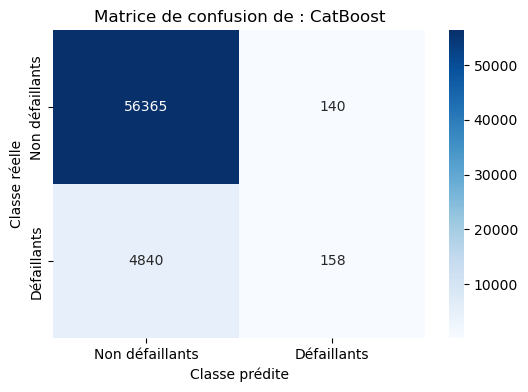

In [10]:
for x in range(len(model_simple)):
    df_resultats, result_table, recall_table = outils_model.process_classification(model_simple[x], X_train, X_test, y_train, 
                                                                                   y_test, df_resultats, titre[x], 
                                                                                   result_table, recall_table)

In [16]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('Dummy', 4998, 0, 0, 56505, df_taux)

In [17]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('LGBM', 4926, 60, 72, 56445, df_taux)

In [18]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('XGBC', 4832, 170, 166, 56335, df_taux)

In [19]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('AdaBoost', 4920, 70, 78, 56435, df_taux)

In [20]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('LogisticRegressor', 4998, 0, 0, 56505, df_taux)

In [21]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('RandomForest', 4984, 10, 14, 56495, df_taux)

In [22]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('CatBoost', 4840, 140, 158, 56365, df_taux)

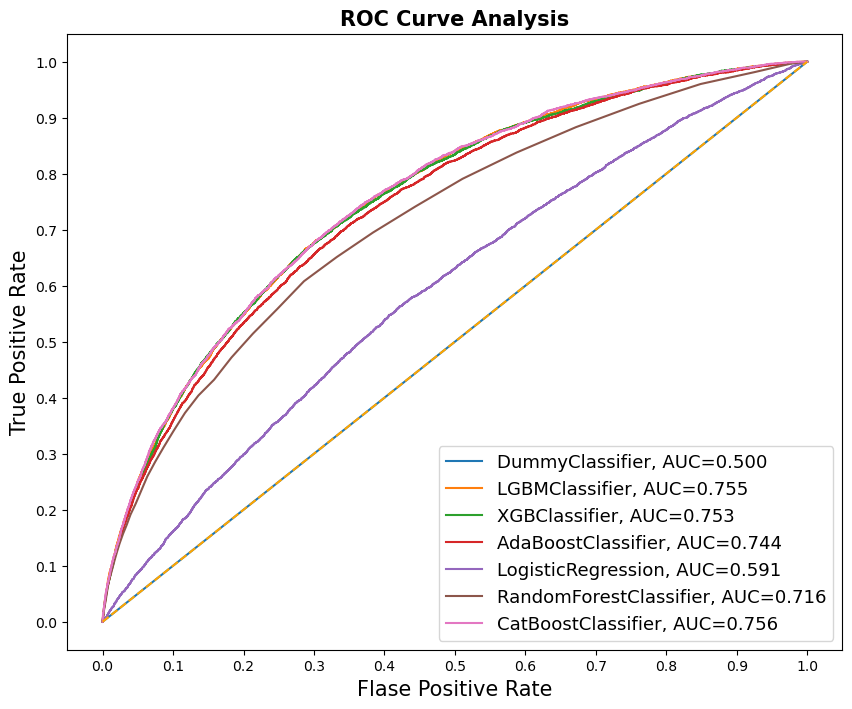

In [11]:
outils_model.roc_plot(result_table)

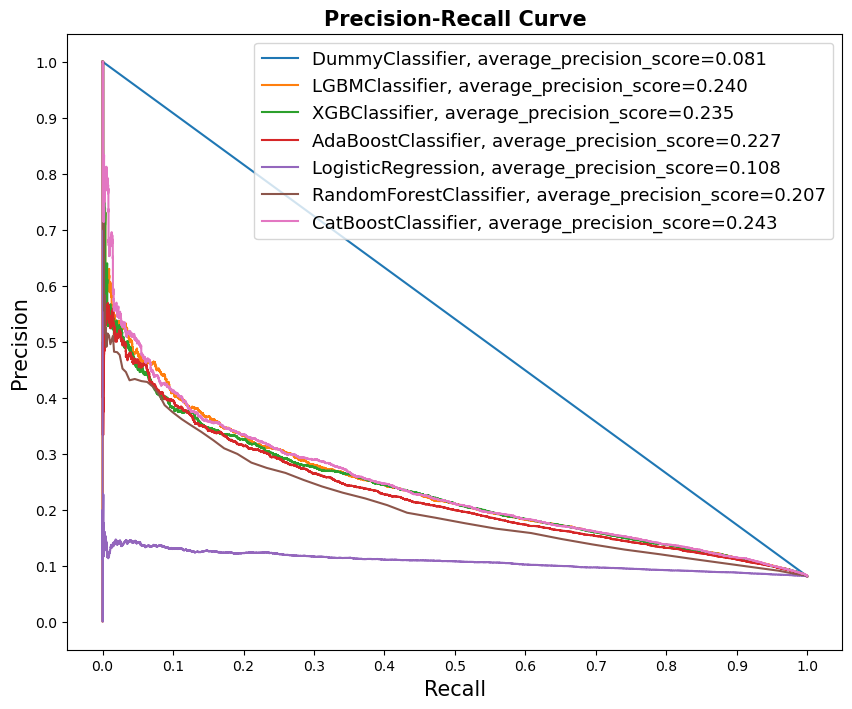

In [12]:
outils_model.avg_plot(recall_table)

#### On remarque, en se basant dans un premier temps sur le ROC AUC et PR AUC, que le modèle avec les meilleurs résulats est LGBM et CatBoost. Suivi de près par XGB. On remarque également qu'un modèle "simple" tel que Dummy n'arrive pas à cerner notre problématique. Il s'agit d'un premier test sans affinage des paramètres et avec une classe de prédiction déséquilibré

Dummy
Score F10 maximal : 0.899332446111993
Seuil maximal : 0.0
-----------------------------------------------------------


LGBM
Score F10 maximal : 0.8996930908002096
Seuil maximal : 0.01
-----------------------------------------------------------


XGBC
Score F10 maximal : 0.899332446111993
Seuil maximal : 0.0
-----------------------------------------------------------


AdaBoost
Score F10 maximal : 0.899332446111993
Seuil maximal : 0.0
-----------------------------------------------------------


LogisticRegressor
Score F10 maximal : 0.899332446111993
Seuil maximal : 0.0
-----------------------------------------------------------


RandomForest
Score F10 maximal : 0.8986201527688006
Seuil maximal : 0.0
-----------------------------------------------------------


CatBoost
Score F10 maximal : 0.9004530149108464
Seuil maximal : 0.01
-----------------------------------------------------------




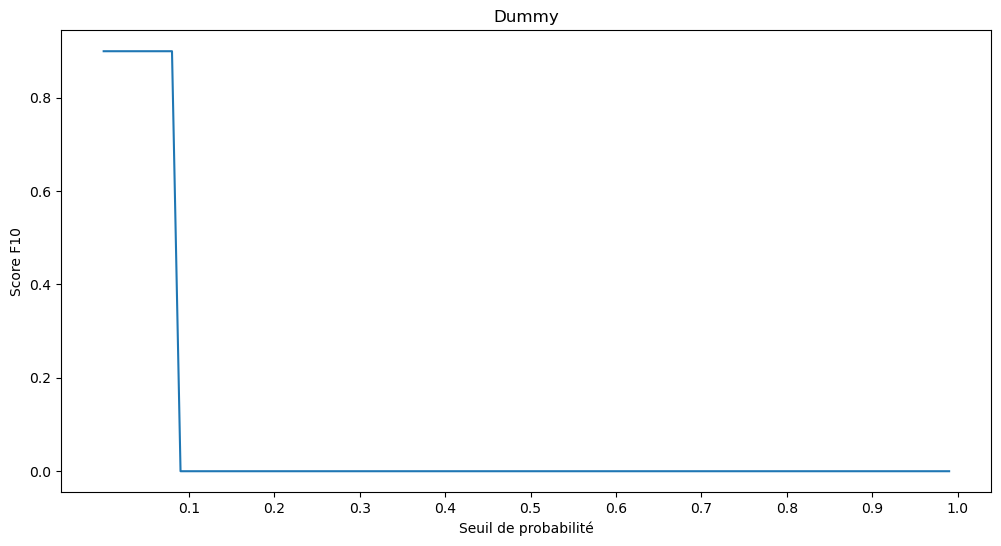

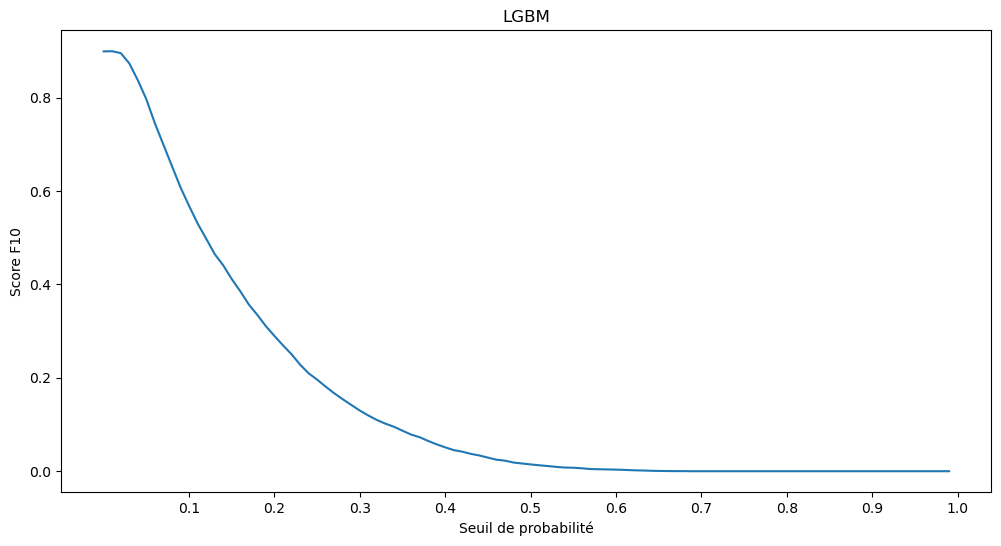

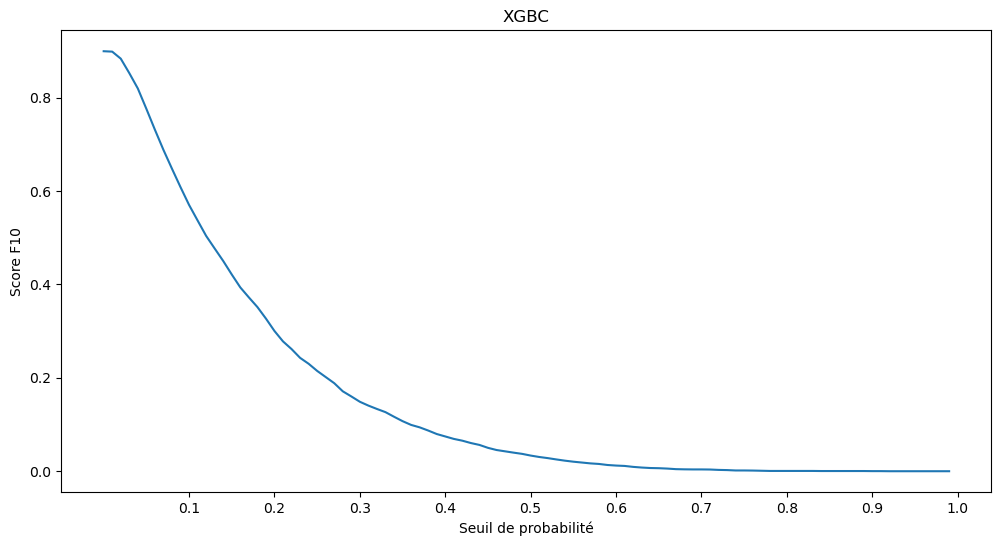

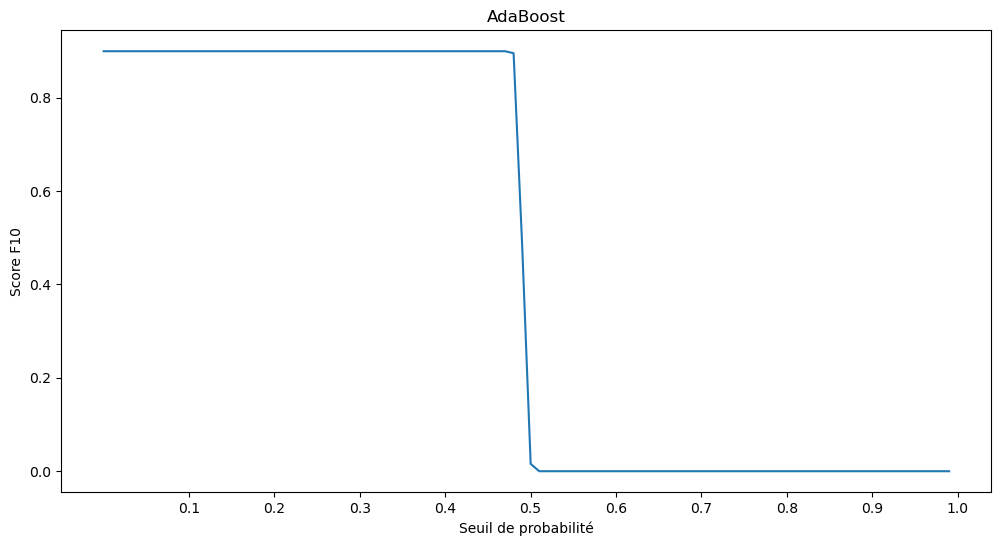

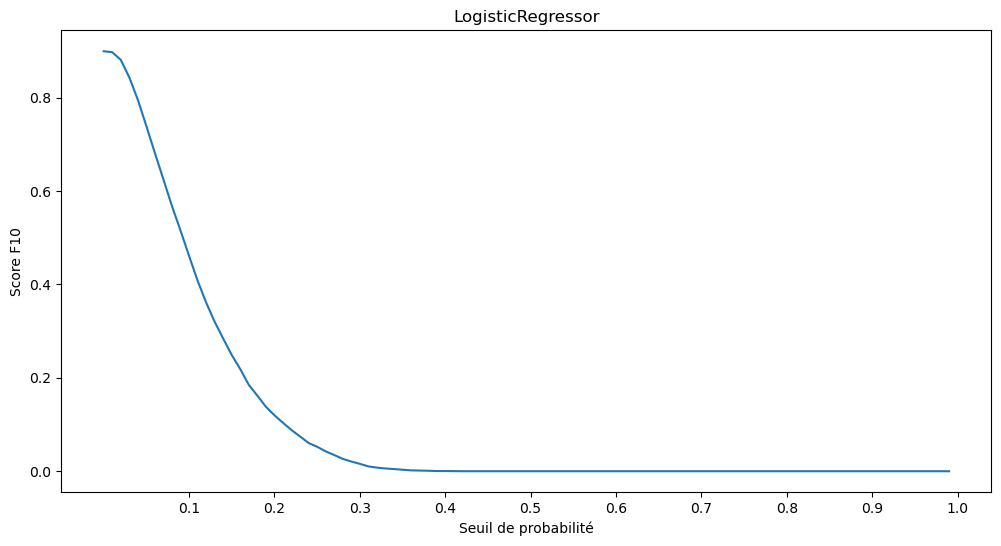

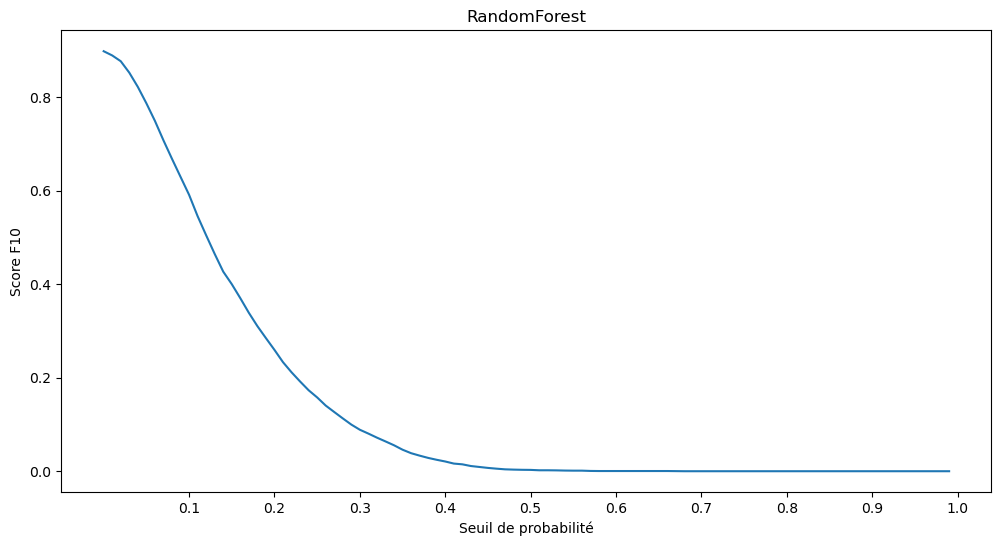

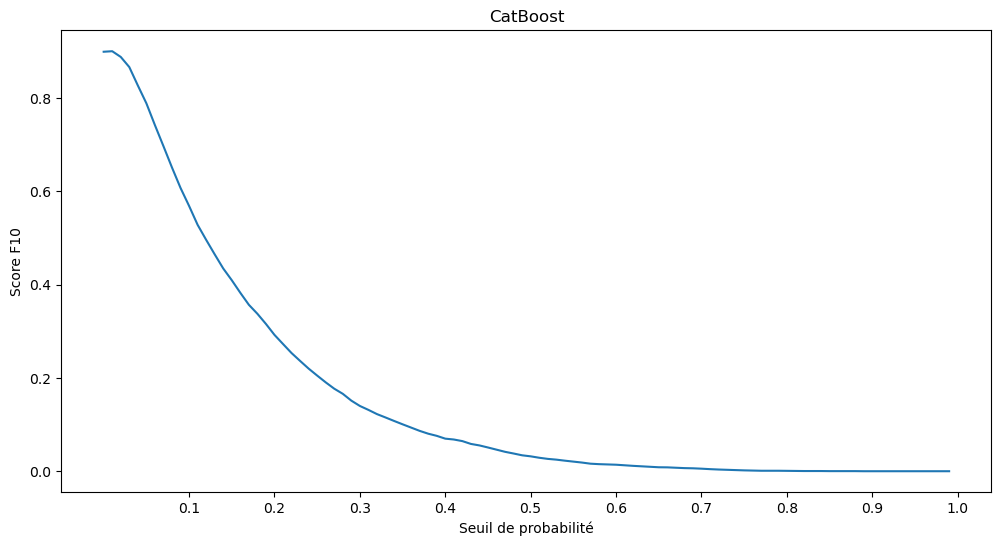

In [13]:
for x in range(len(model_simple)):
    outils_model.determiner_seuil_probabilite_F10(model_simple[x], X_test, y_test, titre[x], n=1)

#### On remarque un seuil égale ou très proche de zéro pour quasi tout les modèles. Cela s'explique par le faite que la classe 0 est dominante au sein du dataset. On va dans ce cas, sachant que les score ROC AUC et PR AUC sont prometteurs, optimisé nos modèles, rechercher les meilleurs paramètres possible, surtout pour le paramètre de poids, afin de donné plus de poids à la classe monoritaire. Cela nous permettra de peut etre, trouver un seuil de probabilité différent de zéro.
#### Concernant le score ROC AUC, une mesure de performance très couramment utilisée pour évaluer la qualité d'un modèle de classification binaire, qui nous servira de première base afin de comparé les modèles, il est représenté sous la forme d'une courbe ROC qui mesure la sensibilité et la spécificité du modèle pour différentes valeurs seuils de classification, avec l'AUC qui représente la performance numérique du modèle.

# Modeling with tuned hyperparameters

- Pour notre problématique :
    - les **défaillants** forment la classe **positive**,
    - les **non-défaillants** forment la classe **négative**.
- Pour minimiser les pertes d'argent, nous devons :
    - nous efforcer de ne pas prédire un client non-défaillant s'il est défaillant ==> **minimiser le nombre de faux négatifs** (prédit non-défaillant mais client défaillant). Si un défaillant est prédit non défaillant, le groupe Home Crédit aura perdu toute la somme prêtée à l'emprunteur. Cela constitue les plus grosses pertes pour l'entreprise.
    - nous efforcer de ne pas prédire de défaillant si le client n'est pas défaillant donc **minimiser les faux positifs** (classe 1 défaillant alors que non-défaillant dans la réalité). Si un non-défaillant est prédit défaillant, le groupe Home Crédit aura perdu les intérêts de la somme prêtée à l'emprunteur. 
- La métrique pour déterminer le **taux de vrais positif** est le Rappel/**Recall**, elle mesure parmi toutes les observations positives combien ont été classées comme positives. Pour ne pas avoir de pertes, il faut détecter tous les défaillants (classe positive) donc **maximiser la métrique recall**.
- La métrique **Precision**  mesure le nombre d'observations prédites comme positives (client défaillant) qui le sont en réalité. Si le client est prédit défaillant alors qu'il ne le sera pas le prêt ne sera pas accordé et les intérêts ne seront pas empochés. Il faut donc **maximiser la 'Precision'**.

***Note :***
***
- Si on augmente le recall, la précision diminue, il s'agit de faire un compromis entre ces 2 métriques qui dépendent l'une de l'autre, en prenant en compte le métier/problème de l'entreprise et les coûts associés pour répondre à ces questions.
- Dans notre cas, il faut trouver le plus grand nombre d'observations réellement positives (client prédit défaillant et bien défaillant) et la perte est moins grande si on prédit un client défaillant mais qu'il n'est pas défaillant (faux positifs), donc **on donnera priorité à maximiser le recall au dépend de la précision** (on parle bien de Precision pas d'accuracy).
- Le réglage du paramètre beta pour le Fbeta score permet de donner plus de poids au recall (beta>1) qu'à la précision (0<beta<1). Le score F1 est la moyenne harmonique entre le recall et la précision.

<div style="padding: 5px 0px; font-family: Cursive; font-size:16px; background-color:#fef1ff;padding: 25px 10px">
We used Random search for tuning hyperparameters</div>

In [15]:
# ----------------------------------------------------------
# Stratified K-Folds cross-validator
# Provides train/test indices to split data in train/test sets.
# This cross-validation object is a variation of KFold that returns stratified folds. 
# The folds are made by preserving the percentage of samples for each class
kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

# Fonction, qui en fonction du model, renvoie le resultats roc_auc moyen avec une validation croisé
def cross_validation(x, y, model):
    result= cross_val_score(model, x, y, cv=kfold, scoring="roc_auc", n_jobs=-1)
    print("Score: %f" % result.mean())
    
# ----------------------------------------------------------
# Fonction utilisant un RandomizeSearchCV, en fonction du model, renvoie le meilleur score, estimator et param
def RndSrch_Tune(model, X, y, params):
    
    clf = RandomizedSearchCV(model, params, scoring ='roc_auc', cv = kfold, n_jobs=-1, random_state=100)
    clf.fit(X, y)
    print("best score is :" , clf.best_score_)
    print("best estimator is :" , clf.best_estimator_)
    print("best Params is :" , clf.best_params_)
    return (clf.best_score_)

##### RandomSearch plutot qu'un GridSearch afin d'avoir des temps de traitement moins long

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
DummyClassifier</h3></center>
</div>

In [23]:
# Value of hyperparameters for random search

#param_dummy = {'strategy' : ['most_frequent', 'prior', 'stratified', 'uniform', 'constant']}

#RndSrch_Tune(DummyClassifier(random_state=100), X_train, y_train, param_dummy)

best score is : 0.5015907984116976
best estimator is : DummyClassifier(random_state=100, strategy='stratified')
best Params is : {'strategy': 'stratified'}


0.5015907984116976

In [25]:
dummy_param = DummyClassifier(strategy='stratified', random_state=100)

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
LGBMClassifier</h3></center>
</div>

In [24]:
# Value of hyperparameters for random search

#param_lgb = {'learning_rate':[0.2,0.1,0.01,0.05,0.001],
#              'num_leaves':range(10,100,10),
#              'min_child_samples':range(500,1000,100),
#              'reg_alpha':[0.1,0.01,0.2,0.3],
#              'reg_lambda':[0.1,0.01,0.2,0.3],
#              'n_estimators':range(50,300,50),
#              'max_bin': range(500,1500,100),
#              'class_weight' : ['balanced','is_unbalanced','scale_pos_weight']}

#RndSrch_Tune(LGBMClassifier(random_state = 100, n_jobs=-1), X_train, y_train, param_lgb)

best score is : 0.7563261622161489
best estimator is : LGBMClassifier(class_weight='balanced', max_bin=1000, min_child_samples=700,
               n_estimators=250, num_leaves=50, random_state=100, reg_alpha=0.2,
               reg_lambda=0.1)
best Params is : {'reg_lambda': 0.1, 'reg_alpha': 0.2, 'num_leaves': 50, 'n_estimators': 250, 'min_child_samples': 700, 'max_bin': 1000, 'learning_rate': 0.1, 'class_weight': 'balanced'}


0.7563261622161489

In [26]:
lgb_param = LGBMClassifier(**{'reg_lambda': 0.1, 
                                'reg_alpha': 0.2, 
                                'num_leaves': 50, 
                                'n_estimators': 250, 
                                'min_child_samples': 700, 
                                'learning_rate': 0.1,
                                'max_bin': 1000,
                                'objective': 'binary',
                                'n_jobs': -1,
                                'class_weight':'balanced',
                                'random_state':100})

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
XGBClassifier</h3></center>
</div>

In [27]:
# Control the balance of positive and negative weights, useful for unbalanced classes. 
# A typical value to consider: sum(negative instances) / sum(positive instances)
counter = Counter(y)
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 11.387


In [28]:
# Value of hyperparameters for random search

#param_xgbc = {'learning_rate':[0.2,0.1,0.01,0.05,0.001],
#              'subsample':[1,0.5,0.2,0.1],
#              'max_depth' : range(2,11,1),
#              'n_estimators':range(50,300,50),
#              'max_delta_step':range(1,10,1)}

#RndSrch_Tune(XGBClassifier(random_state = 100, n_jobs=-1, scale_pos_weight=estimate), 
#              X_train, y_train, param_xgbc)

[01:53:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best score is : 0.7512784497742399
best estimator is : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=7,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=11.387150050352467,
              subsample=1, tree_method='exact', valida

0.7512784497742399

In [30]:
xgbc_param = XGBClassifier(learning_rate=0.05,
                     subsample=1,
                     max_delta_step=7,
                     max_depth=8, 
                     n_jobs=-1, 
                     n_estimators=150,
                     random_state=100,
                     scale_pos_weight=11.387150050352467)

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
AdaBoostClassifier</h3></center>
</div>

In [31]:
# Value of hyperparameters for random search

#param_ada = {'learning_rate':[0.2,0.1,0.01,0.05,0.001],
#              'algorithm': ['SAMME', 'SAMME.R'],
#              'n_estimators':range(50,300,50)}

#RndSrch_Tune(AdaBoostClassifier(random_state = 100), X_train, y_train, param_ada)

best score is : 0.7453885089715289
best estimator is : AdaBoostClassifier(learning_rate=0.2, n_estimators=200, random_state=100)
best Params is : {'n_estimators': 200, 'learning_rate': 0.2, 'algorithm': 'SAMME.R'}


0.7453885089715289

In [35]:
ada_param = AdaBoostClassifier(learning_rate=0.2, 
                         algorithm = 'SAMME.R',
                         n_estimators=200, 
                         random_state=100)

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
LogisticRegression</h3></center>
</div>

In [32]:
# The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in 
# the input data as n_samples / (n_classes * np.bincount(y))
n_samples = df_train[col].shape[0]
n_classes = 2
weight = n_samples / (n_classes * np.bincount(y))
print(weight)

[0.54390914 6.19357503]


In [33]:
# Value of hyperparameters for random search

#param_lr = {'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
#            'penalty' : ['none', 'l1', 'l2', 'elasticnet'],
#            'C' : [100, 10, 1.0, 0.1, 0.01],
#            'class_weight': [{'0':'0.54390914', '1':'6.19357503'},'balanced']}

#RndSrch_Tune(LogisticRegression(random_state = 100), X_train, y_train, param_lr)

best score is : 0.6842996665339459
best estimator is : LogisticRegression(C=0.01, class_weight='balanced', random_state=100,
                   solver='liblinear')
best Params is : {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.01}


0.6842996665339459

In [36]:
lr_param = LogisticRegression(C=0.01,
                        penalty='l2',
                        solver='liblinear',
                        random_state=100,
                        n_jobs=-1,
                        class_weight='balanced')

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
RandomForestClassifier</h3></center>
</div>

In [37]:
# Value of hyperparameters for random search

#param_rand = {'max_features' : ['sqrt', 'log2','auto'],
#              'max_depth' : range(2,11,1),
#              'n_estimators':range(50,300,50),
#              'bootstrap': [True,False],
#              'class_weight': [{'0':'0.54390914', '1':'6.19357503'},'balanced','balanced_subsample']}

#RndSrch_Tune(RandomForestClassifier(random_state = 100), X_train, y_train, param_rand)

best score is : 0.7356570825117966
best estimator is : RandomForestClassifier(class_weight='balanced_subsample', max_depth=8,
                       max_features='log2', random_state=100)
best Params is : {'n_estimators': 100, 'max_features': 'log2', 'max_depth': 8, 'class_weight': 'balanced_subsample', 'bootstrap': True}


0.7356570825117966

In [39]:
rand_param = RandomForestClassifier(n_estimators=100,
                              max_features='log2',
                              max_depth=8,
                              class_weight='balanced_subsample',
                              bootstrap=True,
                              random_state=100,
                              n_jobs=-1)

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
CatBoostClassifer</h3></center>
</div>

In [38]:
# Value of hyperparameters for random search

#param_cat = {'depth' : [4,5,6,7,8,9,10],
#             'learning_rate':[0.2,0.1,0.01,0.05,0.001],
#             'n_estimators':range(50,300,50)}

#RndSrch_Tune(CatBoostClassifier(random_state = 100), X_train, y_train, param_cat)

0:	learn: 0.5031329	total: 40.4ms	remaining: 10.1s
1:	learn: 0.4032340	total: 83.7ms	remaining: 10.4s
2:	learn: 0.3450568	total: 124ms	remaining: 10.2s
3:	learn: 0.3110549	total: 167ms	remaining: 10.3s
4:	learn: 0.2931956	total: 211ms	remaining: 10.3s
5:	learn: 0.2789505	total: 259ms	remaining: 10.5s
6:	learn: 0.2700618	total: 323ms	remaining: 11.2s
7:	learn: 0.2647500	total: 370ms	remaining: 11.2s
8:	learn: 0.2615846	total: 430ms	remaining: 11.5s
9:	learn: 0.2587490	total: 483ms	remaining: 11.6s
10:	learn: 0.2570930	total: 543ms	remaining: 11.8s
11:	learn: 0.2556462	total: 589ms	remaining: 11.7s
12:	learn: 0.2545842	total: 635ms	remaining: 11.6s
13:	learn: 0.2536583	total: 679ms	remaining: 11.5s
14:	learn: 0.2529675	total: 728ms	remaining: 11.4s
15:	learn: 0.2524685	total: 778ms	remaining: 11.4s
16:	learn: 0.2520388	total: 829ms	remaining: 11.4s
17:	learn: 0.2517678	total: 880ms	remaining: 11.3s
18:	learn: 0.2513435	total: 928ms	remaining: 11.3s
19:	learn: 0.2510454	total: 979ms	remai

165:	learn: 0.2402600	total: 7.81s	remaining: 3.95s
166:	learn: 0.2402130	total: 7.85s	remaining: 3.9s
167:	learn: 0.2401724	total: 7.89s	remaining: 3.85s
168:	learn: 0.2401222	total: 7.93s	remaining: 3.8s
169:	learn: 0.2400695	total: 7.97s	remaining: 3.75s
170:	learn: 0.2400577	total: 8s	remaining: 3.7s
171:	learn: 0.2400089	total: 8.04s	remaining: 3.65s
172:	learn: 0.2399724	total: 8.08s	remaining: 3.6s
173:	learn: 0.2399267	total: 8.12s	remaining: 3.55s
174:	learn: 0.2398875	total: 8.16s	remaining: 3.5s
175:	learn: 0.2398369	total: 8.19s	remaining: 3.44s
176:	learn: 0.2397888	total: 8.23s	remaining: 3.4s
177:	learn: 0.2397338	total: 8.27s	remaining: 3.35s
178:	learn: 0.2396856	total: 8.31s	remaining: 3.3s
179:	learn: 0.2396405	total: 8.35s	remaining: 3.25s
180:	learn: 0.2396076	total: 8.39s	remaining: 3.2s
181:	learn: 0.2395599	total: 8.44s	remaining: 3.15s
182:	learn: 0.2394903	total: 8.49s	remaining: 3.11s
183:	learn: 0.2394501	total: 8.53s	remaining: 3.06s
184:	learn: 0.2394058	t

0.7570658368867873

In [40]:
cat_param = CatBoostClassifier(learning_rate = 0.2,
                         n_estimators=250,
                         depth = 5,
                         random_state = 100)

In [41]:
model_param = [dummy_param, lgb_param, xgbc_param, ada_param, lr_param, rand_param, cat_param]
titre_param = ['Dummy_param', 'LGBM_param', 'XGBC_param', 'AdaBoost_param', 'LogisticRegressor_param', 'RandomForest_param', 'CatBoost_param']

Successfully registered model 'Dummy_param'.
2023/04/18 02:24:28 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Dummy_param, version 1
Created version '1' of model 'Dummy_param'.


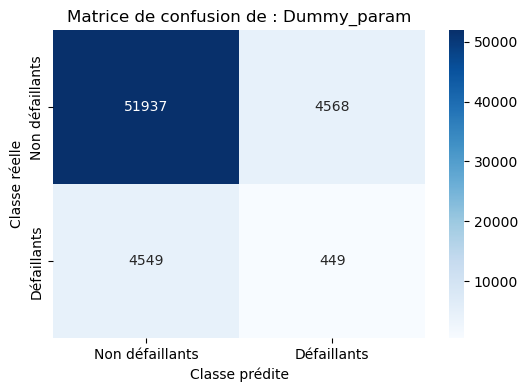

Successfully registered model 'LGBM_param'.
2023/04/18 02:25:42 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LGBM_param, version 1
Created version '1' of model 'LGBM_param'.


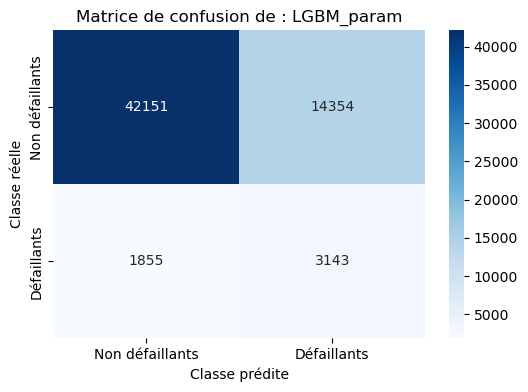

[02:25:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:26:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:27:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:28:53] WARNING:

Successfully registered model 'XGBC_param'.
2023/04/18 02:37:07 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGBC_param, version 1
Created version '1' of model 'XGBC_param'.


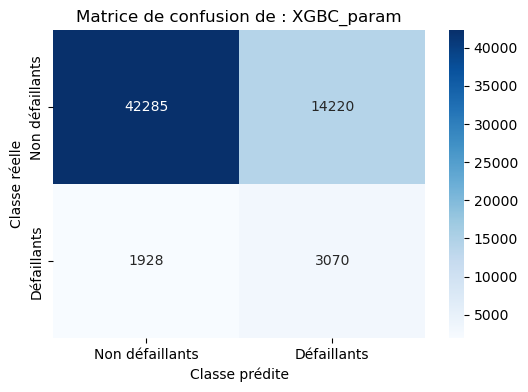

Successfully registered model 'AdaBoost_param'.
2023/04/18 02:55:36 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: AdaBoost_param, version 1
Created version '1' of model 'AdaBoost_param'.


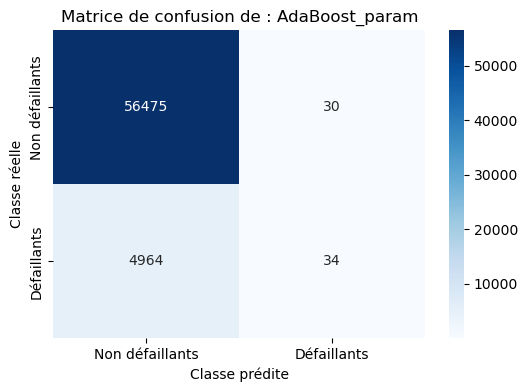

Successfully registered model 'LogisticRegressor_param'.
2023/04/18 02:56:55 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LogisticRegressor_param, version 1
Created version '1' of model 'LogisticRegressor_param'.


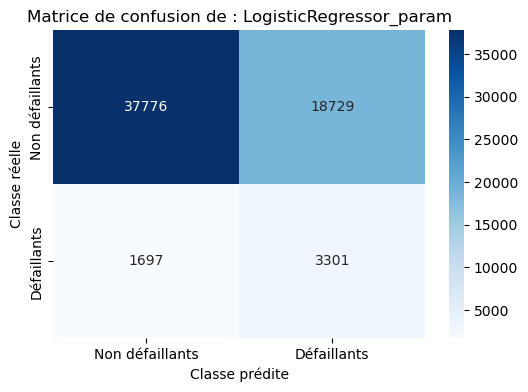

Successfully registered model 'RandomForest_param'.
2023/04/18 02:59:00 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: RandomForest_param, version 1
Created version '1' of model 'RandomForest_param'.


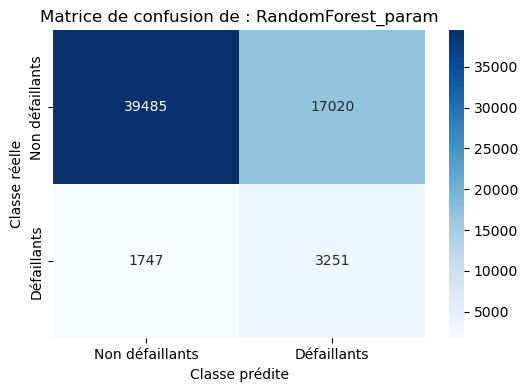

0:	learn: 0.5031329	total: 31.5ms	remaining: 7.85s
1:	learn: 0.4032340	total: 61ms	remaining: 7.57s
2:	learn: 0.3450568	total: 90.9ms	remaining: 7.48s
3:	learn: 0.3110549	total: 128ms	remaining: 7.84s
4:	learn: 0.2931956	total: 157ms	remaining: 7.71s
5:	learn: 0.2789505	total: 186ms	remaining: 7.55s
6:	learn: 0.2700618	total: 216ms	remaining: 7.51s
7:	learn: 0.2647500	total: 246ms	remaining: 7.45s
8:	learn: 0.2615846	total: 278ms	remaining: 7.44s
9:	learn: 0.2587490	total: 311ms	remaining: 7.46s
10:	learn: 0.2570930	total: 347ms	remaining: 7.55s
11:	learn: 0.2556462	total: 378ms	remaining: 7.49s
12:	learn: 0.2545842	total: 411ms	remaining: 7.49s
13:	learn: 0.2536583	total: 444ms	remaining: 7.49s
14:	learn: 0.2529675	total: 477ms	remaining: 7.47s
15:	learn: 0.2524685	total: 510ms	remaining: 7.46s
16:	learn: 0.2520388	total: 542ms	remaining: 7.42s
17:	learn: 0.2517678	total: 578ms	remaining: 7.45s
18:	learn: 0.2513435	total: 613ms	remaining: 7.46s
19:	learn: 0.2510454	total: 646ms	remain

164:	learn: 0.2402958	total: 5.72s	remaining: 2.95s
165:	learn: 0.2402600	total: 5.75s	remaining: 2.91s
166:	learn: 0.2402130	total: 5.79s	remaining: 2.88s
167:	learn: 0.2401724	total: 5.82s	remaining: 2.84s
168:	learn: 0.2401222	total: 5.85s	remaining: 2.81s
169:	learn: 0.2400695	total: 5.89s	remaining: 2.77s
170:	learn: 0.2400577	total: 5.92s	remaining: 2.74s
171:	learn: 0.2400089	total: 5.96s	remaining: 2.7s
172:	learn: 0.2399724	total: 5.99s	remaining: 2.67s
173:	learn: 0.2399267	total: 6.03s	remaining: 2.63s
174:	learn: 0.2398875	total: 6.07s	remaining: 2.6s
175:	learn: 0.2398369	total: 6.12s	remaining: 2.57s
176:	learn: 0.2397888	total: 6.16s	remaining: 2.54s
177:	learn: 0.2397338	total: 6.21s	remaining: 2.51s
178:	learn: 0.2396856	total: 6.25s	remaining: 2.48s
179:	learn: 0.2396405	total: 6.29s	remaining: 2.45s
180:	learn: 0.2396076	total: 6.33s	remaining: 2.41s
181:	learn: 0.2395599	total: 6.37s	remaining: 2.38s
182:	learn: 0.2394903	total: 6.42s	remaining: 2.35s
183:	learn: 0.

77:	learn: 0.2451597	total: 2.61s	remaining: 5.76s
78:	learn: 0.2450471	total: 2.64s	remaining: 5.72s
79:	learn: 0.2449574	total: 2.68s	remaining: 5.7s
80:	learn: 0.2448855	total: 2.71s	remaining: 5.67s
81:	learn: 0.2448272	total: 2.75s	remaining: 5.63s
82:	learn: 0.2447424	total: 2.79s	remaining: 5.61s
83:	learn: 0.2445441	total: 2.83s	remaining: 5.59s
84:	learn: 0.2444695	total: 2.87s	remaining: 5.57s
85:	learn: 0.2443959	total: 2.91s	remaining: 5.54s
86:	learn: 0.2443132	total: 2.95s	remaining: 5.52s
87:	learn: 0.2442402	total: 2.99s	remaining: 5.5s
88:	learn: 0.2441987	total: 3.03s	remaining: 5.48s
89:	learn: 0.2441441	total: 3.07s	remaining: 5.46s
90:	learn: 0.2440907	total: 3.12s	remaining: 5.44s
91:	learn: 0.2440241	total: 3.15s	remaining: 5.42s
92:	learn: 0.2439680	total: 3.19s	remaining: 5.39s
93:	learn: 0.2438942	total: 3.23s	remaining: 5.37s
94:	learn: 0.2438253	total: 3.27s	remaining: 5.33s
95:	learn: 0.2437693	total: 3.31s	remaining: 5.3s
96:	learn: 0.2437236	total: 3.34s	

241:	learn: 0.2364493	total: 9.04s	remaining: 299ms
242:	learn: 0.2364130	total: 9.08s	remaining: 262ms
243:	learn: 0.2363723	total: 9.12s	remaining: 224ms
244:	learn: 0.2363243	total: 9.15s	remaining: 187ms
245:	learn: 0.2362829	total: 9.18s	remaining: 149ms
246:	learn: 0.2362282	total: 9.22s	remaining: 112ms
247:	learn: 0.2361739	total: 9.25s	remaining: 74.6ms
248:	learn: 0.2361214	total: 9.29s	remaining: 37.3ms
249:	learn: 0.2360738	total: 9.32s	remaining: 0us
0:	learn: 0.5030524	total: 29.9ms	remaining: 7.44s
1:	learn: 0.4040639	total: 59.5ms	remaining: 7.38s
2:	learn: 0.3433811	total: 91.3ms	remaining: 7.52s
3:	learn: 0.3087419	total: 124ms	remaining: 7.65s
4:	learn: 0.2893526	total: 156ms	remaining: 7.64s
5:	learn: 0.2766550	total: 187ms	remaining: 7.61s
6:	learn: 0.2695731	total: 220ms	remaining: 7.63s
7:	learn: 0.2642555	total: 254ms	remaining: 7.7s
8:	learn: 0.2610437	total: 288ms	remaining: 7.71s
9:	learn: 0.2584420	total: 326ms	remaining: 7.81s
10:	learn: 0.2563395	total: 36

154:	learn: 0.2400523	total: 5.14s	remaining: 3.15s
155:	learn: 0.2399909	total: 5.18s	remaining: 3.12s
156:	learn: 0.2399460	total: 5.21s	remaining: 3.09s
157:	learn: 0.2398959	total: 5.25s	remaining: 3.06s
158:	learn: 0.2398622	total: 5.29s	remaining: 3.03s
159:	learn: 0.2397984	total: 5.33s	remaining: 3s
160:	learn: 0.2397547	total: 5.37s	remaining: 2.97s
161:	learn: 0.2397040	total: 5.4s	remaining: 2.93s
162:	learn: 0.2396351	total: 5.44s	remaining: 2.9s
163:	learn: 0.2395870	total: 5.47s	remaining: 2.87s
164:	learn: 0.2395312	total: 5.51s	remaining: 2.84s
165:	learn: 0.2394614	total: 5.54s	remaining: 2.8s
166:	learn: 0.2394074	total: 5.58s	remaining: 2.77s
167:	learn: 0.2393545	total: 5.61s	remaining: 2.74s
168:	learn: 0.2393200	total: 5.65s	remaining: 2.71s
169:	learn: 0.2392640	total: 5.68s	remaining: 2.67s
170:	learn: 0.2392164	total: 5.71s	remaining: 2.64s
171:	learn: 0.2391814	total: 5.74s	remaining: 2.6s
172:	learn: 0.2391392	total: 5.77s	remaining: 2.57s
173:	learn: 0.23907

65:	learn: 0.2458647	total: 2.55s	remaining: 7.11s
66:	learn: 0.2457019	total: 2.59s	remaining: 7.09s
67:	learn: 0.2456113	total: 2.63s	remaining: 7.04s
68:	learn: 0.2455269	total: 2.67s	remaining: 6.99s
69:	learn: 0.2454346	total: 2.7s	remaining: 6.94s
70:	learn: 0.2453661	total: 2.74s	remaining: 6.91s
71:	learn: 0.2453148	total: 2.78s	remaining: 6.87s
72:	learn: 0.2451481	total: 2.82s	remaining: 6.83s
73:	learn: 0.2450594	total: 2.86s	remaining: 6.79s
74:	learn: 0.2449892	total: 2.89s	remaining: 6.75s
75:	learn: 0.2449271	total: 2.93s	remaining: 6.7s
76:	learn: 0.2448792	total: 2.96s	remaining: 6.65s
77:	learn: 0.2447845	total: 3s	remaining: 6.61s
78:	learn: 0.2447146	total: 3.03s	remaining: 6.57s
79:	learn: 0.2446601	total: 3.07s	remaining: 6.52s
80:	learn: 0.2446002	total: 3.1s	remaining: 6.46s
81:	learn: 0.2445264	total: 3.13s	remaining: 6.4s
82:	learn: 0.2444388	total: 3.16s	remaining: 6.35s
83:	learn: 0.2443393	total: 3.19s	remaining: 6.3s
84:	learn: 0.2442447	total: 3.23s	remai

226:	learn: 0.2371169	total: 7.97s	remaining: 808ms
227:	learn: 0.2370891	total: 8.01s	remaining: 773ms
228:	learn: 0.2370504	total: 8.04s	remaining: 737ms
229:	learn: 0.2370095	total: 8.07s	remaining: 702ms
230:	learn: 0.2369712	total: 8.11s	remaining: 667ms
231:	learn: 0.2369328	total: 8.14s	remaining: 632ms
232:	learn: 0.2368845	total: 8.17s	remaining: 596ms
233:	learn: 0.2368300	total: 8.21s	remaining: 561ms
234:	learn: 0.2367961	total: 8.23s	remaining: 526ms
235:	learn: 0.2367445	total: 8.27s	remaining: 491ms
236:	learn: 0.2367070	total: 8.3s	remaining: 455ms
237:	learn: 0.2366644	total: 8.33s	remaining: 420ms
238:	learn: 0.2366120	total: 8.36s	remaining: 385ms
239:	learn: 0.2365694	total: 8.39s	remaining: 350ms
240:	learn: 0.2365143	total: 8.42s	remaining: 315ms
241:	learn: 0.2364704	total: 8.46s	remaining: 280ms
242:	learn: 0.2364226	total: 8.49s	remaining: 245ms
243:	learn: 0.2363754	total: 8.53s	remaining: 210ms
244:	learn: 0.2363429	total: 8.56s	remaining: 175ms
245:	learn: 0

138:	learn: 0.2408561	total: 4.73s	remaining: 3.78s
139:	learn: 0.2407951	total: 4.77s	remaining: 3.75s
140:	learn: 0.2407344	total: 4.8s	remaining: 3.71s
141:	learn: 0.2406955	total: 4.84s	remaining: 3.68s
142:	learn: 0.2406485	total: 4.87s	remaining: 3.64s
143:	learn: 0.2406010	total: 4.9s	remaining: 3.61s
144:	learn: 0.2405895	total: 4.93s	remaining: 3.57s
145:	learn: 0.2405208	total: 4.98s	remaining: 3.55s
146:	learn: 0.2404575	total: 5.02s	remaining: 3.52s
147:	learn: 0.2404228	total: 5.06s	remaining: 3.49s
148:	learn: 0.2403819	total: 5.09s	remaining: 3.45s
149:	learn: 0.2403267	total: 5.13s	remaining: 3.42s
150:	learn: 0.2402552	total: 5.17s	remaining: 3.39s
151:	learn: 0.2402157	total: 5.21s	remaining: 3.36s
152:	learn: 0.2401566	total: 5.25s	remaining: 3.33s
153:	learn: 0.2401040	total: 5.29s	remaining: 3.3s
154:	learn: 0.2400610	total: 5.34s	remaining: 3.27s
155:	learn: 0.2400007	total: 5.37s	remaining: 3.24s
156:	learn: 0.2399600	total: 5.41s	remaining: 3.21s
157:	learn: 0.2

48:	learn: 0.2470764	total: 1.58s	remaining: 6.5s
49:	learn: 0.2469162	total: 1.63s	remaining: 6.52s
50:	learn: 0.2468618	total: 1.66s	remaining: 6.49s
51:	learn: 0.2467758	total: 1.7s	remaining: 6.45s
52:	learn: 0.2466919	total: 1.72s	remaining: 6.41s
53:	learn: 0.2466186	total: 1.76s	remaining: 6.38s
54:	learn: 0.2465407	total: 1.8s	remaining: 6.38s
55:	learn: 0.2464721	total: 1.84s	remaining: 6.36s
56:	learn: 0.2463856	total: 1.87s	remaining: 6.32s
57:	learn: 0.2463215	total: 1.9s	remaining: 6.29s
58:	learn: 0.2461901	total: 1.93s	remaining: 6.24s
59:	learn: 0.2461344	total: 1.96s	remaining: 6.22s
60:	learn: 0.2460702	total: 2s	remaining: 6.18s
61:	learn: 0.2460023	total: 2.04s	remaining: 6.18s
62:	learn: 0.2458856	total: 2.08s	remaining: 6.18s
63:	learn: 0.2458117	total: 2.12s	remaining: 6.16s
64:	learn: 0.2457390	total: 2.16s	remaining: 6.14s
65:	learn: 0.2456435	total: 2.2s	remaining: 6.13s
66:	learn: 0.2455709	total: 2.24s	remaining: 6.13s
67:	learn: 0.2455089	total: 2.28s	remai

211:	learn: 0.2376572	total: 6.96s	remaining: 1.25s
212:	learn: 0.2376220	total: 7s	remaining: 1.22s
213:	learn: 0.2376128	total: 7.03s	remaining: 1.18s
214:	learn: 0.2375700	total: 7.06s	remaining: 1.15s
215:	learn: 0.2375553	total: 7.09s	remaining: 1.11s
216:	learn: 0.2375257	total: 7.13s	remaining: 1.08s
217:	learn: 0.2374843	total: 7.16s	remaining: 1.05s
218:	learn: 0.2374377	total: 7.19s	remaining: 1.02s
219:	learn: 0.2373947	total: 7.22s	remaining: 985ms
220:	learn: 0.2373470	total: 7.25s	remaining: 952ms
221:	learn: 0.2373204	total: 7.28s	remaining: 919ms
222:	learn: 0.2372700	total: 7.31s	remaining: 885ms
223:	learn: 0.2372238	total: 7.35s	remaining: 853ms
224:	learn: 0.2371834	total: 7.38s	remaining: 820ms
225:	learn: 0.2371383	total: 7.41s	remaining: 787ms
226:	learn: 0.2370886	total: 7.44s	remaining: 754ms
227:	learn: 0.2370263	total: 7.47s	remaining: 721ms
228:	learn: 0.2369750	total: 7.5s	remaining: 688ms
229:	learn: 0.2369275	total: 7.53s	remaining: 655ms
230:	learn: 0.23

126:	learn: 0.2415116	total: 5.67s	remaining: 5.5s
127:	learn: 0.2414593	total: 5.72s	remaining: 5.45s
128:	learn: 0.2413922	total: 5.76s	remaining: 5.4s
129:	learn: 0.2413398	total: 5.8s	remaining: 5.36s
130:	learn: 0.2412978	total: 5.84s	remaining: 5.31s
131:	learn: 0.2412885	total: 5.88s	remaining: 5.26s
132:	learn: 0.2412288	total: 5.93s	remaining: 5.22s
133:	learn: 0.2411975	total: 5.97s	remaining: 5.17s
134:	learn: 0.2411411	total: 6.01s	remaining: 5.12s
135:	learn: 0.2410963	total: 6.05s	remaining: 5.07s
136:	learn: 0.2410471	total: 6.09s	remaining: 5.03s
137:	learn: 0.2410034	total: 6.15s	remaining: 4.99s
138:	learn: 0.2409603	total: 6.2s	remaining: 4.95s
139:	learn: 0.2409339	total: 6.25s	remaining: 4.91s
140:	learn: 0.2408641	total: 6.3s	remaining: 4.87s
141:	learn: 0.2408280	total: 6.36s	remaining: 4.84s
142:	learn: 0.2407835	total: 6.41s	remaining: 4.79s
143:	learn: 0.2407131	total: 6.46s	remaining: 4.75s
144:	learn: 0.2406641	total: 6.5s	remaining: 4.71s
145:	learn: 0.2406

41:	learn: 0.2473368	total: 1.32s	remaining: 6.55s
42:	learn: 0.2471654	total: 1.36s	remaining: 6.56s
43:	learn: 0.2470566	total: 1.4s	remaining: 6.55s
44:	learn: 0.2468922	total: 1.43s	remaining: 6.53s
45:	learn: 0.2467869	total: 1.47s	remaining: 6.5s
46:	learn: 0.2467160	total: 1.5s	remaining: 6.46s
47:	learn: 0.2466568	total: 1.53s	remaining: 6.43s
48:	learn: 0.2465876	total: 1.57s	remaining: 6.45s
49:	learn: 0.2465395	total: 1.6s	remaining: 6.42s
50:	learn: 0.2464914	total: 1.63s	remaining: 6.38s
51:	learn: 0.2464381	total: 1.66s	remaining: 6.33s
52:	learn: 0.2463153	total: 1.7s	remaining: 6.3s
53:	learn: 0.2462550	total: 1.75s	remaining: 6.36s
54:	learn: 0.2461957	total: 1.79s	remaining: 6.34s
55:	learn: 0.2461332	total: 1.82s	remaining: 6.31s
56:	learn: 0.2460716	total: 1.85s	remaining: 6.26s
57:	learn: 0.2460168	total: 1.88s	remaining: 6.22s
58:	learn: 0.2459129	total: 1.91s	remaining: 6.17s
59:	learn: 0.2458419	total: 1.93s	remaining: 6.13s
60:	learn: 0.2457722	total: 1.96s	rem

202:	learn: 0.2375213	total: 7.02s	remaining: 1.62s
203:	learn: 0.2375047	total: 7.06s	remaining: 1.59s
204:	learn: 0.2374649	total: 7.09s	remaining: 1.56s
205:	learn: 0.2374546	total: 7.13s	remaining: 1.52s
206:	learn: 0.2374143	total: 7.17s	remaining: 1.49s
207:	learn: 0.2373796	total: 7.21s	remaining: 1.46s
208:	learn: 0.2373437	total: 7.26s	remaining: 1.42s
209:	learn: 0.2372952	total: 7.29s	remaining: 1.39s
210:	learn: 0.2372465	total: 7.33s	remaining: 1.35s
211:	learn: 0.2372096	total: 7.37s	remaining: 1.32s
212:	learn: 0.2371775	total: 7.41s	remaining: 1.29s
213:	learn: 0.2371439	total: 7.44s	remaining: 1.25s
214:	learn: 0.2370938	total: 7.48s	remaining: 1.22s
215:	learn: 0.2370396	total: 7.53s	remaining: 1.19s
216:	learn: 0.2369993	total: 7.58s	remaining: 1.15s
217:	learn: 0.2369603	total: 7.62s	remaining: 1.12s
218:	learn: 0.2369237	total: 7.67s	remaining: 1.09s
219:	learn: 0.2368552	total: 7.72s	remaining: 1.05s
220:	learn: 0.2368178	total: 7.77s	remaining: 1.02s
221:	learn: 

116:	learn: 0.2423504	total: 4.05s	remaining: 4.6s
117:	learn: 0.2423345	total: 4.08s	remaining: 4.57s
118:	learn: 0.2422725	total: 4.12s	remaining: 4.53s
119:	learn: 0.2422262	total: 4.16s	remaining: 4.5s
120:	learn: 0.2421855	total: 4.19s	remaining: 4.46s
121:	learn: 0.2421545	total: 4.22s	remaining: 4.43s
122:	learn: 0.2420948	total: 4.25s	remaining: 4.39s
123:	learn: 0.2420459	total: 4.3s	remaining: 4.37s
124:	learn: 0.2419940	total: 4.33s	remaining: 4.33s
125:	learn: 0.2419570	total: 4.37s	remaining: 4.3s
126:	learn: 0.2419007	total: 4.41s	remaining: 4.27s
127:	learn: 0.2418421	total: 4.44s	remaining: 4.23s
128:	learn: 0.2417709	total: 4.47s	remaining: 4.19s
129:	learn: 0.2417198	total: 4.5s	remaining: 4.15s
130:	learn: 0.2416795	total: 4.54s	remaining: 4.12s
131:	learn: 0.2416301	total: 4.57s	remaining: 4.09s
132:	learn: 0.2415807	total: 4.61s	remaining: 4.05s
133:	learn: 0.2415375	total: 4.64s	remaining: 4.01s
134:	learn: 0.2414776	total: 4.67s	remaining: 3.98s
135:	learn: 0.241

29:	learn: 0.2493134	total: 901ms	remaining: 6.61s
30:	learn: 0.2491479	total: 935ms	remaining: 6.6s
31:	learn: 0.2490178	total: 963ms	remaining: 6.56s
32:	learn: 0.2489018	total: 992ms	remaining: 6.52s
33:	learn: 0.2487976	total: 1.02s	remaining: 6.5s
34:	learn: 0.2486979	total: 1.05s	remaining: 6.46s
35:	learn: 0.2486215	total: 1.08s	remaining: 6.43s
36:	learn: 0.2484512	total: 1.12s	remaining: 6.43s
37:	learn: 0.2483846	total: 1.15s	remaining: 6.42s
38:	learn: 0.2482053	total: 1.18s	remaining: 6.4s
39:	learn: 0.2481260	total: 1.21s	remaining: 6.37s
40:	learn: 0.2480575	total: 1.24s	remaining: 6.32s
41:	learn: 0.2479280	total: 1.27s	remaining: 6.28s
42:	learn: 0.2478400	total: 1.3s	remaining: 6.25s
43:	learn: 0.2477658	total: 1.33s	remaining: 6.21s
44:	learn: 0.2477035	total: 1.36s	remaining: 6.21s
45:	learn: 0.2476299	total: 1.4s	remaining: 6.21s
46:	learn: 0.2475604	total: 1.44s	remaining: 6.2s
47:	learn: 0.2474176	total: 1.47s	remaining: 6.2s
48:	learn: 0.2472323	total: 1.51s	rema

192:	learn: 0.2385528	total: 7.18s	remaining: 2.12s
193:	learn: 0.2385003	total: 7.24s	remaining: 2.09s
194:	learn: 0.2384581	total: 7.28s	remaining: 2.05s
195:	learn: 0.2384055	total: 7.32s	remaining: 2.02s
196:	learn: 0.2383627	total: 7.36s	remaining: 1.98s
197:	learn: 0.2383293	total: 7.4s	remaining: 1.94s
198:	learn: 0.2382970	total: 7.45s	remaining: 1.91s
199:	learn: 0.2382518	total: 7.49s	remaining: 1.87s
200:	learn: 0.2381962	total: 7.54s	remaining: 1.84s
201:	learn: 0.2381353	total: 7.58s	remaining: 1.8s
202:	learn: 0.2380877	total: 7.62s	remaining: 1.76s
203:	learn: 0.2380435	total: 7.66s	remaining: 1.73s
204:	learn: 0.2379945	total: 7.69s	remaining: 1.69s
205:	learn: 0.2379612	total: 7.72s	remaining: 1.65s
206:	learn: 0.2379238	total: 7.77s	remaining: 1.61s
207:	learn: 0.2378810	total: 7.81s	remaining: 1.58s
208:	learn: 0.2378299	total: 7.84s	remaining: 1.54s
209:	learn: 0.2377950	total: 7.89s	remaining: 1.5s
210:	learn: 0.2377552	total: 7.92s	remaining: 1.46s
211:	learn: 0.2

104:	learn: 0.2429830	total: 3.64s	remaining: 5.03s
105:	learn: 0.2429309	total: 3.68s	remaining: 5s
106:	learn: 0.2428743	total: 3.72s	remaining: 4.97s
107:	learn: 0.2428078	total: 3.75s	remaining: 4.93s
108:	learn: 0.2427504	total: 3.79s	remaining: 4.9s
109:	learn: 0.2426963	total: 3.82s	remaining: 4.86s
110:	learn: 0.2426408	total: 3.85s	remaining: 4.82s
111:	learn: 0.2425835	total: 3.89s	remaining: 4.79s
112:	learn: 0.2425160	total: 3.92s	remaining: 4.76s
113:	learn: 0.2424625	total: 3.96s	remaining: 4.72s
114:	learn: 0.2424233	total: 3.98s	remaining: 4.68s
115:	learn: 0.2423542	total: 4.01s	remaining: 4.63s
116:	learn: 0.2422957	total: 4.04s	remaining: 4.6s
117:	learn: 0.2422444	total: 4.08s	remaining: 4.56s
118:	learn: 0.2421958	total: 4.11s	remaining: 4.53s
119:	learn: 0.2421584	total: 4.15s	remaining: 4.5s
120:	learn: 0.2420858	total: 4.19s	remaining: 4.46s
121:	learn: 0.2420488	total: 4.22s	remaining: 4.43s
122:	learn: 0.2420011	total: 4.25s	remaining: 4.39s
123:	learn: 0.2419

Successfully registered model 'CatBoost_param'.
2023/04/18 03:00:53 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CatBoost_param, version 1
Created version '1' of model 'CatBoost_param'.


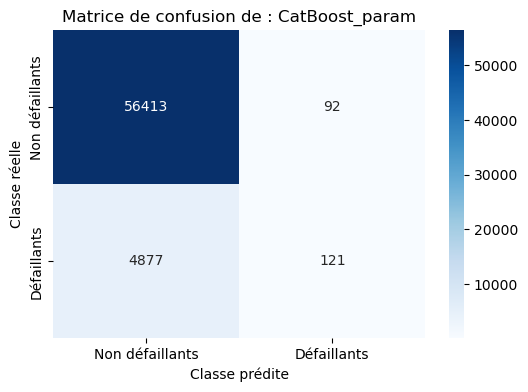

In [42]:
for x in range(len(model_param)):
    df_resultats, result_table, recall_table = outils_model.process_classification(model_param[x], X_train, X_test, y_train, 
                                                                                   y_test, df_resultats, titre_param[x], 
                                                                                   result_table, recall_table)

In [45]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('Dummy_param', 4549, 4568, 449, 51937, df_taux)

In [46]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('LGBM_param', 1855, 14354, 3143, 42151, df_taux)

In [47]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('XGBC_param', 1928, 14220, 3070, 42285, df_taux)

In [48]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('AdaBoost_param', 4964, 30, 34, 56475, df_taux)

In [49]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('LogisticRegressor_param', 1697, 18729, 3301, 37776, df_taux)

In [50]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('RandomForest_param', 1747, 17020, 3251, 39485, df_taux)

In [51]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('CatBoost_param', 4877, 92, 121, 56413, df_taux)

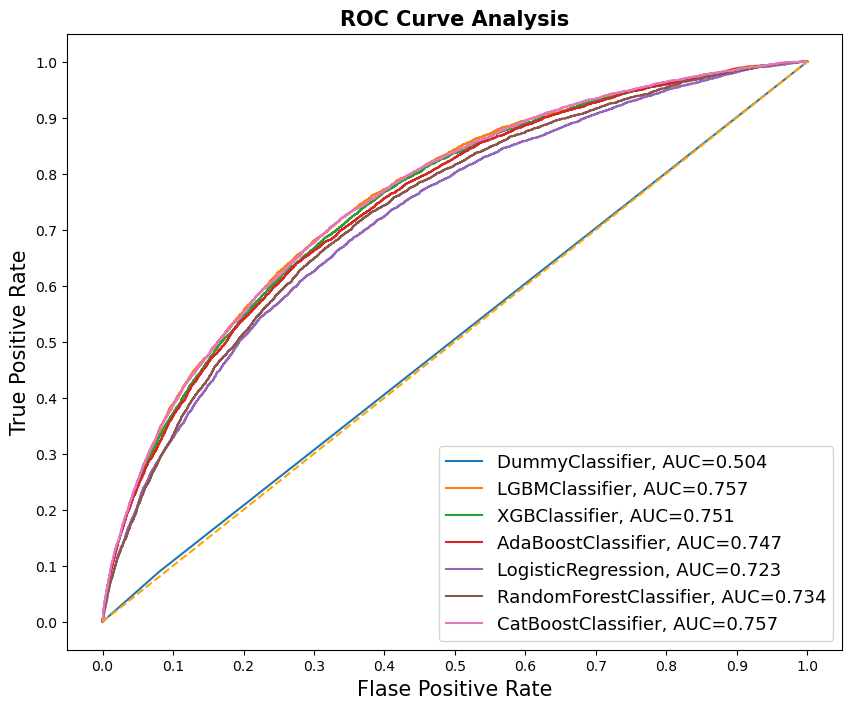

In [43]:
outils_model.roc_plot(result_table.iloc[7:,:])

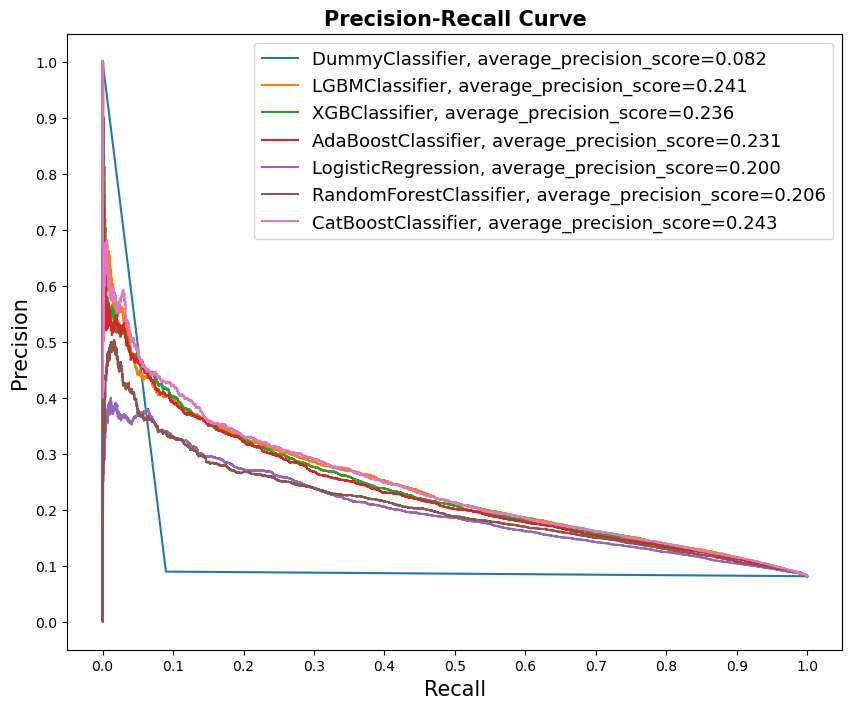

In [44]:
outils_model.avg_plot(recall_table.iloc[7:,:])

- Dummy :
    - Modèle trop simpliste, ne permettant pas de cerner notre problématique et d'avoir une classification efficace.
    
- LGBM & CatBoost :
    - Modèle ayant le meilleur score ROC AUC, avec un temps d'execution relativement correct.

- XGBC & AdaBoost & LogisticRegressor & RandomForest: 
    - Modèle ayant un score ROC AUC correct. Temps d'execution pour certains assez longs.
    
- Pour la suite des traitements on va continuer avec les modèles LGBM et CatBoost

Dummy_param
Score F10 maximal : 0.08983255318263847
Seuil maximal : 0.0
-----------------------------------------------------------


LGBM_param
Score F10 maximal : 0.9001198262519349
Seuil maximal : 0.04
-----------------------------------------------------------


XGBC_param
Score F10 maximal : 0.900883748178207
Seuil maximal : 0.07
-----------------------------------------------------------


AdaBoost_param
Score F10 maximal : 0.8996000969461949
Seuil maximal : 0.47000000000000003
-----------------------------------------------------------


LogisticRegressor_param
Score F10 maximal : 0.8997319503421511
Seuil maximal : 0.14
-----------------------------------------------------------


RandomForest_param
Score F10 maximal : 0.9004098375299694
Seuil maximal : 0.27
-----------------------------------------------------------


CatBoost_param
Score F10 maximal : 0.9007387482004622
Seuil maximal : 0.01
-----------------------------------------------------------




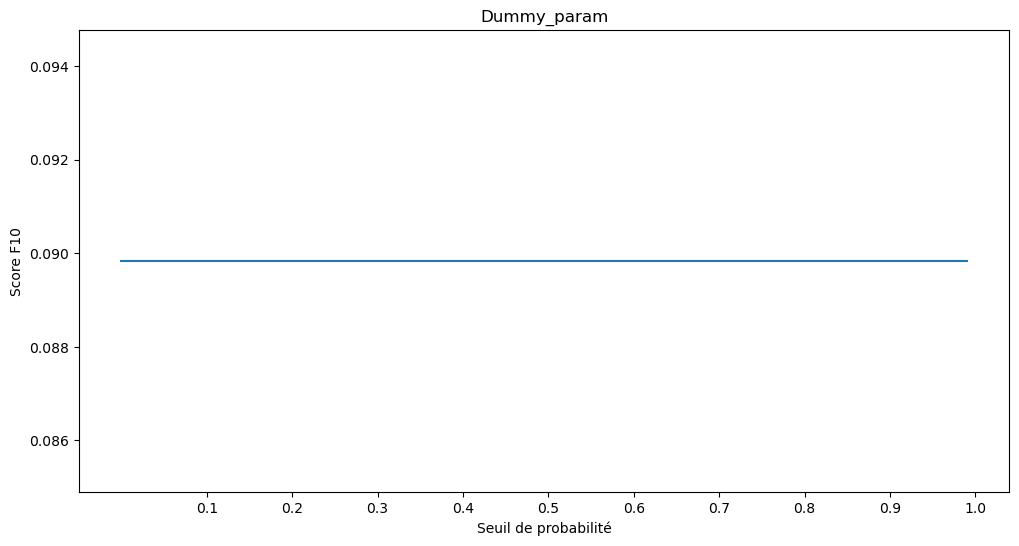

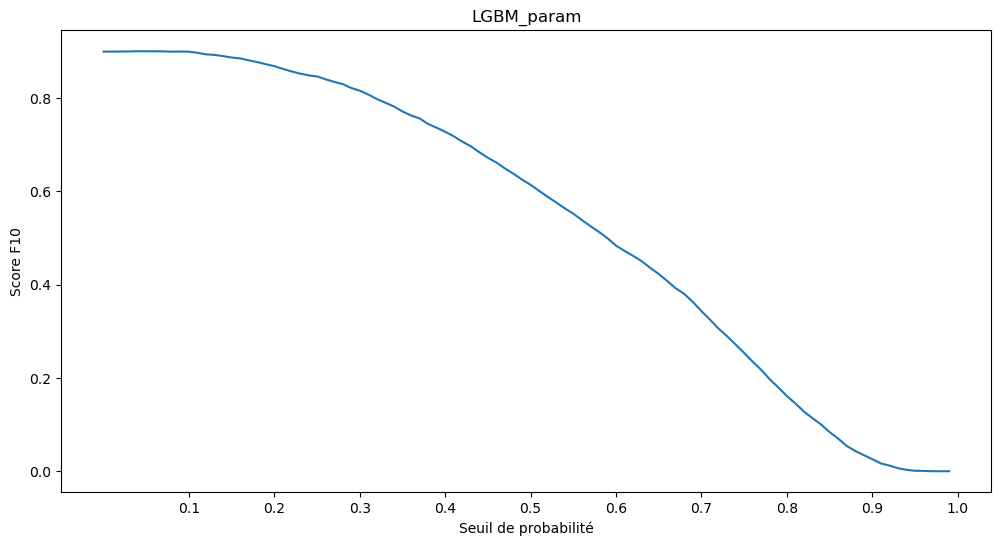

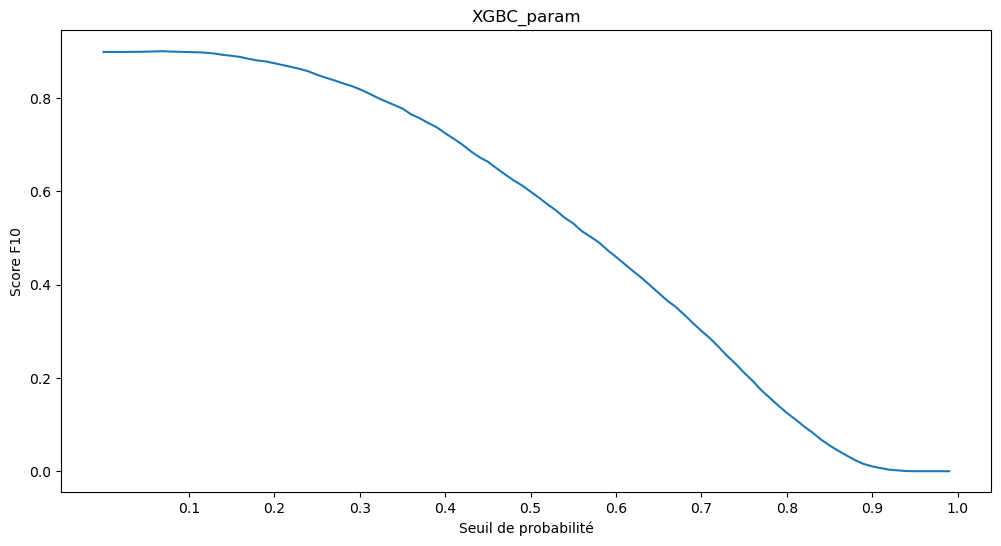

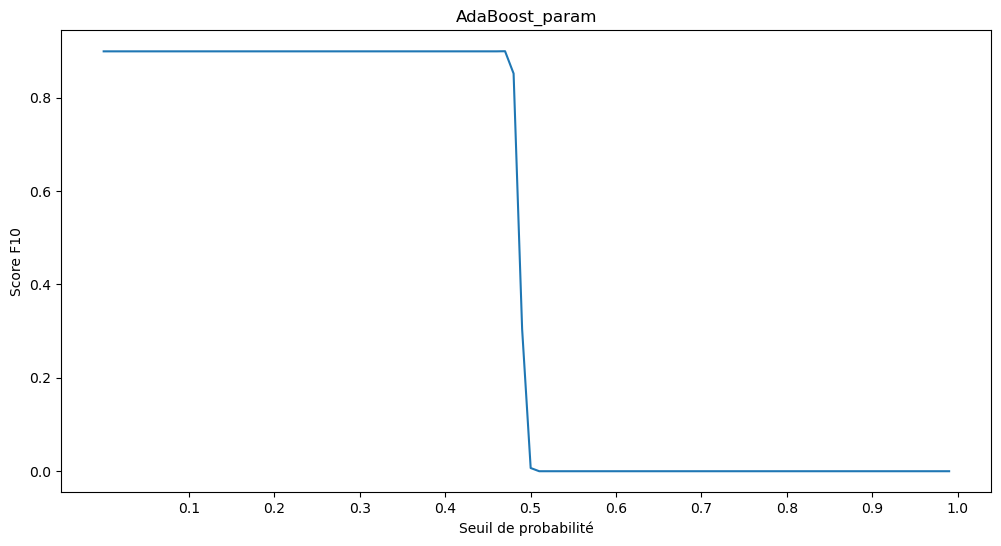

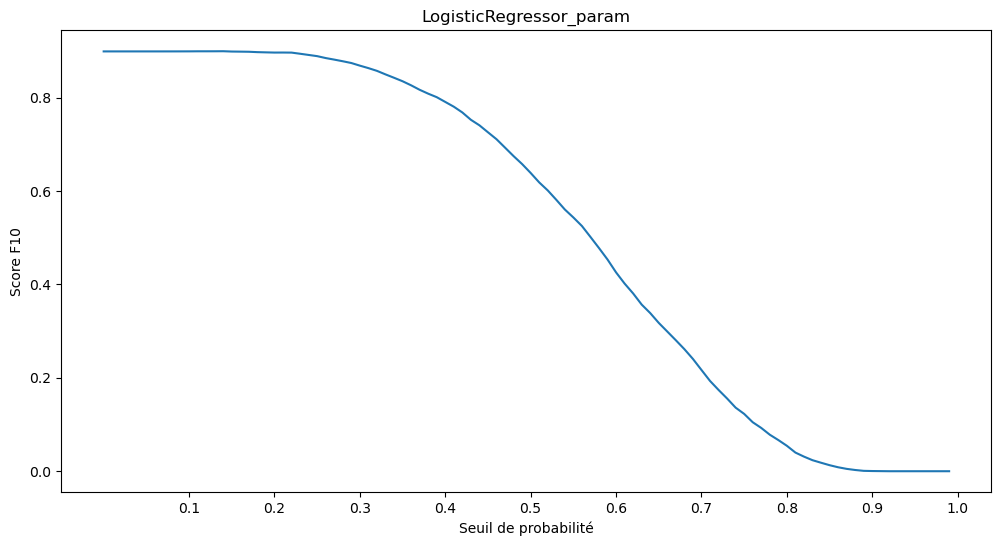

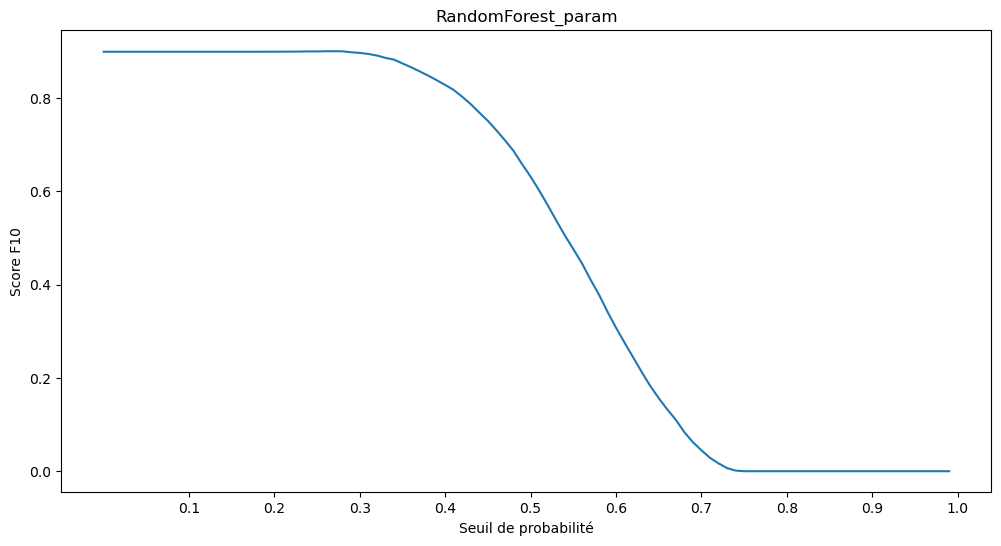

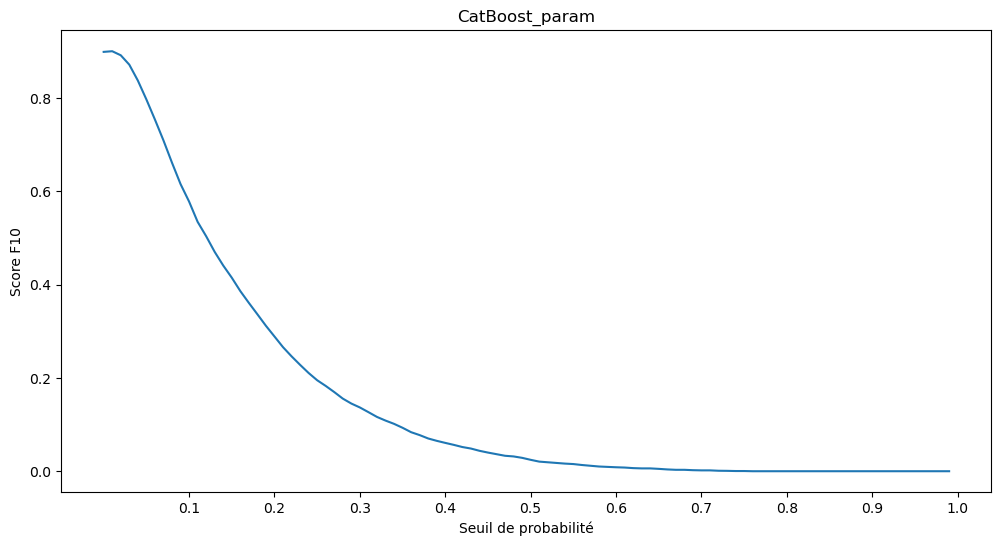

In [52]:
for x in range(len(model_simple)):
    outils_model.determiner_seuil_probabilite_F10(model_param[x], X_test, y_test, titre_param[x], n=1)

#### on remarque une amélioration des fbeta score grace au parametre (hyperparametre) de poids qui contre balance le déséquilibre des classes lors de la prédiction. Malgré cela, on remarque encore un nombre significatif de faux négatif (prédiction = 0). Sachant que 10 FN vaut 1 FP, on va entrainer nos modèles sur des données modifiés pour gérer le déséquilibre. Attention tout de même à ce que l'entrainement ne créer pas d'overfitting
#### Voyons si l'on peut améliorer d'autant plus les prédictions avec un entrainement sur un dataset modifié (over/under sampling)

### Over Sampling

In [53]:
import imblearn
from imblearn.over_sampling import SMOTE

print(Counter(y_train))
oversample = SMOTE(sampling_strategy=0.2, random_state=100)
X_over, y_over = oversample.fit_resample(X_train, y_train)
print(Counter(y_over))

Counter({0: 226181, 1: 19827})
Counter({0: 226181, 1: 45236})


<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
LGBM Classifer</h3></center>
</div>

In [54]:
# Value of hyperparameters for random search

#over_lgb = {'learning_rate':[0.2,0.1,0.01,0.05,0.001],
#              'num_leaves':range(10,100,10),
#              'min_child_samples':range(500,1000,100),
#              'reg_alpha':[0.1,0.01,0.2,0.3],
#              'reg_lambda':[0.1,0.01,0.2,0.3],
#              'n_estimators':range(50,300,50),
#              'max_bin': range(500,1500,100),
#              'class_weight' : ['balanced','is_unbalanced','scale_pos_weight']}

#RndSrch_Tune(LGBMClassifier(random_state = 100, n_jobs=-1), X_over, y_over, over_lgb)

best score is : 0.8915202264885341
best estimator is : LGBMClassifier(class_weight='balanced', max_bin=1000, min_child_samples=700,
               n_estimators=250, num_leaves=50, random_state=100, reg_alpha=0.2,
               reg_lambda=0.1)
best Params is : {'reg_lambda': 0.1, 'reg_alpha': 0.2, 'num_leaves': 50, 'n_estimators': 250, 'min_child_samples': 700, 'max_bin': 1000, 'learning_rate': 0.1, 'class_weight': 'balanced'}


0.8915202264885341

In [62]:
lgb_over = LGBMClassifier(**{'reg_lambda': 0.1, 
                                'reg_alpha': 0.2, 
                                'num_leaves': 50, 
                                'n_estimators': 250, 
                                'min_child_samples': 700, 
                                'learning_rate': 0.1,
                                'max_bin': 1000,
                                'objective': 'binary',
                                'n_jobs': -1,
                                'class_weight':'balanced',
                                'random_state':100})

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
CatBoostClassifer</h3></center>
</div>

In [55]:
# Value of hyperparameters for random search

#over_cat = {'depth' : [4,5,6,7,8,9,10],
#             'learning_rate':[0.2,0.1,0.01,0.05,0.001],
#             'n_estimators':range(50,300,50)}

#RndSrch_Tune(CatBoostClassifier(random_state = 100), X_over, y_over, over_cat)

0:	learn: 0.5569930	total: 62.4ms	remaining: 15.5s
1:	learn: 0.4676634	total: 126ms	remaining: 15.6s
2:	learn: 0.4251143	total: 179ms	remaining: 14.8s
3:	learn: 0.3810883	total: 243ms	remaining: 15s
4:	learn: 0.3628916	total: 301ms	remaining: 14.8s
5:	learn: 0.3496028	total: 360ms	remaining: 14.6s
6:	learn: 0.3416103	total: 423ms	remaining: 14.7s
7:	learn: 0.3352778	total: 489ms	remaining: 14.8s
8:	learn: 0.3158727	total: 556ms	remaining: 14.9s
9:	learn: 0.3119278	total: 610ms	remaining: 14.6s
10:	learn: 0.3086692	total: 667ms	remaining: 14.5s
11:	learn: 0.3059744	total: 730ms	remaining: 14.5s
12:	learn: 0.3018305	total: 791ms	remaining: 14.4s
13:	learn: 0.2997095	total: 852ms	remaining: 14.4s
14:	learn: 0.2954464	total: 906ms	remaining: 14.2s
15:	learn: 0.2880244	total: 965ms	remaining: 14.1s
16:	learn: 0.2860497	total: 1.02s	remaining: 13.9s
17:	learn: 0.2850298	total: 1.07s	remaining: 13.7s
18:	learn: 0.2730742	total: 1.13s	remaining: 13.7s
19:	learn: 0.2691399	total: 1.19s	remainin

161:	learn: 0.2271260	total: 7.78s	remaining: 4.22s
162:	learn: 0.2270405	total: 7.82s	remaining: 4.17s
163:	learn: 0.2269955	total: 7.86s	remaining: 4.12s
164:	learn: 0.2269527	total: 7.9s	remaining: 4.07s
165:	learn: 0.2269061	total: 7.93s	remaining: 4.01s
166:	learn: 0.2267722	total: 7.97s	remaining: 3.96s
167:	learn: 0.2265905	total: 8.01s	remaining: 3.91s
168:	learn: 0.2265502	total: 8.05s	remaining: 3.86s
169:	learn: 0.2264950	total: 8.09s	remaining: 3.81s
170:	learn: 0.2264359	total: 8.13s	remaining: 3.75s
171:	learn: 0.2263977	total: 8.16s	remaining: 3.7s
172:	learn: 0.2263501	total: 8.2s	remaining: 3.65s
173:	learn: 0.2261092	total: 8.24s	remaining: 3.6s
174:	learn: 0.2260662	total: 8.28s	remaining: 3.55s
175:	learn: 0.2260075	total: 8.31s	remaining: 3.5s
176:	learn: 0.2259555	total: 8.36s	remaining: 3.45s
177:	learn: 0.2259017	total: 8.39s	remaining: 3.4s
178:	learn: 0.2258576	total: 8.43s	remaining: 3.34s
179:	learn: 0.2258090	total: 8.47s	remaining: 3.29s
180:	learn: 0.2257

0.8902696655268262

In [63]:
cat_over = CatBoostClassifier(learning_rate = 0.2,
                         n_estimators=150,
                         depth = 5,
                         random_state = 100)

#### On peut déjà voir que le roc auc à augmenter, un peu trop. Cela ressemble plus à de l'overfitting

In [64]:
model_over = [lgb_over, cat_over]
titre_over = ['LGBM_over', 'CatBoost_over']

Successfully registered model 'LGBM_over'.
2023/04/18 03:21:40 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LGBM_over, version 1
Created version '1' of model 'LGBM_over'.


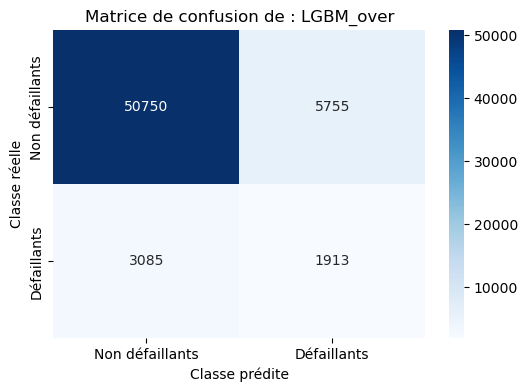

0:	learn: 0.5569930	total: 32.5ms	remaining: 4.84s
1:	learn: 0.4676634	total: 64.7ms	remaining: 4.79s
2:	learn: 0.4251143	total: 94.3ms	remaining: 4.62s
3:	learn: 0.3810883	total: 127ms	remaining: 4.64s
4:	learn: 0.3628916	total: 156ms	remaining: 4.53s
5:	learn: 0.3496028	total: 188ms	remaining: 4.51s
6:	learn: 0.3416103	total: 218ms	remaining: 4.45s
7:	learn: 0.3352778	total: 255ms	remaining: 4.52s
8:	learn: 0.3158727	total: 297ms	remaining: 4.66s
9:	learn: 0.3119278	total: 334ms	remaining: 4.68s
10:	learn: 0.3086692	total: 364ms	remaining: 4.6s
11:	learn: 0.3059744	total: 397ms	remaining: 4.56s
12:	learn: 0.3018305	total: 429ms	remaining: 4.52s
13:	learn: 0.2997095	total: 463ms	remaining: 4.5s
14:	learn: 0.2954464	total: 502ms	remaining: 4.52s
15:	learn: 0.2880244	total: 543ms	remaining: 4.55s
16:	learn: 0.2860497	total: 575ms	remaining: 4.5s
17:	learn: 0.2850298	total: 606ms	remaining: 4.44s
18:	learn: 0.2730742	total: 641ms	remaining: 4.42s
19:	learn: 0.2691399	total: 680ms	remaini

15:	learn: 0.2697342	total: 494ms	remaining: 4.14s
16:	learn: 0.2681640	total: 528ms	remaining: 4.13s
17:	learn: 0.2637503	total: 560ms	remaining: 4.11s
18:	learn: 0.2625683	total: 591ms	remaining: 4.07s
19:	learn: 0.2617814	total: 622ms	remaining: 4.04s
20:	learn: 0.2610315	total: 651ms	remaining: 4s
21:	learn: 0.2604268	total: 681ms	remaining: 3.96s
22:	learn: 0.2597039	total: 717ms	remaining: 3.96s
23:	learn: 0.2589124	total: 754ms	remaining: 3.96s
24:	learn: 0.2557288	total: 787ms	remaining: 3.93s
25:	learn: 0.2550294	total: 819ms	remaining: 3.91s
26:	learn: 0.2478439	total: 855ms	remaining: 3.9s
27:	learn: 0.2457172	total: 886ms	remaining: 3.86s
28:	learn: 0.2452638	total: 913ms	remaining: 3.81s
29:	learn: 0.2447612	total: 951ms	remaining: 3.8s
30:	learn: 0.2409667	total: 982ms	remaining: 3.77s
31:	learn: 0.2378141	total: 1.02s	remaining: 3.77s
32:	learn: 0.2361857	total: 1.06s	remaining: 3.78s
33:	learn: 0.2358860	total: 1.1s	remaining: 3.75s
34:	learn: 0.2356387	total: 1.14s	rem

28:	learn: 0.2346111	total: 1.18s	remaining: 4.94s
29:	learn: 0.2341901	total: 1.23s	remaining: 4.92s
30:	learn: 0.2339748	total: 1.27s	remaining: 4.88s
31:	learn: 0.2315462	total: 1.31s	remaining: 4.85s
32:	learn: 0.2308060	total: 1.36s	remaining: 4.81s
33:	learn: 0.2304992	total: 1.39s	remaining: 4.75s
34:	learn: 0.2299320	total: 1.44s	remaining: 4.72s
35:	learn: 0.2295513	total: 1.47s	remaining: 4.67s
36:	learn: 0.2293508	total: 1.52s	remaining: 4.64s
37:	learn: 0.2287252	total: 1.56s	remaining: 4.6s
38:	learn: 0.2254762	total: 1.61s	remaining: 4.57s
39:	learn: 0.2253527	total: 1.65s	remaining: 4.54s
40:	learn: 0.2251351	total: 1.7s	remaining: 4.51s
41:	learn: 0.2246691	total: 1.74s	remaining: 4.46s
42:	learn: 0.2237931	total: 1.77s	remaining: 4.41s
43:	learn: 0.2236798	total: 1.81s	remaining: 4.37s
44:	learn: 0.2234671	total: 1.85s	remaining: 4.32s
45:	learn: 0.2216795	total: 1.9s	remaining: 4.29s
46:	learn: 0.2215034	total: 1.93s	remaining: 4.24s
47:	learn: 0.2211766	total: 1.97s	

45:	learn: 0.2238936	total: 1.58s	remaining: 3.58s
46:	learn: 0.2237258	total: 1.62s	remaining: 3.54s
47:	learn: 0.2236003	total: 1.65s	remaining: 3.5s
48:	learn: 0.2234675	total: 1.69s	remaining: 3.48s
49:	learn: 0.2217178	total: 1.73s	remaining: 3.45s
50:	learn: 0.2210610	total: 1.76s	remaining: 3.42s
51:	learn: 0.2202257	total: 1.79s	remaining: 3.38s
52:	learn: 0.2191390	total: 1.83s	remaining: 3.35s
53:	learn: 0.2190497	total: 1.86s	remaining: 3.31s
54:	learn: 0.2187619	total: 1.89s	remaining: 3.27s
55:	learn: 0.2186220	total: 1.93s	remaining: 3.23s
56:	learn: 0.2184832	total: 1.96s	remaining: 3.2s
57:	learn: 0.2183012	total: 2s	remaining: 3.17s
58:	learn: 0.2182202	total: 2.04s	remaining: 3.15s
59:	learn: 0.2181306	total: 2.08s	remaining: 3.11s
60:	learn: 0.2179159	total: 2.11s	remaining: 3.08s
61:	learn: 0.2178017	total: 2.14s	remaining: 3.04s
62:	learn: 0.2173851	total: 2.17s	remaining: 3s
63:	learn: 0.2172245	total: 2.21s	remaining: 2.97s
64:	learn: 0.2170918	total: 2.24s	remai

58:	learn: 0.2179466	total: 2.05s	remaining: 3.16s
59:	learn: 0.2178835	total: 2.09s	remaining: 3.13s
60:	learn: 0.2177664	total: 2.12s	remaining: 3.09s
61:	learn: 0.2176708	total: 2.15s	remaining: 3.05s
62:	learn: 0.2175569	total: 2.18s	remaining: 3.02s
63:	learn: 0.2174201	total: 2.22s	remaining: 2.99s
64:	learn: 0.2173481	total: 2.25s	remaining: 2.95s
65:	learn: 0.2172203	total: 2.3s	remaining: 2.92s
66:	learn: 0.2171240	total: 2.34s	remaining: 2.9s
67:	learn: 0.2163014	total: 2.38s	remaining: 2.88s
68:	learn: 0.2157437	total: 2.43s	remaining: 2.85s
69:	learn: 0.2152246	total: 2.47s	remaining: 2.83s
70:	learn: 0.2151197	total: 2.52s	remaining: 2.8s
71:	learn: 0.2146142	total: 2.56s	remaining: 2.77s
72:	learn: 0.2144882	total: 2.6s	remaining: 2.75s
73:	learn: 0.2143663	total: 2.65s	remaining: 2.72s
74:	learn: 0.2142804	total: 2.68s	remaining: 2.68s
75:	learn: 0.2141911	total: 2.73s	remaining: 2.65s
76:	learn: 0.2139825	total: 2.77s	remaining: 2.62s
77:	learn: 0.2134882	total: 2.81s	r

70:	learn: 0.2391094	total: 2.73s	remaining: 3.04s
71:	learn: 0.2390201	total: 2.77s	remaining: 3.01s
72:	learn: 0.2388814	total: 2.81s	remaining: 2.96s
73:	learn: 0.2387827	total: 2.84s	remaining: 2.92s
74:	learn: 0.2380723	total: 2.88s	remaining: 2.88s
75:	learn: 0.2374598	total: 2.91s	remaining: 2.84s
76:	learn: 0.2372739	total: 2.95s	remaining: 2.79s
77:	learn: 0.2368517	total: 2.98s	remaining: 2.75s
78:	learn: 0.2367439	total: 3.02s	remaining: 2.71s
79:	learn: 0.2366343	total: 3.05s	remaining: 2.67s
80:	learn: 0.2365413	total: 3.09s	remaining: 2.63s
81:	learn: 0.2364512	total: 3.12s	remaining: 2.59s
82:	learn: 0.2363613	total: 3.15s	remaining: 2.54s
83:	learn: 0.2362512	total: 3.19s	remaining: 2.51s
84:	learn: 0.2361818	total: 3.22s	remaining: 2.46s
85:	learn: 0.2361007	total: 3.25s	remaining: 2.42s
86:	learn: 0.2359619	total: 3.29s	remaining: 2.38s
87:	learn: 0.2358881	total: 3.32s	remaining: 2.34s
88:	learn: 0.2358175	total: 3.36s	remaining: 2.3s
89:	learn: 0.2357241	total: 3.4s

81:	learn: 0.2518744	total: 2.74s	remaining: 2.27s
82:	learn: 0.2517998	total: 2.77s	remaining: 2.24s
83:	learn: 0.2516759	total: 2.81s	remaining: 2.2s
84:	learn: 0.2515190	total: 2.84s	remaining: 2.17s
85:	learn: 0.2510169	total: 2.88s	remaining: 2.14s
86:	learn: 0.2509411	total: 2.91s	remaining: 2.11s
87:	learn: 0.2507078	total: 2.95s	remaining: 2.08s
88:	learn: 0.2502723	total: 2.98s	remaining: 2.04s
89:	learn: 0.2502062	total: 3.01s	remaining: 2.01s
90:	learn: 0.2501099	total: 3.04s	remaining: 1.97s
91:	learn: 0.2500295	total: 3.08s	remaining: 1.94s
92:	learn: 0.2499210	total: 3.1s	remaining: 1.9s
93:	learn: 0.2498506	total: 3.14s	remaining: 1.87s
94:	learn: 0.2497654	total: 3.17s	remaining: 1.84s
95:	learn: 0.2496293	total: 3.21s	remaining: 1.8s
96:	learn: 0.2495430	total: 3.24s	remaining: 1.77s
97:	learn: 0.2494463	total: 3.27s	remaining: 1.74s
98:	learn: 0.2493537	total: 3.31s	remaining: 1.7s
99:	learn: 0.2491807	total: 3.34s	remaining: 1.67s
100:	learn: 0.2491045	total: 3.38s	r

93:	learn: 0.2497815	total: 3.74s	remaining: 2.23s
94:	learn: 0.2497092	total: 3.78s	remaining: 2.19s
95:	learn: 0.2496395	total: 3.82s	remaining: 2.15s
96:	learn: 0.2495286	total: 3.86s	remaining: 2.11s
97:	learn: 0.2494526	total: 3.9s	remaining: 2.07s
98:	learn: 0.2493726	total: 3.94s	remaining: 2.03s
99:	learn: 0.2492768	total: 3.98s	remaining: 1.99s
100:	learn: 0.2492217	total: 4.02s	remaining: 1.95s
101:	learn: 0.2491668	total: 4.05s	remaining: 1.91s
102:	learn: 0.2491103	total: 4.09s	remaining: 1.87s
103:	learn: 0.2489267	total: 4.13s	remaining: 1.83s
104:	learn: 0.2486777	total: 4.17s	remaining: 1.79s
105:	learn: 0.2484368	total: 4.22s	remaining: 1.75s
106:	learn: 0.2483744	total: 4.25s	remaining: 1.71s
107:	learn: 0.2483188	total: 4.29s	remaining: 1.67s
108:	learn: 0.2482405	total: 4.32s	remaining: 1.63s
109:	learn: 0.2478078	total: 4.36s	remaining: 1.58s
110:	learn: 0.2477443	total: 4.39s	remaining: 1.54s
111:	learn: 0.2476391	total: 4.43s	remaining: 1.5s
112:	learn: 0.2474744

110:	learn: 0.2485223	total: 3.67s	remaining: 1.29s
111:	learn: 0.2484591	total: 3.71s	remaining: 1.26s
112:	learn: 0.2483976	total: 3.74s	remaining: 1.23s
113:	learn: 0.2483388	total: 3.77s	remaining: 1.19s
114:	learn: 0.2479646	total: 3.81s	remaining: 1.16s
115:	learn: 0.2479083	total: 3.84s	remaining: 1.13s
116:	learn: 0.2476550	total: 3.87s	remaining: 1.09s
117:	learn: 0.2475810	total: 3.91s	remaining: 1.06s
118:	learn: 0.2475064	total: 3.94s	remaining: 1.03s
119:	learn: 0.2474633	total: 3.97s	remaining: 993ms
120:	learn: 0.2473944	total: 4s	remaining: 959ms
121:	learn: 0.2473323	total: 4.03s	remaining: 925ms
122:	learn: 0.2472829	total: 4.06s	remaining: 892ms
123:	learn: 0.2472178	total: 4.09s	remaining: 859ms
124:	learn: 0.2471595	total: 4.13s	remaining: 827ms
125:	learn: 0.2470947	total: 4.17s	remaining: 794ms
126:	learn: 0.2470544	total: 4.2s	remaining: 760ms
127:	learn: 0.2469942	total: 4.23s	remaining: 727ms
128:	learn: 0.2469284	total: 4.26s	remaining: 694ms
129:	learn: 0.24

123:	learn: 0.2469588	total: 4.37s	remaining: 916ms
124:	learn: 0.2468981	total: 4.41s	remaining: 883ms
125:	learn: 0.2468394	total: 4.46s	remaining: 849ms
126:	learn: 0.2467563	total: 4.49s	remaining: 814ms
127:	learn: 0.2466927	total: 4.53s	remaining: 778ms
128:	learn: 0.2466474	total: 4.56s	remaining: 743ms
129:	learn: 0.2465757	total: 4.6s	remaining: 708ms
130:	learn: 0.2462771	total: 4.64s	remaining: 673ms
131:	learn: 0.2461697	total: 4.67s	remaining: 637ms
132:	learn: 0.2461017	total: 4.71s	remaining: 603ms
133:	learn: 0.2457701	total: 4.75s	remaining: 567ms
134:	learn: 0.2456960	total: 4.79s	remaining: 532ms
135:	learn: 0.2456414	total: 4.83s	remaining: 497ms
136:	learn: 0.2453484	total: 4.87s	remaining: 462ms
137:	learn: 0.2452748	total: 4.91s	remaining: 427ms
138:	learn: 0.2451984	total: 4.96s	remaining: 392ms
139:	learn: 0.2451325	total: 4.99s	remaining: 357ms
140:	learn: 0.2450814	total: 5.03s	remaining: 321ms
141:	learn: 0.2450349	total: 5.07s	remaining: 286ms
142:	learn: 0

137:	learn: 0.2463290	total: 4.84s	remaining: 421ms
138:	learn: 0.2462837	total: 4.87s	remaining: 385ms
139:	learn: 0.2459665	total: 4.91s	remaining: 351ms
140:	learn: 0.2459142	total: 4.94s	remaining: 315ms
141:	learn: 0.2458410	total: 4.97s	remaining: 280ms
142:	learn: 0.2457806	total: 5s	remaining: 245ms
143:	learn: 0.2456867	total: 5.04s	remaining: 210ms
144:	learn: 0.2456438	total: 5.07s	remaining: 175ms
145:	learn: 0.2455896	total: 5.11s	remaining: 140ms
146:	learn: 0.2453104	total: 5.14s	remaining: 105ms
147:	learn: 0.2451539	total: 5.17s	remaining: 69.9ms
148:	learn: 0.2450857	total: 5.21s	remaining: 34.9ms
149:	learn: 0.2450376	total: 5.24s	remaining: 0us


Successfully registered model 'CatBoost_over'.
2023/04/18 03:22:51 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CatBoost_over, version 1
Created version '1' of model 'CatBoost_over'.


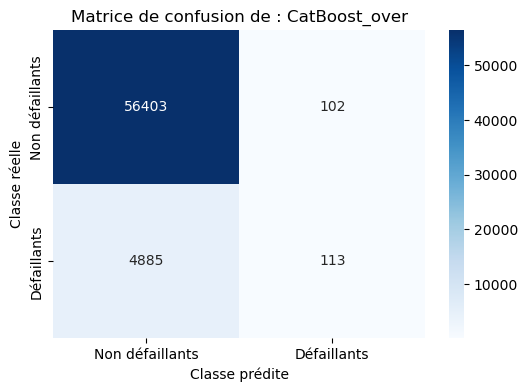

In [65]:
for x in range(len(model_over)):
    df_resultats, result_table, recall_table = outils_model.process_classification(model_over[x], X_over, X_test, y_over, 
                                                                                   y_test, df_resultats, titre_over[x], 
                                                                                   result_table, recall_table)

In [75]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('LGBM_over', 3085, 5755, 1913, 50750, df_taux)

In [76]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('CatBoost_over', 4885, 102, 113, 56403, df_taux)

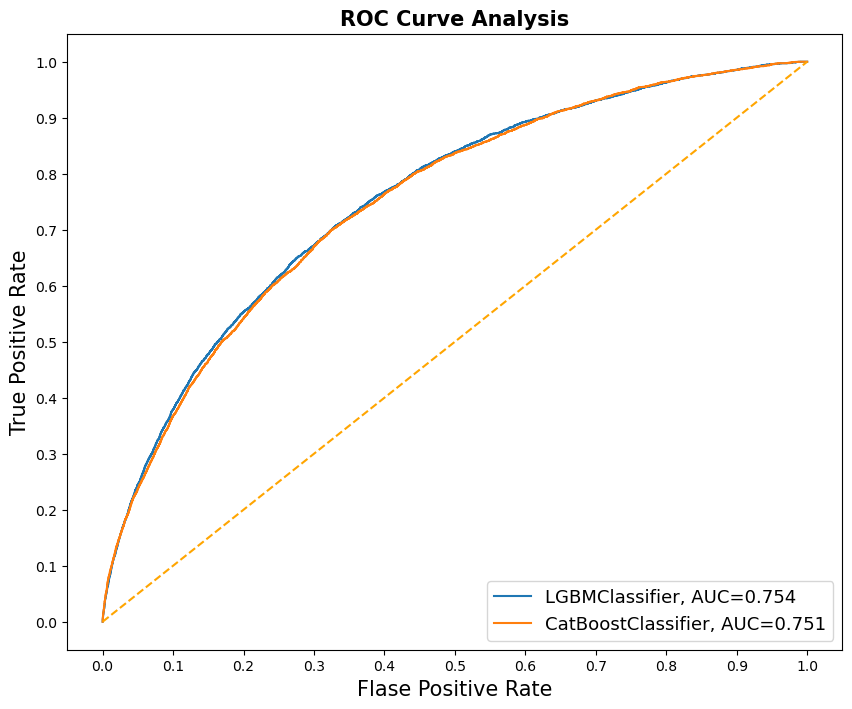

In [66]:
outils_model.roc_plot(result_table.iloc[14:,:])

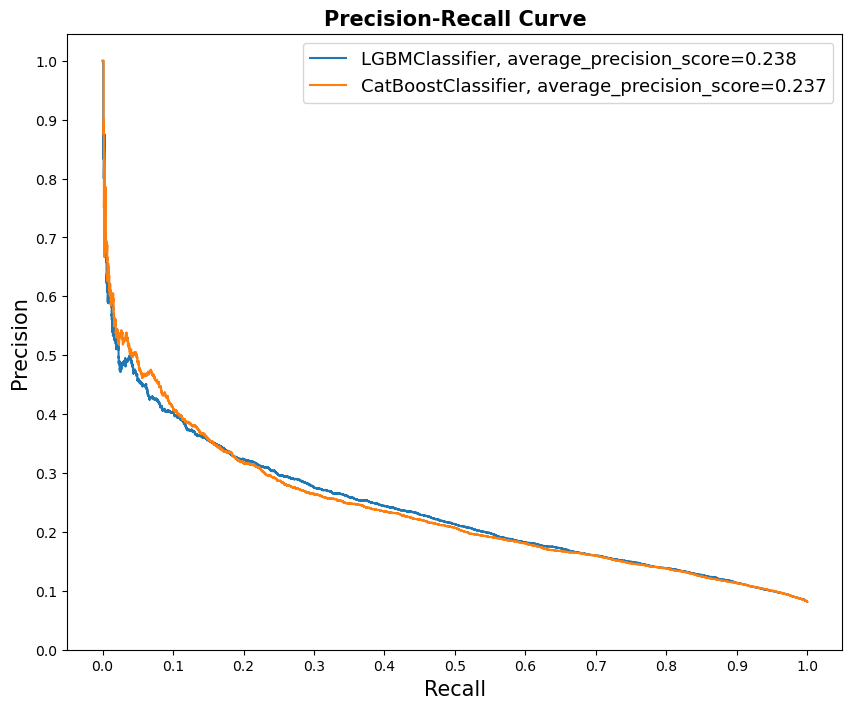

In [67]:
outils_model.avg_plot(recall_table.iloc[14:,:])

### Under Sampling

In [56]:
from imblearn.under_sampling import RandomUnderSampler

print(Counter(y_train))
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=100)
X_under, y_under = undersample.fit_resample(X_train, y_train)
print(Counter(y_under))

Counter({0: 226181, 1: 19827})
Counter({0: 19827, 1: 19827})


<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
LGBM Classifer</h3></center>
</div>

In [57]:
# Value of hyperparameters for random search

#under_lgb = {'learning_rate':[0.2,0.1,0.01,0.05,0.001],
#              'num_leaves':range(10,100,10),
#              'min_child_samples':range(500,1000,100),
#              'reg_alpha':[0.1,0.01,0.2,0.3],
#              'reg_lambda':[0.1,0.01,0.2,0.3],
#              'n_estimators':range(50,300,50),
#              'max_bin': range(500,1500,100),
#              'class_weight' : ['balanced','is_unbalanced','scale_pos_weight']}

#RndSrch_Tune(LGBMClassifier(random_state = 100, n_jobs=-1), X_under, y_under, under_lgb)

best score is : 0.7548995638644749
best estimator is : LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_bin=500,
               min_child_samples=600, n_estimators=250, num_leaves=10,
               random_state=100, reg_alpha=0.1, reg_lambda=0.1)
best Params is : {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'num_leaves': 10, 'n_estimators': 250, 'min_child_samples': 600, 'max_bin': 500, 'learning_rate': 0.05, 'class_weight': 'balanced'}


0.7548995638644749

In [68]:
lgb_under = LGBMClassifier(**{'reg_lambda': 0.1, 
                                'reg_alpha': 0.1, 
                                'num_leaves': 10, 
                                'n_estimators': 250, 
                                'min_child_samples': 600, 
                                'learning_rate': 0.05,
                                'max_bin': 500,
                                'objective': 'binary',
                                'n_jobs': -1,
                                'class_weight':'balanced',
                                'random_state':100})

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
CatBoost</h3></center>
</div>

In [58]:
# Value of hyperparameters for random search

#under_cat = {'depth' : [4,5,6,7,8,9,10],
#             'learning_rate':[0.2,0.1,0.01,0.05,0.001],
#             'n_estimators':range(50,300,50)}

#RndSrch_Tune(CatBoostClassifier(random_state = 100), X_under, y_under, under_cat)

0:	learn: 0.6802542	total: 18.4ms	remaining: 4.58s
1:	learn: 0.6685272	total: 39ms	remaining: 4.84s
2:	learn: 0.6591420	total: 60.8ms	remaining: 5s
3:	learn: 0.6513069	total: 81.2ms	remaining: 4.99s
4:	learn: 0.6447805	total: 101ms	remaining: 4.94s
5:	learn: 0.6398538	total: 123ms	remaining: 4.99s
6:	learn: 0.6348868	total: 143ms	remaining: 4.97s
7:	learn: 0.6307179	total: 162ms	remaining: 4.9s
8:	learn: 0.6269399	total: 181ms	remaining: 4.84s
9:	learn: 0.6239270	total: 201ms	remaining: 4.82s
10:	learn: 0.6209852	total: 222ms	remaining: 4.83s
11:	learn: 0.6189284	total: 248ms	remaining: 4.91s
12:	learn: 0.6164237	total: 271ms	remaining: 4.93s
13:	learn: 0.6144955	total: 296ms	remaining: 5s
14:	learn: 0.6127776	total: 316ms	remaining: 4.96s
15:	learn: 0.6108688	total: 336ms	remaining: 4.91s
16:	learn: 0.6092991	total: 357ms	remaining: 4.89s
17:	learn: 0.6078650	total: 377ms	remaining: 4.86s
18:	learn: 0.6067077	total: 400ms	remaining: 4.86s
19:	learn: 0.6055884	total: 422ms	remaining: 4

165:	learn: 0.5591243	total: 3.22s	remaining: 1.63s
166:	learn: 0.5588895	total: 3.24s	remaining: 1.61s
167:	learn: 0.5586006	total: 3.27s	remaining: 1.59s
168:	learn: 0.5583629	total: 3.29s	remaining: 1.57s
169:	learn: 0.5581232	total: 3.31s	remaining: 1.55s
170:	learn: 0.5578566	total: 3.33s	remaining: 1.54s
171:	learn: 0.5576698	total: 3.34s	remaining: 1.52s
172:	learn: 0.5574617	total: 3.36s	remaining: 1.5s
173:	learn: 0.5572113	total: 3.38s	remaining: 1.48s
174:	learn: 0.5569480	total: 3.4s	remaining: 1.46s
175:	learn: 0.5566989	total: 3.42s	remaining: 1.44s
176:	learn: 0.5564683	total: 3.45s	remaining: 1.42s
177:	learn: 0.5562329	total: 3.47s	remaining: 1.4s
178:	learn: 0.5560295	total: 3.48s	remaining: 1.38s
179:	learn: 0.5557872	total: 3.5s	remaining: 1.36s
180:	learn: 0.5555851	total: 3.52s	remaining: 1.34s
181:	learn: 0.5553460	total: 3.54s	remaining: 1.32s
182:	learn: 0.5550917	total: 3.55s	remaining: 1.3s
183:	learn: 0.5548159	total: 3.57s	remaining: 1.28s
184:	learn: 0.554

0.7544250137144517

In [69]:
cat_under = CatBoostClassifier(learning_rate = 0.1,
                         n_estimators=250,
                         depth = 6,
                         random_state = 100)

In [70]:
model_under = [lgb_under, cat_under]
titre_under = ['LGBM_under', 'CatBoost_under']

Successfully registered model 'LGBM_under'.
2023/04/18 03:23:09 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LGBM_under, version 1
Created version '1' of model 'LGBM_under'.


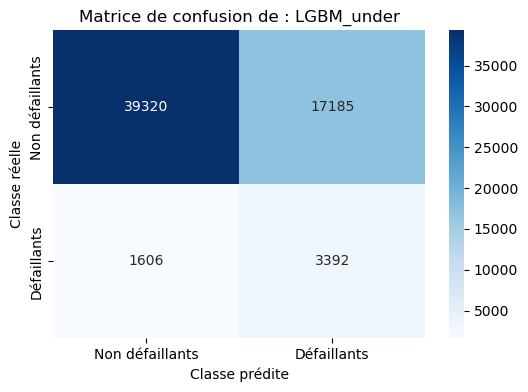

0:	learn: 0.6802542	total: 10.2ms	remaining: 2.55s
1:	learn: 0.6685272	total: 21ms	remaining: 2.61s
2:	learn: 0.6591420	total: 31.9ms	remaining: 2.62s
3:	learn: 0.6513069	total: 42ms	remaining: 2.58s
4:	learn: 0.6447805	total: 51.9ms	remaining: 2.54s
5:	learn: 0.6398538	total: 62.4ms	remaining: 2.54s
6:	learn: 0.6348868	total: 72.7ms	remaining: 2.52s
7:	learn: 0.6307179	total: 82.4ms	remaining: 2.49s
8:	learn: 0.6269399	total: 92ms	remaining: 2.46s
9:	learn: 0.6239270	total: 102ms	remaining: 2.45s
10:	learn: 0.6209852	total: 112ms	remaining: 2.44s
11:	learn: 0.6189284	total: 124ms	remaining: 2.45s
12:	learn: 0.6164237	total: 134ms	remaining: 2.45s
13:	learn: 0.6144955	total: 148ms	remaining: 2.5s
14:	learn: 0.6127776	total: 159ms	remaining: 2.5s
15:	learn: 0.6108688	total: 170ms	remaining: 2.49s
16:	learn: 0.6092991	total: 182ms	remaining: 2.49s
17:	learn: 0.6078650	total: 196ms	remaining: 2.52s
18:	learn: 0.6067077	total: 207ms	remaining: 2.52s
19:	learn: 0.6055884	total: 220ms	remain

170:	learn: 0.5578566	total: 2.39s	remaining: 1.1s
171:	learn: 0.5576698	total: 2.41s	remaining: 1.09s
172:	learn: 0.5574617	total: 2.43s	remaining: 1.08s
173:	learn: 0.5572113	total: 2.44s	remaining: 1.07s
174:	learn: 0.5569480	total: 2.46s	remaining: 1.05s
175:	learn: 0.5566989	total: 2.48s	remaining: 1.04s
176:	learn: 0.5564683	total: 2.5s	remaining: 1.03s
177:	learn: 0.5562329	total: 2.52s	remaining: 1.02s
178:	learn: 0.5560295	total: 2.54s	remaining: 1.01s
179:	learn: 0.5557872	total: 2.56s	remaining: 996ms
180:	learn: 0.5555851	total: 2.58s	remaining: 983ms
181:	learn: 0.5553460	total: 2.59s	remaining: 969ms
182:	learn: 0.5550917	total: 2.61s	remaining: 955ms
183:	learn: 0.5548159	total: 2.63s	remaining: 942ms
184:	learn: 0.5546658	total: 2.64s	remaining: 929ms
185:	learn: 0.5544131	total: 2.66s	remaining: 915ms
186:	learn: 0.5541451	total: 2.67s	remaining: 902ms
187:	learn: 0.5538632	total: 2.69s	remaining: 888ms
188:	learn: 0.5536127	total: 2.71s	remaining: 874ms
189:	learn: 0.

88:	learn: 0.5765559	total: 1.51s	remaining: 2.73s
89:	learn: 0.5762777	total: 1.53s	remaining: 2.71s
90:	learn: 0.5760550	total: 1.55s	remaining: 2.7s
91:	learn: 0.5757917	total: 1.57s	remaining: 2.69s
92:	learn: 0.5754438	total: 1.59s	remaining: 2.68s
93:	learn: 0.5751594	total: 1.61s	remaining: 2.67s
94:	learn: 0.5748183	total: 1.62s	remaining: 2.65s
95:	learn: 0.5746010	total: 1.64s	remaining: 2.64s
96:	learn: 0.5743868	total: 1.66s	remaining: 2.62s
97:	learn: 0.5742192	total: 1.68s	remaining: 2.61s
98:	learn: 0.5739301	total: 1.7s	remaining: 2.59s
99:	learn: 0.5737031	total: 1.72s	remaining: 2.58s
100:	learn: 0.5734004	total: 1.74s	remaining: 2.56s
101:	learn: 0.5732009	total: 1.75s	remaining: 2.54s
102:	learn: 0.5729344	total: 1.77s	remaining: 2.53s
103:	learn: 0.5725335	total: 1.79s	remaining: 2.52s
104:	learn: 0.5723349	total: 1.81s	remaining: 2.5s
105:	learn: 0.5719820	total: 1.83s	remaining: 2.49s
106:	learn: 0.5717118	total: 1.85s	remaining: 2.48s
107:	learn: 0.5714017	total

247:	learn: 0.5368738	total: 4.02s	remaining: 32.5ms
248:	learn: 0.5366227	total: 4.04s	remaining: 16.2ms
249:	learn: 0.5364878	total: 4.05s	remaining: 0us
0:	learn: 0.6803840	total: 15.4ms	remaining: 3.84s
1:	learn: 0.6686219	total: 30.8ms	remaining: 3.81s
2:	learn: 0.6593071	total: 45.6ms	remaining: 3.75s
3:	learn: 0.6519287	total: 62.9ms	remaining: 3.87s
4:	learn: 0.6456622	total: 80ms	remaining: 3.92s
5:	learn: 0.6399511	total: 92.1ms	remaining: 3.75s
6:	learn: 0.6353798	total: 106ms	remaining: 3.69s
7:	learn: 0.6310698	total: 121ms	remaining: 3.65s
8:	learn: 0.6275261	total: 134ms	remaining: 3.59s
9:	learn: 0.6245456	total: 149ms	remaining: 3.57s
10:	learn: 0.6220648	total: 163ms	remaining: 3.55s
11:	learn: 0.6194735	total: 179ms	remaining: 3.54s
12:	learn: 0.6174011	total: 191ms	remaining: 3.49s
13:	learn: 0.6152735	total: 203ms	remaining: 3.42s
14:	learn: 0.6134743	total: 216ms	remaining: 3.39s
15:	learn: 0.6114091	total: 230ms	remaining: 3.36s
16:	learn: 0.6098512	total: 243ms	

168:	learn: 0.5552682	total: 2.31s	remaining: 1.11s
169:	learn: 0.5551078	total: 2.33s	remaining: 1.09s
170:	learn: 0.5549018	total: 2.34s	remaining: 1.08s
171:	learn: 0.5546048	total: 2.35s	remaining: 1.07s
172:	learn: 0.5543529	total: 2.37s	remaining: 1.05s
173:	learn: 0.5540020	total: 2.38s	remaining: 1.04s
174:	learn: 0.5537916	total: 2.4s	remaining: 1.03s
175:	learn: 0.5536612	total: 2.41s	remaining: 1.01s
176:	learn: 0.5533859	total: 2.43s	remaining: 1s
177:	learn: 0.5531960	total: 2.44s	remaining: 988ms
178:	learn: 0.5529475	total: 2.46s	remaining: 974ms
179:	learn: 0.5526913	total: 2.47s	remaining: 961ms
180:	learn: 0.5524222	total: 2.48s	remaining: 947ms
181:	learn: 0.5521535	total: 2.5s	remaining: 933ms
182:	learn: 0.5519192	total: 2.51s	remaining: 920ms
183:	learn: 0.5517097	total: 2.52s	remaining: 906ms
184:	learn: 0.5515153	total: 2.54s	remaining: 892ms
185:	learn: 0.5512291	total: 2.55s	remaining: 879ms
186:	learn: 0.5509402	total: 2.57s	remaining: 866ms
187:	learn: 0.550

87:	learn: 0.5776627	total: 1.47s	remaining: 2.7s
88:	learn: 0.5775023	total: 1.48s	remaining: 2.68s
89:	learn: 0.5772589	total: 1.5s	remaining: 2.66s
90:	learn: 0.5770266	total: 1.51s	remaining: 2.65s
91:	learn: 0.5768181	total: 1.53s	remaining: 2.63s
92:	learn: 0.5766274	total: 1.55s	remaining: 2.61s
93:	learn: 0.5763782	total: 1.56s	remaining: 2.59s
94:	learn: 0.5760835	total: 1.57s	remaining: 2.57s
95:	learn: 0.5757700	total: 1.59s	remaining: 2.56s
96:	learn: 0.5754330	total: 1.61s	remaining: 2.54s
97:	learn: 0.5752005	total: 1.62s	remaining: 2.52s
98:	learn: 0.5749298	total: 1.64s	remaining: 2.5s
99:	learn: 0.5745860	total: 1.66s	remaining: 2.49s
100:	learn: 0.5743025	total: 1.68s	remaining: 2.48s
101:	learn: 0.5740099	total: 1.7s	remaining: 2.46s
102:	learn: 0.5738085	total: 1.72s	remaining: 2.45s
103:	learn: 0.5735444	total: 1.74s	remaining: 2.44s
104:	learn: 0.5733037	total: 1.75s	remaining: 2.42s
105:	learn: 0.5729893	total: 1.77s	remaining: 2.41s
106:	learn: 0.5726468	total: 

248:	learn: 0.5367239	total: 3.75s	remaining: 15.1ms
249:	learn: 0.5364852	total: 3.76s	remaining: 0us
0:	learn: 0.6801663	total: 10.6ms	remaining: 2.63s
1:	learn: 0.6690411	total: 22ms	remaining: 2.73s
2:	learn: 0.6590309	total: 34.2ms	remaining: 2.82s
3:	learn: 0.6517307	total: 48.1ms	remaining: 2.96s
4:	learn: 0.6452820	total: 59.9ms	remaining: 2.94s
5:	learn: 0.6402724	total: 71.9ms	remaining: 2.92s
6:	learn: 0.6354085	total: 83.3ms	remaining: 2.89s
7:	learn: 0.6317059	total: 94.3ms	remaining: 2.85s
8:	learn: 0.6281967	total: 106ms	remaining: 2.83s
9:	learn: 0.6251461	total: 117ms	remaining: 2.81s
10:	learn: 0.6216853	total: 129ms	remaining: 2.8s
11:	learn: 0.6190105	total: 140ms	remaining: 2.79s
12:	learn: 0.6168002	total: 151ms	remaining: 2.76s
13:	learn: 0.6148100	total: 164ms	remaining: 2.76s
14:	learn: 0.6130539	total: 175ms	remaining: 2.75s
15:	learn: 0.6114360	total: 186ms	remaining: 2.71s
16:	learn: 0.6096207	total: 198ms	remaining: 2.71s
17:	learn: 0.6080653	total: 210ms	r

166:	learn: 0.5556408	total: 2.25s	remaining: 1.12s
167:	learn: 0.5553949	total: 2.27s	remaining: 1.11s
168:	learn: 0.5551456	total: 2.28s	remaining: 1.09s
169:	learn: 0.5549069	total: 2.29s	remaining: 1.08s
170:	learn: 0.5546265	total: 2.31s	remaining: 1.07s
171:	learn: 0.5543277	total: 2.32s	remaining: 1.05s
172:	learn: 0.5540565	total: 2.34s	remaining: 1.04s
173:	learn: 0.5538107	total: 2.35s	remaining: 1.03s
174:	learn: 0.5535331	total: 2.37s	remaining: 1.01s
175:	learn: 0.5532653	total: 2.38s	remaining: 1s
176:	learn: 0.5530179	total: 2.4s	remaining: 989ms
177:	learn: 0.5528022	total: 2.41s	remaining: 976ms
178:	learn: 0.5525200	total: 2.42s	remaining: 962ms
179:	learn: 0.5522853	total: 2.44s	remaining: 948ms
180:	learn: 0.5520468	total: 2.46s	remaining: 936ms
181:	learn: 0.5517267	total: 2.47s	remaining: 924ms
182:	learn: 0.5514770	total: 2.49s	remaining: 912ms
183:	learn: 0.5511979	total: 2.51s	remaining: 900ms
184:	learn: 0.5509950	total: 2.52s	remaining: 887ms
185:	learn: 0.55

77:	learn: 0.5796745	total: 1.25s	remaining: 2.76s
78:	learn: 0.5793213	total: 1.26s	remaining: 2.74s
79:	learn: 0.5791248	total: 1.28s	remaining: 2.72s
80:	learn: 0.5788015	total: 1.29s	remaining: 2.7s
81:	learn: 0.5785759	total: 1.31s	remaining: 2.68s
82:	learn: 0.5783513	total: 1.32s	remaining: 2.66s
83:	learn: 0.5780919	total: 1.34s	remaining: 2.64s
84:	learn: 0.5778142	total: 1.35s	remaining: 2.63s
85:	learn: 0.5776436	total: 1.37s	remaining: 2.61s
86:	learn: 0.5773670	total: 1.38s	remaining: 2.59s
87:	learn: 0.5770651	total: 1.4s	remaining: 2.57s
88:	learn: 0.5768112	total: 1.41s	remaining: 2.55s
89:	learn: 0.5765846	total: 1.43s	remaining: 2.54s
90:	learn: 0.5763605	total: 1.44s	remaining: 2.52s
91:	learn: 0.5760799	total: 1.46s	remaining: 2.5s
92:	learn: 0.5756579	total: 1.47s	remaining: 2.49s
93:	learn: 0.5753741	total: 1.49s	remaining: 2.47s
94:	learn: 0.5751375	total: 1.5s	remaining: 2.45s
95:	learn: 0.5747561	total: 1.52s	remaining: 2.44s
96:	learn: 0.5744851	total: 1.53s	r

249:	learn: 0.5370206	total: 3.7s	remaining: 0us
0:	learn: 0.6800466	total: 11.2ms	remaining: 2.8s
1:	learn: 0.6681003	total: 22ms	remaining: 2.73s
2:	learn: 0.6589131	total: 34ms	remaining: 2.8s
3:	learn: 0.6520938	total: 45.4ms	remaining: 2.79s
4:	learn: 0.6449922	total: 56.7ms	remaining: 2.78s
5:	learn: 0.6393201	total: 68.2ms	remaining: 2.77s
6:	learn: 0.6349083	total: 78.8ms	remaining: 2.74s
7:	learn: 0.6305126	total: 90ms	remaining: 2.72s
8:	learn: 0.6270453	total: 101ms	remaining: 2.71s
9:	learn: 0.6239289	total: 113ms	remaining: 2.72s
10:	learn: 0.6214596	total: 125ms	remaining: 2.71s
11:	learn: 0.6190872	total: 137ms	remaining: 2.71s
12:	learn: 0.6167186	total: 149ms	remaining: 2.71s
13:	learn: 0.6146018	total: 160ms	remaining: 2.7s
14:	learn: 0.6131782	total: 172ms	remaining: 2.69s
15:	learn: 0.6114520	total: 184ms	remaining: 2.69s
16:	learn: 0.6098160	total: 195ms	remaining: 2.67s
17:	learn: 0.6084181	total: 206ms	remaining: 2.66s
18:	learn: 0.6071031	total: 218ms	remaining:

164:	learn: 0.5551934	total: 2.06s	remaining: 1.06s
165:	learn: 0.5549486	total: 2.07s	remaining: 1.05s
166:	learn: 0.5547078	total: 2.08s	remaining: 1.04s
167:	learn: 0.5544447	total: 2.1s	remaining: 1.02s
168:	learn: 0.5541123	total: 2.11s	remaining: 1.01s
169:	learn: 0.5538657	total: 2.12s	remaining: 998ms
170:	learn: 0.5535354	total: 2.13s	remaining: 986ms
171:	learn: 0.5532552	total: 2.15s	remaining: 973ms
172:	learn: 0.5529568	total: 2.16s	remaining: 960ms
173:	learn: 0.5526724	total: 2.17s	remaining: 947ms
174:	learn: 0.5524039	total: 2.18s	remaining: 935ms
175:	learn: 0.5521739	total: 2.19s	remaining: 922ms
176:	learn: 0.5519134	total: 2.21s	remaining: 910ms
177:	learn: 0.5516239	total: 2.22s	remaining: 899ms
178:	learn: 0.5513094	total: 2.24s	remaining: 887ms
179:	learn: 0.5510555	total: 2.25s	remaining: 875ms
180:	learn: 0.5509253	total: 2.26s	remaining: 863ms
181:	learn: 0.5506561	total: 2.28s	remaining: 851ms
182:	learn: 0.5504267	total: 2.29s	remaining: 839ms
183:	learn: 0

80:	learn: 0.5780486	total: 1.02s	remaining: 2.13s
81:	learn: 0.5777603	total: 1.04s	remaining: 2.12s
82:	learn: 0.5775116	total: 1.05s	remaining: 2.11s
83:	learn: 0.5772753	total: 1.06s	remaining: 2.1s
84:	learn: 0.5769732	total: 1.07s	remaining: 2.09s
85:	learn: 0.5767442	total: 1.09s	remaining: 2.07s
86:	learn: 0.5766153	total: 1.1s	remaining: 2.06s
87:	learn: 0.5764069	total: 1.11s	remaining: 2.05s
88:	learn: 0.5761771	total: 1.13s	remaining: 2.04s
89:	learn: 0.5759407	total: 1.14s	remaining: 2.02s
90:	learn: 0.5756047	total: 1.15s	remaining: 2.01s
91:	learn: 0.5752589	total: 1.16s	remaining: 2s
92:	learn: 0.5749102	total: 1.18s	remaining: 1.99s
93:	learn: 0.5745628	total: 1.19s	remaining: 1.98s
94:	learn: 0.5743126	total: 1.2s	remaining: 1.96s
95:	learn: 0.5740018	total: 1.22s	remaining: 1.95s
96:	learn: 0.5737381	total: 1.23s	remaining: 1.94s
97:	learn: 0.5734197	total: 1.24s	remaining: 1.92s
98:	learn: 0.5731962	total: 1.25s	remaining: 1.91s
99:	learn: 0.5729976	total: 1.27s	rem

0:	learn: 0.6810257	total: 12.9ms	remaining: 3.22s
1:	learn: 0.6692303	total: 25.5ms	remaining: 3.16s
2:	learn: 0.6600157	total: 37.4ms	remaining: 3.08s
3:	learn: 0.6520681	total: 49.9ms	remaining: 3.07s
4:	learn: 0.6454657	total: 61.5ms	remaining: 3.02s
5:	learn: 0.6399128	total: 74.1ms	remaining: 3.01s
6:	learn: 0.6352664	total: 85.2ms	remaining: 2.96s
7:	learn: 0.6310996	total: 96.3ms	remaining: 2.91s
8:	learn: 0.6272942	total: 107ms	remaining: 2.87s
9:	learn: 0.6237822	total: 119ms	remaining: 2.85s
10:	learn: 0.6206265	total: 132ms	remaining: 2.88s
11:	learn: 0.6183085	total: 145ms	remaining: 2.87s
12:	learn: 0.6162802	total: 156ms	remaining: 2.84s
13:	learn: 0.6140096	total: 168ms	remaining: 2.83s
14:	learn: 0.6123796	total: 180ms	remaining: 2.83s
15:	learn: 0.6106097	total: 193ms	remaining: 2.82s
16:	learn: 0.6090150	total: 205ms	remaining: 2.81s
17:	learn: 0.6075992	total: 219ms	remaining: 2.82s
18:	learn: 0.6062619	total: 232ms	remaining: 2.83s
19:	learn: 0.6050813	total: 245ms

175:	learn: 0.5534600	total: 2.26s	remaining: 951ms
176:	learn: 0.5532213	total: 2.27s	remaining: 938ms
177:	learn: 0.5529933	total: 2.29s	remaining: 925ms
178:	learn: 0.5526926	total: 2.3s	remaining: 912ms
179:	learn: 0.5525121	total: 2.31s	remaining: 899ms
180:	learn: 0.5522365	total: 2.33s	remaining: 887ms
181:	learn: 0.5520114	total: 2.34s	remaining: 876ms
182:	learn: 0.5517249	total: 2.36s	remaining: 864ms
183:	learn: 0.5513946	total: 2.37s	remaining: 850ms
184:	learn: 0.5511575	total: 2.38s	remaining: 837ms
185:	learn: 0.5509854	total: 2.4s	remaining: 825ms
186:	learn: 0.5507647	total: 2.41s	remaining: 812ms
187:	learn: 0.5506650	total: 2.42s	remaining: 798ms
188:	learn: 0.5503843	total: 2.43s	remaining: 785ms
189:	learn: 0.5501132	total: 2.44s	remaining: 772ms
190:	learn: 0.5498370	total: 2.46s	remaining: 760ms
191:	learn: 0.5495661	total: 2.47s	remaining: 747ms
192:	learn: 0.5493691	total: 2.48s	remaining: 734ms
193:	learn: 0.5490682	total: 2.5s	remaining: 721ms
194:	learn: 0.5

94:	learn: 0.5780036	total: 1.48s	remaining: 2.42s
95:	learn: 0.5777385	total: 1.5s	remaining: 2.4s
96:	learn: 0.5774419	total: 1.51s	remaining: 2.39s
97:	learn: 0.5771476	total: 1.53s	remaining: 2.37s
98:	learn: 0.5768632	total: 1.54s	remaining: 2.36s
99:	learn: 0.5765604	total: 1.56s	remaining: 2.34s
100:	learn: 0.5762838	total: 1.58s	remaining: 2.33s
101:	learn: 0.5760920	total: 1.59s	remaining: 2.31s
102:	learn: 0.5758707	total: 1.61s	remaining: 2.29s
103:	learn: 0.5756932	total: 1.62s	remaining: 2.28s
104:	learn: 0.5754463	total: 1.64s	remaining: 2.27s
105:	learn: 0.5751245	total: 1.66s	remaining: 2.25s
106:	learn: 0.5748588	total: 1.67s	remaining: 2.23s
107:	learn: 0.5745737	total: 1.69s	remaining: 2.22s
108:	learn: 0.5743308	total: 1.71s	remaining: 2.21s
109:	learn: 0.5740405	total: 1.72s	remaining: 2.19s
110:	learn: 0.5736712	total: 1.74s	remaining: 2.18s
111:	learn: 0.5733612	total: 1.76s	remaining: 2.16s
112:	learn: 0.5731566	total: 1.77s	remaining: 2.15s
113:	learn: 0.572830

17:	learn: 0.6089645	total: 224ms	remaining: 2.88s
18:	learn: 0.6074777	total: 237ms	remaining: 2.88s
19:	learn: 0.6062686	total: 249ms	remaining: 2.87s
20:	learn: 0.6050285	total: 261ms	remaining: 2.84s
21:	learn: 0.6037699	total: 273ms	remaining: 2.83s
22:	learn: 0.6025595	total: 285ms	remaining: 2.81s
23:	learn: 0.6015675	total: 299ms	remaining: 2.82s
24:	learn: 0.6007712	total: 311ms	remaining: 2.8s
25:	learn: 0.6000858	total: 323ms	remaining: 2.79s
26:	learn: 0.5992890	total: 336ms	remaining: 2.77s
27:	learn: 0.5985206	total: 349ms	remaining: 2.77s
28:	learn: 0.5979615	total: 362ms	remaining: 2.76s
29:	learn: 0.5973757	total: 375ms	remaining: 2.75s
30:	learn: 0.5967694	total: 388ms	remaining: 2.74s
31:	learn: 0.5962775	total: 401ms	remaining: 2.73s
32:	learn: 0.5956043	total: 413ms	remaining: 2.72s
33:	learn: 0.5950598	total: 427ms	remaining: 2.71s
34:	learn: 0.5945628	total: 440ms	remaining: 2.7s
35:	learn: 0.5939912	total: 452ms	remaining: 2.69s
36:	learn: 0.5934770	total: 465ms

192:	learn: 0.5501272	total: 2.48s	remaining: 732ms
193:	learn: 0.5498524	total: 2.49s	remaining: 719ms
194:	learn: 0.5495400	total: 2.5s	remaining: 706ms
195:	learn: 0.5493091	total: 2.52s	remaining: 693ms
196:	learn: 0.5491390	total: 2.53s	remaining: 680ms
197:	learn: 0.5489369	total: 2.54s	remaining: 667ms
198:	learn: 0.5486524	total: 2.56s	remaining: 655ms
199:	learn: 0.5484581	total: 2.57s	remaining: 643ms
200:	learn: 0.5482005	total: 2.59s	remaining: 630ms
201:	learn: 0.5479437	total: 2.6s	remaining: 618ms
202:	learn: 0.5477757	total: 2.61s	remaining: 605ms
203:	learn: 0.5475261	total: 2.63s	remaining: 592ms
204:	learn: 0.5472366	total: 2.64s	remaining: 579ms
205:	learn: 0.5469831	total: 2.65s	remaining: 567ms
206:	learn: 0.5467935	total: 2.67s	remaining: 554ms
207:	learn: 0.5465825	total: 2.68s	remaining: 542ms
208:	learn: 0.5463238	total: 2.7s	remaining: 529ms
209:	learn: 0.5461752	total: 2.71s	remaining: 516ms
210:	learn: 0.5459906	total: 2.72s	remaining: 503ms
211:	learn: 0.5

Successfully registered model 'CatBoost_under'.
2023/04/18 03:23:55 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CatBoost_under, version 1
Created version '1' of model 'CatBoost_under'.


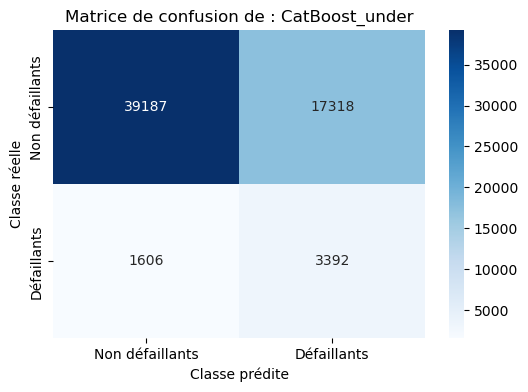

In [71]:
for x in range(len(model_under)):
    df_resultats, result_table, recall_table = outils_model.process_classification(model_under[x], X_under, X_test, y_under, 
                                                                                   y_test, df_resultats, titre_under[x], 
                                                                                   result_table, recall_table)

In [77]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('LGBM_under', 1606, 17185, 3392, 39320, df_taux)

In [78]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('CatBoost_under', 1606, 17318, 3392, 39187, df_taux)

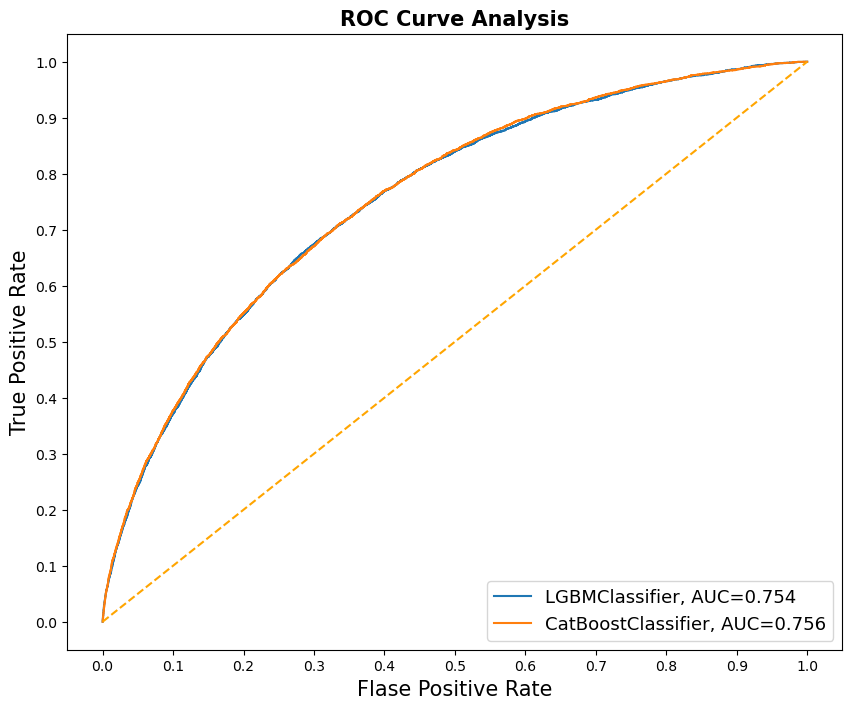

In [72]:
outils_model.roc_plot(result_table.iloc[16:,:])

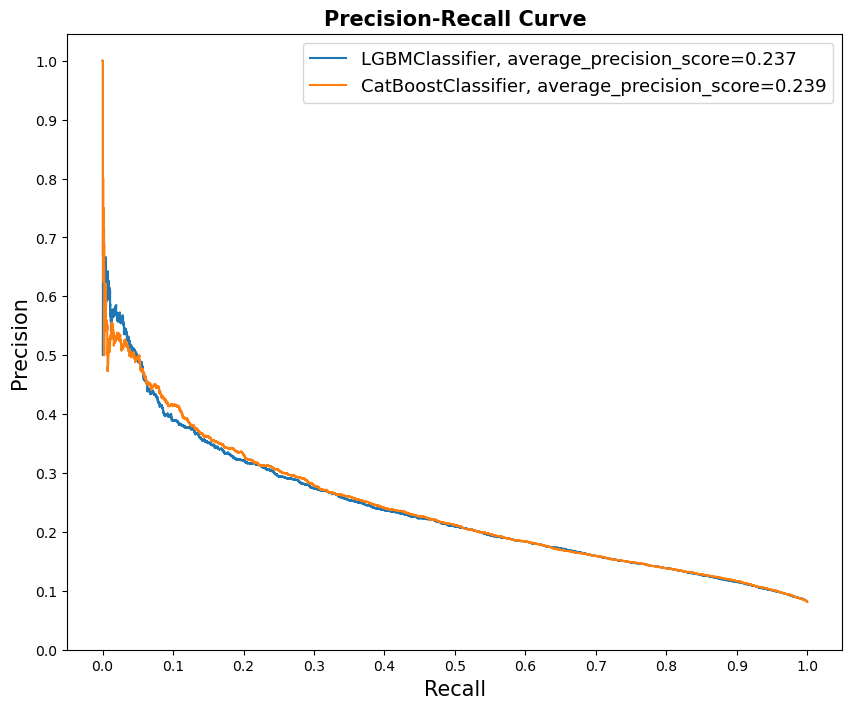

In [73]:
outils_model.avg_plot(recall_table.iloc[16:,:])

### Combining Over/Under sampling

In [59]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

print(Counter(y_train))
over = SMOTE(sampling_strategy=0.1, random_state=100)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=100)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_over_under, y_over_under = pipeline.fit_resample(X_train, y_train)
print(Counter(y_over_under))

Counter({0: 226181, 1: 19827})
Counter({0: 45236, 1: 22618})


<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
LGBM Classifer</h3></center>
</div>

In [60]:
# Value of hyperparameters for random search

#over_under_lgb = {'learning_rate':[0.2,0.1,0.01,0.05,0.001],
#              'num_leaves':range(10,100,10),
#              'min_child_samples':range(500,1000,100),
#              'reg_alpha':[0.1,0.01,0.2,0.3],
#              'reg_lambda':[0.1,0.01,0.2,0.3],
#              'n_estimators':range(50,300,50),
#              'max_bin': range(500,1500,100),
#              'class_weight' : ['balanced','is_unbalanced','scale_pos_weight']}

#RndSrch_Tune(LGBMClassifier(random_state = 100, n_jobs=-1), X_over_under, y_over_under, over_under_lgb)

best score is : 0.7755946553744565
best estimator is : LGBMClassifier(class_weight='balanced', max_bin=1000, min_child_samples=700,
               n_estimators=250, num_leaves=50, random_state=100, reg_alpha=0.2,
               reg_lambda=0.1)
best Params is : {'reg_lambda': 0.1, 'reg_alpha': 0.2, 'num_leaves': 50, 'n_estimators': 250, 'min_child_samples': 700, 'max_bin': 1000, 'learning_rate': 0.1, 'class_weight': 'balanced'}


0.7755946553744565

In [74]:
lgb_over_under = LGBMClassifier(**{'reg_lambda': 0.1, 
                                'reg_alpha': 0.2, 
                                'num_leaves': 50, 
                                'n_estimators': 250, 
                                'min_child_samples': 700, 
                                'learning_rate': 0.1,
                                'max_bin': 1000,
                                'objective': 'binary',
                                'n_jobs': -1,
                                'class_weight':'balanced',
                                'random_state':100})

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
CatBoost</h3></center>
</div>

In [61]:
# Value of hyperparameters for random search

#over_under_cat = {'depth' : [4,5,6,7,8,9,10],
#             'learning_rate':[0.2,0.1,0.01,0.05,0.001],
#             'n_estimators':range(50,300,50)}

#RndSrch_Tune(CatBoostClassifier(random_state = 100), X_over_under, y_over_under, over_under_cat)

0:	learn: 0.6695462	total: 22.3ms	remaining: 5.54s
1:	learn: 0.6494389	total: 45.5ms	remaining: 5.64s
2:	learn: 0.6338998	total: 68.2ms	remaining: 5.61s
3:	learn: 0.6195244	total: 91ms	remaining: 5.6s
4:	learn: 0.6091232	total: 115ms	remaining: 5.61s
5:	learn: 0.6003101	total: 137ms	remaining: 5.55s
6:	learn: 0.5934622	total: 158ms	remaining: 5.5s
7:	learn: 0.5876395	total: 181ms	remaining: 5.46s
8:	learn: 0.5821286	total: 203ms	remaining: 5.42s
9:	learn: 0.5778491	total: 230ms	remaining: 5.52s
10:	learn: 0.5739437	total: 257ms	remaining: 5.58s
11:	learn: 0.5705546	total: 282ms	remaining: 5.6s
12:	learn: 0.5675197	total: 304ms	remaining: 5.54s
13:	learn: 0.5650950	total: 325ms	remaining: 5.48s
14:	learn: 0.5630450	total: 346ms	remaining: 5.41s
15:	learn: 0.5607434	total: 366ms	remaining: 5.36s
16:	learn: 0.5567278	total: 388ms	remaining: 5.32s
17:	learn: 0.5537566	total: 411ms	remaining: 5.3s
18:	learn: 0.5521928	total: 432ms	remaining: 5.25s
19:	learn: 0.5511194	total: 456ms	remaining

163:	learn: 0.4986423	total: 3.5s	remaining: 1.83s
164:	learn: 0.4984535	total: 3.52s	remaining: 1.81s
165:	learn: 0.4983005	total: 3.54s	remaining: 1.79s
166:	learn: 0.4981760	total: 3.55s	remaining: 1.77s
167:	learn: 0.4980176	total: 3.57s	remaining: 1.74s
168:	learn: 0.4976782	total: 3.59s	remaining: 1.72s
169:	learn: 0.4975453	total: 3.6s	remaining: 1.7s
170:	learn: 0.4974158	total: 3.62s	remaining: 1.67s
171:	learn: 0.4971050	total: 3.64s	remaining: 1.65s
172:	learn: 0.4969764	total: 3.65s	remaining: 1.63s
173:	learn: 0.4967993	total: 3.67s	remaining: 1.6s
174:	learn: 0.4965751	total: 3.69s	remaining: 1.58s
175:	learn: 0.4963588	total: 3.7s	remaining: 1.56s
176:	learn: 0.4961751	total: 3.72s	remaining: 1.53s
177:	learn: 0.4960633	total: 3.74s	remaining: 1.51s
178:	learn: 0.4959120	total: 3.77s	remaining: 1.49s
179:	learn: 0.4957861	total: 3.79s	remaining: 1.47s
180:	learn: 0.4956164	total: 3.81s	remaining: 1.45s
181:	learn: 0.4953520	total: 3.83s	remaining: 1.43s
182:	learn: 0.495

0.7830114720728828

In [79]:
cat_over_under = CatBoostClassifier(learning_rate = 0.1,
                         n_estimators=250,
                         depth = 6,
                         random_state = 100)

In [80]:
model_over_under = [lgb_over_under, cat_over_under]
titre_over_under = ['LGBM_over_under', 'CatBoost_over_under']

Successfully registered model 'LGBM_over_under'.
2023/04/18 05:29:15 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LGBM_over_under, version 1
Created version '1' of model 'LGBM_over_under'.


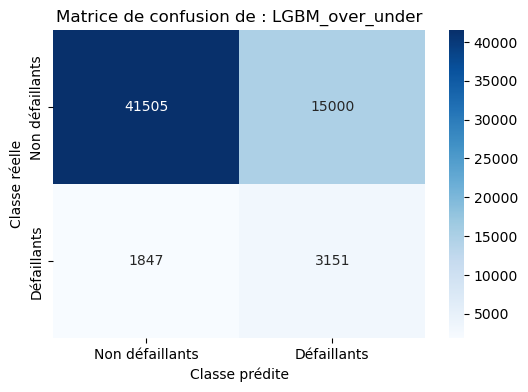

0:	learn: 0.6695462	total: 11.3ms	remaining: 2.83s
1:	learn: 0.6494389	total: 24.4ms	remaining: 3.02s
2:	learn: 0.6338998	total: 36.4ms	remaining: 3s
3:	learn: 0.6195244	total: 47.4ms	remaining: 2.91s
4:	learn: 0.6091232	total: 59.3ms	remaining: 2.91s
5:	learn: 0.6003101	total: 70.3ms	remaining: 2.86s
6:	learn: 0.5934622	total: 81.2ms	remaining: 2.82s
7:	learn: 0.5876395	total: 92.5ms	remaining: 2.8s
8:	learn: 0.5821286	total: 105ms	remaining: 2.81s
9:	learn: 0.5778491	total: 116ms	remaining: 2.79s
10:	learn: 0.5739437	total: 127ms	remaining: 2.76s
11:	learn: 0.5705546	total: 139ms	remaining: 2.76s
12:	learn: 0.5675197	total: 150ms	remaining: 2.74s
13:	learn: 0.5650950	total: 161ms	remaining: 2.72s
14:	learn: 0.5630450	total: 174ms	remaining: 2.72s
15:	learn: 0.5607434	total: 186ms	remaining: 2.72s
16:	learn: 0.5567278	total: 197ms	remaining: 2.71s
17:	learn: 0.5537566	total: 209ms	remaining: 2.69s
18:	learn: 0.5521928	total: 222ms	remaining: 2.7s
19:	learn: 0.5511194	total: 235ms	rema

177:	learn: 0.4960633	total: 2.11s	remaining: 854ms
178:	learn: 0.4959120	total: 2.13s	remaining: 843ms
179:	learn: 0.4957861	total: 2.14s	remaining: 832ms
180:	learn: 0.4956164	total: 2.15s	remaining: 821ms
181:	learn: 0.4953520	total: 2.17s	remaining: 810ms
182:	learn: 0.4952199	total: 2.18s	remaining: 798ms
183:	learn: 0.4950812	total: 2.19s	remaining: 787ms
184:	learn: 0.4949234	total: 2.21s	remaining: 775ms
185:	learn: 0.4947871	total: 2.22s	remaining: 764ms
186:	learn: 0.4946505	total: 2.23s	remaining: 753ms
187:	learn: 0.4945036	total: 2.25s	remaining: 741ms
188:	learn: 0.4943505	total: 2.26s	remaining: 730ms
189:	learn: 0.4942050	total: 2.27s	remaining: 718ms
190:	learn: 0.4940733	total: 2.29s	remaining: 707ms
191:	learn: 0.4938338	total: 2.3s	remaining: 696ms
192:	learn: 0.4936493	total: 2.32s	remaining: 685ms
193:	learn: 0.4935165	total: 2.33s	remaining: 674ms
194:	learn: 0.4932662	total: 2.35s	remaining: 664ms
195:	learn: 0.4931038	total: 2.37s	remaining: 653ms
196:	learn: 0

91:	learn: 0.5090197	total: 1.27s	remaining: 2.18s
92:	learn: 0.5088738	total: 1.29s	remaining: 2.17s
93:	learn: 0.5084371	total: 1.3s	remaining: 2.16s
94:	learn: 0.5082547	total: 1.32s	remaining: 2.15s
95:	learn: 0.5079419	total: 1.33s	remaining: 2.13s
96:	learn: 0.5073462	total: 1.34s	remaining: 2.12s
97:	learn: 0.5072045	total: 1.35s	remaining: 2.1s
98:	learn: 0.5070448	total: 1.37s	remaining: 2.09s
99:	learn: 0.5068456	total: 1.38s	remaining: 2.07s
100:	learn: 0.5066299	total: 1.39s	remaining: 2.06s
101:	learn: 0.5064083	total: 1.41s	remaining: 2.04s
102:	learn: 0.5062450	total: 1.42s	remaining: 2.02s
103:	learn: 0.5060606	total: 1.43s	remaining: 2.01s
104:	learn: 0.5058903	total: 1.44s	remaining: 1.99s
105:	learn: 0.5054069	total: 1.46s	remaining: 1.98s
106:	learn: 0.5052251	total: 1.47s	remaining: 1.96s
107:	learn: 0.5050143	total: 1.48s	remaining: 1.95s
108:	learn: 0.5048274	total: 1.5s	remaining: 1.94s
109:	learn: 0.5045933	total: 1.51s	remaining: 1.92s
110:	learn: 0.5044477	to

0:	learn: 0.6695844	total: 11ms	remaining: 2.74s
1:	learn: 0.6513038	total: 21.6ms	remaining: 2.68s
2:	learn: 0.6356712	total: 31.5ms	remaining: 2.59s
3:	learn: 0.6202818	total: 42.6ms	remaining: 2.62s
4:	learn: 0.6087793	total: 54.2ms	remaining: 2.65s
5:	learn: 0.6000377	total: 64.6ms	remaining: 2.63s
6:	learn: 0.5933807	total: 75.4ms	remaining: 2.62s
7:	learn: 0.5866956	total: 86.3ms	remaining: 2.61s
8:	learn: 0.5812672	total: 97.6ms	remaining: 2.61s
9:	learn: 0.5766525	total: 108ms	remaining: 2.59s
10:	learn: 0.5727235	total: 119ms	remaining: 2.58s
11:	learn: 0.5690770	total: 130ms	remaining: 2.58s
12:	learn: 0.5662740	total: 141ms	remaining: 2.56s
13:	learn: 0.5623926	total: 153ms	remaining: 2.57s
14:	learn: 0.5609215	total: 164ms	remaining: 2.57s
15:	learn: 0.5589152	total: 176ms	remaining: 2.57s
16:	learn: 0.5568148	total: 187ms	remaining: 2.56s
17:	learn: 0.5551704	total: 198ms	remaining: 2.55s
18:	learn: 0.5537230	total: 210ms	remaining: 2.55s
19:	learn: 0.5507619	total: 222ms	

169:	learn: 0.4922982	total: 1.86s	remaining: 874ms
170:	learn: 0.4921993	total: 1.87s	remaining: 864ms
171:	learn: 0.4920209	total: 1.88s	remaining: 854ms
172:	learn: 0.4918490	total: 1.89s	remaining: 843ms
173:	learn: 0.4916309	total: 1.9s	remaining: 832ms
174:	learn: 0.4915041	total: 1.91s	remaining: 821ms
175:	learn: 0.4913479	total: 1.93s	remaining: 810ms
176:	learn: 0.4912353	total: 1.94s	remaining: 798ms
177:	learn: 0.4910997	total: 1.95s	remaining: 787ms
178:	learn: 0.4909354	total: 1.96s	remaining: 776ms
179:	learn: 0.4906278	total: 1.97s	remaining: 764ms
180:	learn: 0.4904490	total: 1.98s	remaining: 753ms
181:	learn: 0.4902606	total: 1.99s	remaining: 742ms
182:	learn: 0.4900010	total: 2s	remaining: 731ms
183:	learn: 0.4898454	total: 2.01s	remaining: 720ms
184:	learn: 0.4897157	total: 2.02s	remaining: 709ms
185:	learn: 0.4895471	total: 2.03s	remaining: 698ms
186:	learn: 0.4893691	total: 2.04s	remaining: 687ms
187:	learn: 0.4891990	total: 2.05s	remaining: 676ms
188:	learn: 0.48

98:	learn: 0.5077903	total: 1.08s	remaining: 1.65s
99:	learn: 0.5076642	total: 1.09s	remaining: 1.64s
100:	learn: 0.5069482	total: 1.1s	remaining: 1.63s
101:	learn: 0.5067597	total: 1.11s	remaining: 1.62s
102:	learn: 0.5065866	total: 1.12s	remaining: 1.6s
103:	learn: 0.5063984	total: 1.13s	remaining: 1.59s
104:	learn: 0.5062526	total: 1.14s	remaining: 1.58s
105:	learn: 0.5060341	total: 1.15s	remaining: 1.57s
106:	learn: 0.5054284	total: 1.16s	remaining: 1.56s
107:	learn: 0.5051795	total: 1.17s	remaining: 1.54s
108:	learn: 0.5050248	total: 1.18s	remaining: 1.53s
109:	learn: 0.5048337	total: 1.2s	remaining: 1.52s
110:	learn: 0.5046432	total: 1.21s	remaining: 1.51s
111:	learn: 0.5045045	total: 1.22s	remaining: 1.5s
112:	learn: 0.5042555	total: 1.23s	remaining: 1.49s
113:	learn: 0.5040151	total: 1.24s	remaining: 1.48s
114:	learn: 0.5038298	total: 1.25s	remaining: 1.47s
115:	learn: 0.5036383	total: 1.26s	remaining: 1.45s
116:	learn: 0.5034627	total: 1.27s	remaining: 1.44s
117:	learn: 0.5033

20:	learn: 0.5532804	total: 217ms	remaining: 2.36s
21:	learn: 0.5522820	total: 229ms	remaining: 2.38s
22:	learn: 0.5513248	total: 242ms	remaining: 2.39s
23:	learn: 0.5504500	total: 252ms	remaining: 2.38s
24:	learn: 0.5495334	total: 262ms	remaining: 2.36s
25:	learn: 0.5487903	total: 273ms	remaining: 2.35s
26:	learn: 0.5478872	total: 283ms	remaining: 2.34s
27:	learn: 0.5472251	total: 294ms	remaining: 2.33s
28:	learn: 0.5463575	total: 304ms	remaining: 2.32s
29:	learn: 0.5433101	total: 315ms	remaining: 2.31s
30:	learn: 0.5419794	total: 325ms	remaining: 2.3s
31:	learn: 0.5398486	total: 336ms	remaining: 2.29s
32:	learn: 0.5392426	total: 346ms	remaining: 2.27s
33:	learn: 0.5386051	total: 356ms	remaining: 2.26s
34:	learn: 0.5364528	total: 367ms	remaining: 2.25s
35:	learn: 0.5354477	total: 377ms	remaining: 2.24s
36:	learn: 0.5348763	total: 388ms	remaining: 2.23s
37:	learn: 0.5342733	total: 399ms	remaining: 2.23s
38:	learn: 0.5334865	total: 410ms	remaining: 2.21s
39:	learn: 0.5318441	total: 420m

197:	learn: 0.4879438	total: 2.13s	remaining: 560ms
198:	learn: 0.4877947	total: 2.14s	remaining: 549ms
199:	learn: 0.4876424	total: 2.15s	remaining: 539ms
200:	learn: 0.4875051	total: 2.17s	remaining: 528ms
201:	learn: 0.4873218	total: 2.18s	remaining: 517ms
202:	learn: 0.4871624	total: 2.19s	remaining: 507ms
203:	learn: 0.4870345	total: 2.2s	remaining: 496ms
204:	learn: 0.4868393	total: 2.21s	remaining: 485ms
205:	learn: 0.4866776	total: 2.22s	remaining: 475ms
206:	learn: 0.4864959	total: 2.23s	remaining: 464ms
207:	learn: 0.4863464	total: 2.24s	remaining: 453ms
208:	learn: 0.4860926	total: 2.25s	remaining: 442ms
209:	learn: 0.4859373	total: 2.26s	remaining: 431ms
210:	learn: 0.4857816	total: 2.27s	remaining: 420ms
211:	learn: 0.4856480	total: 2.28s	remaining: 409ms
212:	learn: 0.4855333	total: 2.29s	remaining: 398ms
213:	learn: 0.4853584	total: 2.3s	remaining: 387ms
214:	learn: 0.4852514	total: 2.31s	remaining: 377ms
215:	learn: 0.4851327	total: 2.32s	remaining: 366ms
216:	learn: 0.

110:	learn: 0.5049581	total: 1.26s	remaining: 1.58s
111:	learn: 0.5046339	total: 1.27s	remaining: 1.57s
112:	learn: 0.5043785	total: 1.29s	remaining: 1.56s
113:	learn: 0.5040583	total: 1.3s	remaining: 1.55s
114:	learn: 0.5038612	total: 1.31s	remaining: 1.54s
115:	learn: 0.5037374	total: 1.32s	remaining: 1.53s
116:	learn: 0.5035933	total: 1.34s	remaining: 1.52s
117:	learn: 0.5034433	total: 1.35s	remaining: 1.51s
118:	learn: 0.5032636	total: 1.36s	remaining: 1.5s
119:	learn: 0.5027338	total: 1.37s	remaining: 1.49s
120:	learn: 0.5026125	total: 1.38s	remaining: 1.47s
121:	learn: 0.5023734	total: 1.39s	remaining: 1.46s
122:	learn: 0.5021672	total: 1.4s	remaining: 1.45s
123:	learn: 0.5020180	total: 1.42s	remaining: 1.44s
124:	learn: 0.5018766	total: 1.43s	remaining: 1.43s
125:	learn: 0.5017292	total: 1.44s	remaining: 1.42s
126:	learn: 0.5014990	total: 1.45s	remaining: 1.41s
127:	learn: 0.5012914	total: 1.46s	remaining: 1.39s
128:	learn: 0.5010097	total: 1.47s	remaining: 1.38s
129:	learn: 0.5

30:	learn: 0.5345496	total: 436ms	remaining: 3.08s
31:	learn: 0.5341100	total: 453ms	remaining: 3.08s
32:	learn: 0.5330540	total: 470ms	remaining: 3.09s
33:	learn: 0.5326234	total: 488ms	remaining: 3.1s
34:	learn: 0.5322005	total: 506ms	remaining: 3.11s
35:	learn: 0.5317995	total: 521ms	remaining: 3.1s
36:	learn: 0.5313756	total: 535ms	remaining: 3.08s
37:	learn: 0.5307394	total: 550ms	remaining: 3.07s
38:	learn: 0.5302804	total: 564ms	remaining: 3.05s
39:	learn: 0.5298038	total: 579ms	remaining: 3.04s
40:	learn: 0.5293657	total: 594ms	remaining: 3.03s
41:	learn: 0.5285394	total: 608ms	remaining: 3.01s
42:	learn: 0.5281124	total: 622ms	remaining: 2.99s
43:	learn: 0.5278168	total: 636ms	remaining: 2.98s
44:	learn: 0.5275473	total: 650ms	remaining: 2.96s
45:	learn: 0.5257682	total: 668ms	remaining: 2.96s
46:	learn: 0.5254217	total: 682ms	remaining: 2.94s
47:	learn: 0.5246314	total: 696ms	remaining: 2.93s
48:	learn: 0.5240831	total: 711ms	remaining: 2.92s
49:	learn: 0.5237756	total: 725ms

193:	learn: 0.4867001	total: 2.79s	remaining: 806ms
194:	learn: 0.4865127	total: 2.81s	remaining: 791ms
195:	learn: 0.4863506	total: 2.82s	remaining: 776ms
196:	learn: 0.4861412	total: 2.83s	remaining: 761ms
197:	learn: 0.4860480	total: 2.84s	remaining: 746ms
198:	learn: 0.4858851	total: 2.85s	remaining: 731ms
199:	learn: 0.4857385	total: 2.86s	remaining: 716ms
200:	learn: 0.4855982	total: 2.87s	remaining: 700ms
201:	learn: 0.4854532	total: 2.88s	remaining: 685ms
202:	learn: 0.4852950	total: 2.9s	remaining: 670ms
203:	learn: 0.4851901	total: 2.91s	remaining: 656ms
204:	learn: 0.4850591	total: 2.92s	remaining: 641ms
205:	learn: 0.4845712	total: 2.93s	remaining: 626ms
206:	learn: 0.4844012	total: 2.94s	remaining: 612ms
207:	learn: 0.4842654	total: 2.96s	remaining: 597ms
208:	learn: 0.4840993	total: 2.97s	remaining: 582ms
209:	learn: 0.4839154	total: 2.98s	remaining: 567ms
210:	learn: 0.4837647	total: 2.99s	remaining: 552ms
211:	learn: 0.4836126	total: 3s	remaining: 538ms
212:	learn: 0.48

116:	learn: 0.5041277	total: 1.46s	remaining: 1.66s
117:	learn: 0.5039466	total: 1.48s	remaining: 1.65s
118:	learn: 0.5037809	total: 1.49s	remaining: 1.64s
119:	learn: 0.5036194	total: 1.5s	remaining: 1.62s
120:	learn: 0.5034404	total: 1.51s	remaining: 1.61s
121:	learn: 0.5032775	total: 1.52s	remaining: 1.59s
122:	learn: 0.5029231	total: 1.53s	remaining: 1.58s
123:	learn: 0.5027693	total: 1.54s	remaining: 1.57s
124:	learn: 0.5025735	total: 1.55s	remaining: 1.55s
125:	learn: 0.5019696	total: 1.56s	remaining: 1.54s
126:	learn: 0.5014535	total: 1.58s	remaining: 1.53s
127:	learn: 0.5011181	total: 1.59s	remaining: 1.51s
128:	learn: 0.5009172	total: 1.6s	remaining: 1.5s
129:	learn: 0.5007698	total: 1.61s	remaining: 1.49s
130:	learn: 0.5006072	total: 1.62s	remaining: 1.47s
131:	learn: 0.5004069	total: 1.63s	remaining: 1.46s
132:	learn: 0.5001637	total: 1.65s	remaining: 1.45s
133:	learn: 0.5000677	total: 1.66s	remaining: 1.43s
134:	learn: 0.4998466	total: 1.67s	remaining: 1.42s
135:	learn: 0.4

36:	learn: 0.5360309	total: 431ms	remaining: 2.48s
37:	learn: 0.5345738	total: 445ms	remaining: 2.48s
38:	learn: 0.5341137	total: 463ms	remaining: 2.5s
39:	learn: 0.5326467	total: 481ms	remaining: 2.52s
40:	learn: 0.5323519	total: 495ms	remaining: 2.52s
41:	learn: 0.5319775	total: 507ms	remaining: 2.51s
42:	learn: 0.5316062	total: 518ms	remaining: 2.5s
43:	learn: 0.5312308	total: 530ms	remaining: 2.48s
44:	learn: 0.5308527	total: 542ms	remaining: 2.47s
45:	learn: 0.5305990	total: 553ms	remaining: 2.45s
46:	learn: 0.5302609	total: 565ms	remaining: 2.44s
47:	learn: 0.5299148	total: 576ms	remaining: 2.42s
48:	learn: 0.5282587	total: 588ms	remaining: 2.41s
49:	learn: 0.5279053	total: 601ms	remaining: 2.4s
50:	learn: 0.5276247	total: 613ms	remaining: 2.39s
51:	learn: 0.5271542	total: 624ms	remaining: 2.38s
52:	learn: 0.5261231	total: 636ms	remaining: 2.36s
53:	learn: 0.5257307	total: 648ms	remaining: 2.35s
54:	learn: 0.5254252	total: 662ms	remaining: 2.35s
55:	learn: 0.5240778	total: 675ms	

197:	learn: 0.4880194	total: 2.56s	remaining: 671ms
198:	learn: 0.4878150	total: 2.57s	remaining: 658ms
199:	learn: 0.4876726	total: 2.58s	remaining: 645ms
200:	learn: 0.4871150	total: 2.59s	remaining: 632ms
201:	learn: 0.4869690	total: 2.6s	remaining: 618ms
202:	learn: 0.4868483	total: 2.61s	remaining: 605ms
203:	learn: 0.4866798	total: 2.62s	remaining: 591ms
204:	learn: 0.4865061	total: 2.65s	remaining: 581ms
205:	learn: 0.4863843	total: 2.66s	remaining: 568ms
206:	learn: 0.4862496	total: 2.67s	remaining: 555ms
207:	learn: 0.4860658	total: 2.68s	remaining: 542ms
208:	learn: 0.4859146	total: 2.7s	remaining: 529ms
209:	learn: 0.4857815	total: 2.71s	remaining: 516ms
210:	learn: 0.4856316	total: 2.72s	remaining: 503ms
211:	learn: 0.4854419	total: 2.73s	remaining: 490ms
212:	learn: 0.4852547	total: 2.74s	remaining: 477ms
213:	learn: 0.4850933	total: 2.75s	remaining: 463ms
214:	learn: 0.4849846	total: 2.76s	remaining: 450ms
215:	learn: 0.4848512	total: 2.77s	remaining: 437ms
216:	learn: 0.

117:	learn: 0.5121164	total: 1.48s	remaining: 1.66s
118:	learn: 0.5112502	total: 1.5s	remaining: 1.65s
119:	learn: 0.5109227	total: 1.51s	remaining: 1.64s
120:	learn: 0.5106993	total: 1.52s	remaining: 1.63s
121:	learn: 0.5105354	total: 1.54s	remaining: 1.61s
122:	learn: 0.5102892	total: 1.55s	remaining: 1.6s
123:	learn: 0.5101159	total: 1.56s	remaining: 1.59s
124:	learn: 0.5098322	total: 1.57s	remaining: 1.57s
125:	learn: 0.5096298	total: 1.59s	remaining: 1.56s
126:	learn: 0.5094570	total: 1.6s	remaining: 1.55s
127:	learn: 0.5090291	total: 1.61s	remaining: 1.54s
128:	learn: 0.5088718	total: 1.63s	remaining: 1.52s
129:	learn: 0.5086276	total: 1.64s	remaining: 1.51s
130:	learn: 0.5083987	total: 1.65s	remaining: 1.5s
131:	learn: 0.5082267	total: 1.66s	remaining: 1.49s
132:	learn: 0.5080117	total: 1.68s	remaining: 1.47s
133:	learn: 0.5078586	total: 1.69s	remaining: 1.46s
134:	learn: 0.5075809	total: 1.7s	remaining: 1.45s
135:	learn: 0.5073920	total: 1.72s	remaining: 1.44s
136:	learn: 0.507

36:	learn: 0.5490142	total: 429ms	remaining: 2.47s
37:	learn: 0.5483794	total: 444ms	remaining: 2.48s
38:	learn: 0.5477211	total: 459ms	remaining: 2.48s
39:	learn: 0.5474150	total: 475ms	remaining: 2.49s
40:	learn: 0.5471509	total: 488ms	remaining: 2.49s
41:	learn: 0.5467930	total: 502ms	remaining: 2.49s
42:	learn: 0.5462360	total: 516ms	remaining: 2.48s
43:	learn: 0.5459301	total: 529ms	remaining: 2.48s
44:	learn: 0.5456228	total: 542ms	remaining: 2.47s
45:	learn: 0.5453232	total: 555ms	remaining: 2.46s
46:	learn: 0.5449809	total: 569ms	remaining: 2.46s
47:	learn: 0.5446362	total: 582ms	remaining: 2.45s
48:	learn: 0.5443232	total: 595ms	remaining: 2.44s
49:	learn: 0.5441300	total: 610ms	remaining: 2.44s
50:	learn: 0.5437281	total: 627ms	remaining: 2.45s
51:	learn: 0.5433597	total: 642ms	remaining: 2.44s
52:	learn: 0.5431432	total: 658ms	remaining: 2.45s
53:	learn: 0.5428931	total: 673ms	remaining: 2.44s
54:	learn: 0.5424596	total: 689ms	remaining: 2.44s
55:	learn: 0.5422001	total: 703

201:	learn: 0.5146455	total: 2.96s	remaining: 703ms
202:	learn: 0.5144836	total: 2.98s	remaining: 689ms
203:	learn: 0.5143481	total: 2.99s	remaining: 675ms
204:	learn: 0.5141465	total: 3.01s	remaining: 661ms
205:	learn: 0.5140107	total: 3.03s	remaining: 646ms
206:	learn: 0.5138426	total: 3.04s	remaining: 632ms
207:	learn: 0.5137428	total: 3.06s	remaining: 618ms
208:	learn: 0.5135928	total: 3.08s	remaining: 603ms
209:	learn: 0.5134515	total: 3.09s	remaining: 589ms
210:	learn: 0.5132997	total: 3.11s	remaining: 575ms
211:	learn: 0.5131157	total: 3.13s	remaining: 560ms
212:	learn: 0.5130013	total: 3.14s	remaining: 546ms
213:	learn: 0.5128654	total: 3.16s	remaining: 532ms
214:	learn: 0.5127164	total: 3.18s	remaining: 517ms
215:	learn: 0.5125508	total: 3.2s	remaining: 503ms
216:	learn: 0.5124099	total: 3.21s	remaining: 489ms
217:	learn: 0.5122534	total: 3.23s	remaining: 474ms
218:	learn: 0.5120744	total: 3.25s	remaining: 459ms
219:	learn: 0.5119405	total: 3.26s	remaining: 445ms
220:	learn: 0

Successfully registered model 'CatBoost_over_under'.
2023/04/18 05:29:55 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CatBoost_over_under, version 1
Created version '1' of model 'CatBoost_over_under'.


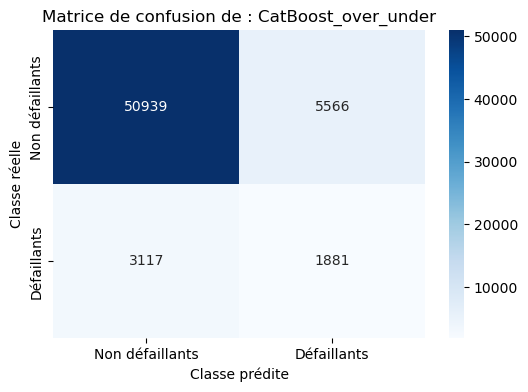

In [81]:
for x in range(len(model_over_under)):
    df_resultats, result_table, recall_table = outils_model.process_classification(model_over_under[x], X_over_under, X_test, y_over_under, 
                                                                                   y_test, df_resultats, titre_over_under[x], 
                                                                                   result_table, recall_table)

In [88]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('LGBM_over_under', 1847, 15000, 3151, 41505, df_taux)

In [89]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('CatBoost_over_under', 3117, 5566, 1881, 50939, df_taux)

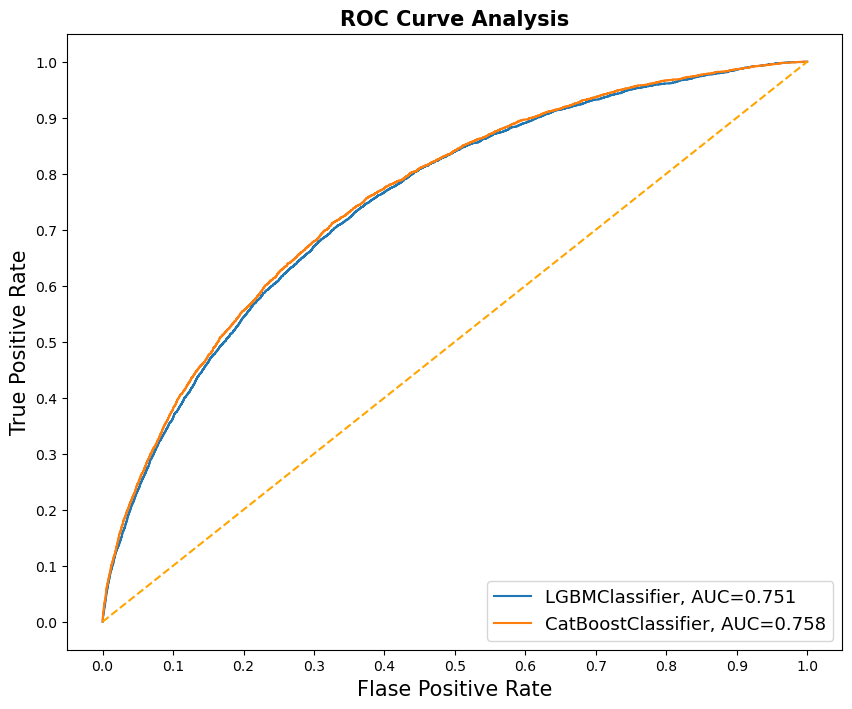

In [82]:
outils_model.roc_plot(result_table.iloc[18:,:])

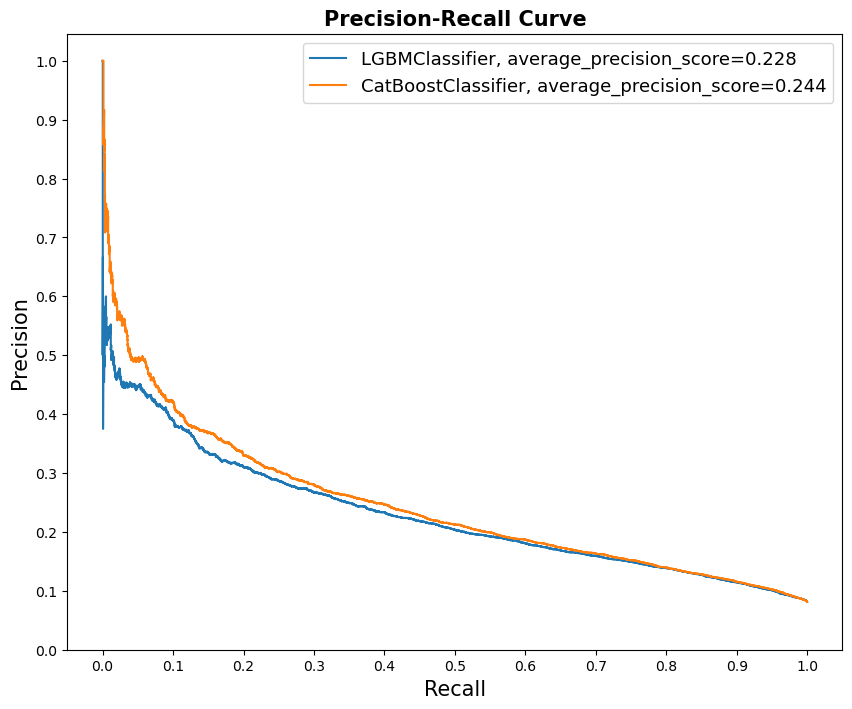

In [83]:
outils_model.avg_plot(recall_table.iloc[18:,:])

##### On va maintenant comparer les différents resultats en fonction du ROC AUC, du temps d'execution et des bonnes/mauvaises prédictions

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Resultats</h3></center>
</div>

In [84]:
df_resultats

Modèle   Rappel  Précision       F1       F5      F10  \
0                     Dummy  0.00000    0.00000  0.00000  0.00000  0.00000   
1                      LGBM  0.01441    0.54545  0.02807  0.01497  0.01455   
2                      XGBC  0.03321    0.49405  0.06224  0.03445  0.03352   
3                  AdaBoost  0.01561    0.52703  0.03031  0.01621  0.01576   
4         LogisticRegressor  0.00000    0.00000  0.00000  0.00000  0.00000   
5              RandomForest  0.00280    0.58333  0.00558  0.00291  0.00283   
6                  CatBoost  0.03161    0.53020  0.05967  0.03280  0.03191   
7               Dummy_param  0.08984    0.08950  0.08967  0.08982  0.08983   
8                LGBM_param  0.62885    0.17963  0.27944  0.57367  0.61366   
9                XGBC_param  0.61425    0.17756  0.27548  0.56116  0.59964   
10           AdaBoost_param  0.00680    0.53125  0.01343  0.00707  0.00687   
11  LogisticRegressor_param  0.66046    0.14984  0.24427  0.58393  0.63891   
12       RandomForest_param  0.65046    0.16038  0.25731  0.58205  0.63136   
13           CatBoost_param  0.02421    0.56808  0.04644  0.02514  0.02444   
14                LGBM_over  0.38275    0.24948  0.30207  0.37505  0.38074   
15            CatBoost_over  0.02261    0.52558  0.04335  0.02347  0.02283   
16               LGBM_under  0.67867    0.16484  0.26526  0.60602  0.65835   
17           CatBoost_under  0.67867    0.16379  0.26389  0.60546  0.65819   
18          LGBM_over_under  0.63045    0.17360  0.27224  0.57250  0.61444   
19      CatBoost_over_under  0.37635    0.25258  0.30229  0.36939  0.37453   

    ROC_AUC   PR_AUC  Metier_score  Metier_score_2  Durée_train  Durée_tot  \
0   0.50000  0.08126       0.77230           49980      0.30673    0.30874   
1   0.75497  0.24003       0.77476           49320      1.90837    2.07559   
2   0.75325  0.23530       0.77753           48490     24.46893   24.54596   
3   0.74355  0.22748       0.77489           49270     26.28581   27.22925   
4   0.59102  0.10817       0.77230           49980      1.89154    1.92218   
5   0.71553  0.20652       0.77280           49850     66.27504   68.16528   
6   0.75598  0.24349       0.77758           48540     31.58298   31.64622   
7   0.50450  0.08200       0.73032           50058      0.14014    0.14014   
8   0.75730  0.24124       0.71930           32904      3.45401    3.77381   
9   0.75142  0.23583       0.71781           33500     55.76904   55.85771   
10  0.74715  0.23146       0.77343           49670     82.06969   84.60860   
11  0.72334  0.20010       0.66670           35699     12.13558   12.15119   
12  0.73382  0.20617       0.68778           34490      8.81640    9.01172   
13  0.75686  0.24336       0.77655           48862      9.35036    9.38169   
14  0.75430  0.23765       0.78079           36605      8.45473    8.96858   
15  0.75064  0.23657       0.77605           48952      6.09476    6.12611   
16  0.75421  0.23729       0.69195           33245      0.71422    1.03193   
17  0.75595  0.23897       0.69013           33378      3.93775    3.98426   
18  0.75149  0.22849       0.71084           33470      1.54499    1.81380   
19  0.75781  0.24403       0.78192           36736      3.34713    3.36466   

    Train_roc_auc_CV  Train_roc_auc_CV +/-  Test_roc_auc_CV  \
0            0.50000               0.00000          0.50000   
1            0.79881               0.00084          0.75562   
2            0.85260               0.00134          0.75229   
3            0.74612               0.00063          0.74207   
4            0.59274               0.00730          0.59416   
5            1.00000               0.00000          0.72008   
6            0.83754               0.00029          0.75760   
7            0.50178               0.00053          0.50007   
8            0.86492               0.00055          0.75699   
9            0.86705               0.00109          0.75310   
10           0.74913               0.00065        

In [85]:
df_resultats.sort_values(by=['ROC_AUC'], ascending=False).head(10)

Modèle   Rappel  Précision       F1       F5      F10  \
19  CatBoost_over_under  0.37635    0.25258  0.30229  0.36939  0.37453   
8            LGBM_param  0.62885    0.17963  0.27944  0.57367  0.61366   
13       CatBoost_param  0.02421    0.56808  0.04644  0.02514  0.02444   
6              CatBoost  0.03161    0.53020  0.05967  0.03280  0.03191   
17       CatBoost_under  0.67867    0.16379  0.26389  0.60546  0.65819   
1                  LGBM  0.01441    0.54545  0.02807  0.01497  0.01455   
14            LGBM_over  0.38275    0.24948  0.30207  0.37505  0.38074   
16           LGBM_under  0.67867    0.16484  0.26526  0.60602  0.65835   
2                  XGBC  0.03321    0.49405  0.06224  0.03445  0.03352   
18      LGBM_over_under  0.63045    0.17360  0.27224  0.57250  0.61444   

    ROC_AUC   PR_AUC  Metier_score  Metier_score_2  Durée_train  Durée_tot  \
19  0.75781  0.24403       0.78192           36736      3.34713    3.36466   
8   0.75730  0.24124       0.71930           32904      3.45401    3.77381   
13  0.75686  0.24336       0.77655           48862      9.35036    9.38169   
6   0.75598  0.24349       0.77758           48540     31.58298   31.64622   
17  0.75595  0.23897       0.69013           33378      3.93775    3.98426   
1   0.75497  0.24003       0.77476           49320      1.90837    2.07559   
14  0.75430  0.23765       0.78079           36605      8.45473    8.96858   
16  0.75421  0.23729       0.69195           33245      0.71422    1.03193   
2   0.75325  0.23530       0.77753           48490     24.46893   24.54596   
18  0.75149  0.22849       0.71084           33470      1.54499    1.81380   

    Train_roc_auc_CV  Train_roc_auc_CV +/-  Test_roc_auc_CV  \
19           0.81447               0.00657          0.77997   
8            0.86492               0.00055          0.75699   
13           0.78529               0.00043          0.75722   
6            0.83754               0.00029          0.75760   
17           0.81127               0.00104          0.75556   
1            0.79881               0.00084          0.75562   
14           0.93351               0.01055          0.89145   
16           0.77640               0.00086          0.75595   
2            0.85260               0.00134          0.75229   
18           0.87221               0.00292          0.76552   

    Test_roc_auc_CV +/-  Train_recall_CV  Train_recall_CV +/-  Test_recall_CV  \
19              0.05487          0.47752              0.00775         0.43301   
8               0.00550          0.80570              0.00113         0.63076   
13              0.00619          0.03673              0.00131         0.02053   
6               0.00507          0.08920              0.00136         0.02698   
17              0.00796          0.72658              0.00199         0.68412   
1               0.00535          0.02021              0.00140         0.01437   
14              0.11416          0.78182              0.00941         0.70376   
16              0.00791          0.69707              0.00216         0.68255   
2               0.00555          0.06890              0.00224         0.03006   
18              0.03042          0.78493              0.00237         0.65753   

    Test_recall_CV +/-  Train_precision_CV  Train_precision_CV +/-  \
19             0.14420             0.73770                 0.01412   
8              0.01045             0.22783                 0.00071   
13             0.00265             0.77408                 0.01016   
6              0.00329             0.93983                 0.00509   
17             0.01121             0.73457                 0.00100   
1              0.00369             0.71808                 0.01670   
14             0.31455             0.63360                 0.04960   
16             0.00899             0.70783                 0.00083   
2              0.00253             0.84118                 0.01374   
18             0.06557             0.65148               

In [86]:
df_resultats.sort_values(by=['Test_roc_auc_CV'], ascending=False).head(10)

Modèle   Rappel  Précision       F1       F5      F10  \
14            LGBM_over  0.38275    0.24948  0.30207  0.37505  0.38074   
15        CatBoost_over  0.02261    0.52558  0.04335  0.02347  0.02283   
19  CatBoost_over_under  0.37635    0.25258  0.30229  0.36939  0.37453   
18      LGBM_over_under  0.63045    0.17360  0.27224  0.57250  0.61444   
6              CatBoost  0.03161    0.53020  0.05967  0.03280  0.03191   
13       CatBoost_param  0.02421    0.56808  0.04644  0.02514  0.02444   
8            LGBM_param  0.62885    0.17963  0.27944  0.57367  0.61366   
16           LGBM_under  0.67867    0.16484  0.26526  0.60602  0.65835   
1                  LGBM  0.01441    0.54545  0.02807  0.01497  0.01455   
17       CatBoost_under  0.67867    0.16379  0.26389  0.60546  0.65819   

    ROC_AUC   PR_AUC  Metier_score  Metier_score_2  Durée_train  Durée_tot  \
14  0.75430  0.23765       0.78079           36605      8.45473    8.96858   
15  0.75064  0.23657       0.77605           48952      6.09476    6.12611   
19  0.75781  0.24403       0.78192           36736      3.34713    3.36466   
18  0.75149  0.22849       0.71084           33470      1.54499    1.81380   
6   0.75598  0.24349       0.77758           48540     31.58298   31.64622   
13  0.75686  0.24336       0.77655           48862      9.35036    9.38169   
8   0.75730  0.24124       0.71930           32904      3.45401    3.77381   
16  0.75421  0.23729       0.69195           33245      0.71422    1.03193   
1   0.75497  0.24003       0.77476           49320      1.90837    2.07559   
17  0.75595  0.23897       0.69013           33378      3.93775    3.98426   

    Train_roc_auc_CV  Train_roc_auc_CV +/-  Test_roc_auc_CV  \
14           0.93351               0.01055          0.89145   
15           0.89524               0.01223          0.88834   
19           0.81447               0.00657          0.77997   
18           0.87221               0.00292          0.76552   
6            0.83754               0.00029          0.75760   
13           0.78529               0.00043          0.75722   
8            0.86492               0.00055          0.75699   
16           0.77640               0.00086          0.75595   
1            0.79881               0.00084          0.75562   
17           0.81127               0.00104          0.75556   

    Test_roc_auc_CV +/-  Train_recall_CV  Train_recall_CV +/-  Test_recall_CV  \
14              0.11416          0.78182              0.00941         0.70376   
15              0.11723          0.55619              0.04748         0.54911   
19              0.05487          0.47752              0.00775         0.43301   
18              0.03042          0.78493              0.00237         0.65753   
6               0.00507          0.08920              0.00136         0.02698   
13              0.00619          0.03673              0.00131         0.02053   
8               0.00550          0.80570              0.00113         0.63076   
16              0.00791          0.69707              0.00216         0.68255   
1               0.00535          0.02021              0.00140         0.01437   
17              0.00796          0.72658              0.00199         0.68412   

    Test_recall_CV +/-  Train_precision_CV  Train_precision_CV +/-  \
14             0.31455             0.63360                 0.04960   
15             0.45027             0.98726                 0.00616   
19             0.14420             0.73770                 0.01412   
18             0.06557             0.65148                 0.00557   
6              0.00329             0.93983                 0.00509   
13             0.00265             0.77408                 0.01016   
8              0.01045             0.22783                 0.00071   
16             0.00899             0.70783                 0.00083   
1              0.00369             0.71808                 0.01670   
17             0.01121             0.73457               

In [90]:
df_taux.sort_values(by=['FN'])

Modèle    FN     FP    TP     TN
17           CatBoost_under  1606  17318  3392  39187
16               LGBM_under  1606  17185  3392  39320
11  LogisticRegressor_param  1697  18729  3301  37776
12       RandomForest_param  1747  17020  3251  39485
18          LGBM_over_under  1847  15000  3151  41505
8                LGBM_param  1855  14354  3143  42151
9                XGBC_param  1928  14220  3070  42285
14                LGBM_over  3085   5755  1913  50750
19      CatBoost_over_under  3117   5566  1881  50939
7               Dummy_param  4549   4568   449  51937
2                      XGBC  4832    170   166  56335
6                  CatBoost  4840    140   158  56365
13           CatBoost_param  4877     92   121  56413
15            CatBoost_over  4885    102   113  56403
3                  AdaBoost  4920     70    78  56435
1                      LGBM  4926     60    72  56445
10           AdaBoost_param  4964     30    34  56475
5              RandomForest  4984     10    14  56495
4         LogisticRegressor  4998      0     0  56505
0                     Dummy  4998      0     0  56505

In [91]:
df_taux.sort_values(by=['TN'], ascending=False)

Modèle    FN     FP    TP     TN
0                     Dummy  4998      0     0  56505
4         LogisticRegressor  4998      0     0  56505
5              RandomForest  4984     10    14  56495
10           AdaBoost_param  4964     30    34  56475
1                      LGBM  4926     60    72  56445
3                  AdaBoost  4920     70    78  56435
13           CatBoost_param  4877     92   121  56413
15            CatBoost_over  4885    102   113  56403
6                  CatBoost  4840    140   158  56365
2                      XGBC  4832    170   166  56335
7               Dummy_param  4549   4568   449  51937
19      CatBoost_over_under  3117   5566  1881  50939
14                LGBM_over  3085   5755  1913  50750
9                XGBC_param  1928  14220  3070  42285
8                LGBM_param  1855  14354  3143  42151
18          LGBM_over_under  1847  15000  3151  41505
12       RandomForest_param  1747  17020  3251  39485
16               LGBM_under  1606  17185  3392  39320
17           CatBoost_under  1606  17318  3392  39187
11  LogisticRegressor_param  1697  18729  3301  37776

##### On voit bien que les modèles LGBM et CatBoost sont ceux avec le score ROC AUC les plus élevés. 

#### Le score ROC AUC nous permettant d'avoir un score sur le potentiel de classification des modèles. Plus il est proche de 1 et plus le modèle à de bonne prédictions. On remarque que les modèle ayant les meilleurs résultats sont LGBM et CatBoost. Soit avec le dataset initial avec optimisation des paramètres, ou avec les datasets over_under.
#### Le paramètre de temps va jouer pour la partie APi/dashbord. On va alors se concenter sur les modèle LGBM et CatBoost

In [92]:
df_res_taux = df_resultats.merge(df_taux, on='Modèle', how='left')

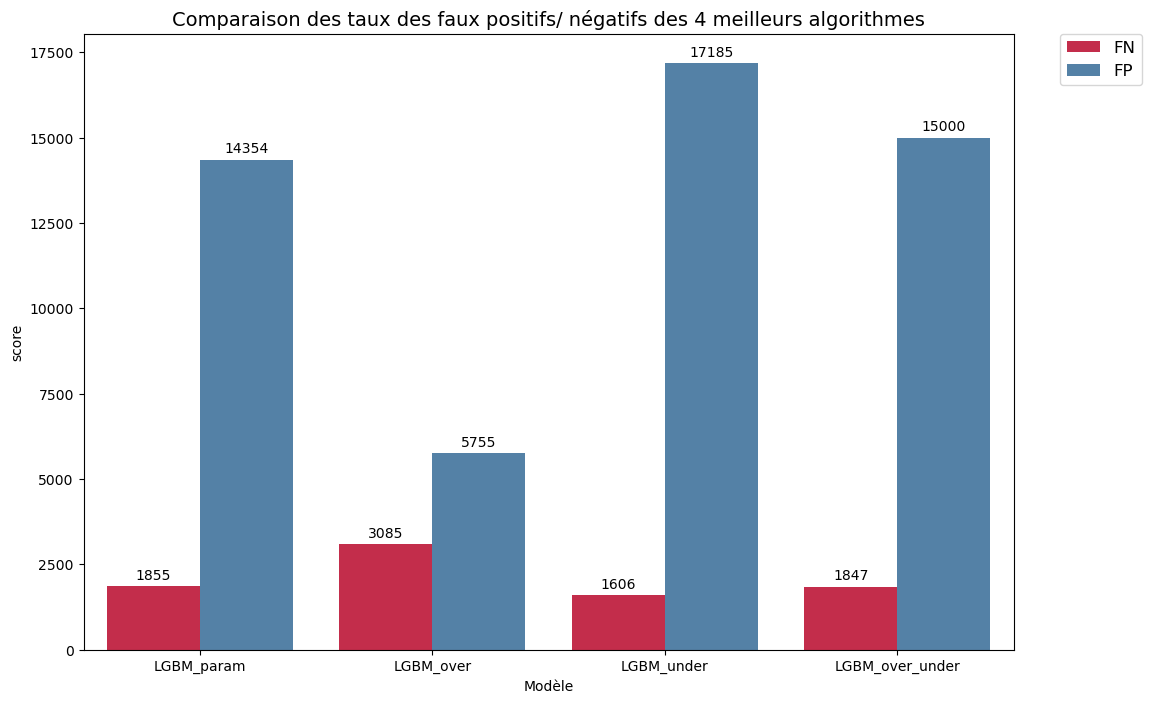

In [95]:
# Comparaison visuelle des 4 algorithmes les plus performants
df_comp_best = df_res_taux[df_res_taux['Modèle'].isin(
    ['LGBM_param', 'LGBM_over',
     'LGBM_under', 'LGBM_over_under'])]

# Renseignements sur les modèles
df_comp_display = df_comp_best[['Modèle', 'ROC_AUC', 'F10', 'Train_roc_auc_CV','Test_roc_auc_CV']].style.hide_index()
display(df_comp_display)

# Faux négatifs/Faux positifs
comparaison_taux_melt_false = \
    pd.melt(df_comp_best, id_vars=['Modèle'], value_name='score',
            value_vars=['FN', 'FP'])
# Visualisation
plt.figure(figsize=(12, 8))
ax= sns.barplot(x=comparaison_taux_melt_false['Modèle'],
                y=comparaison_taux_melt_false['score'],
            hue=comparaison_taux_melt_false['variable'],
            palette=['Crimson', 'SteelBlue', 'Crimson', 'SteelBlue'])
plt.title('Comparaison des taux des faux positifs/ négatifs des 4 meilleurs algorithmes', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 200,
            int(height),
            ha="center") 
plt.show()

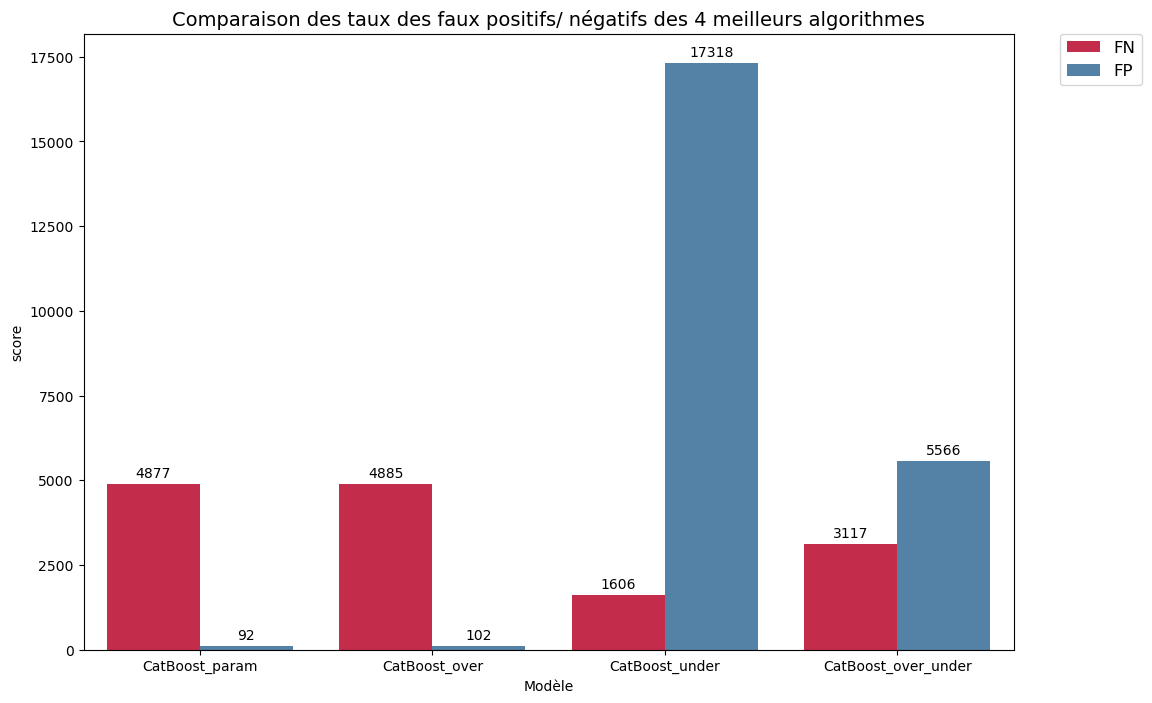

In [96]:
# Comparaison visuelle des 4 algorithmes les plus performants
df_comp_best = df_res_taux[df_res_taux['Modèle'].isin(
    ['CatBoost_param', 'CatBoost_over',
     'CatBoost_under', 'CatBoost_over_under'])]

# Renseignements sur les modèles
df_comp_display = df_comp_best[['Modèle', 'ROC_AUC', 'F10', 'Train_roc_auc_CV', 'Test_roc_auc_CV']].style.hide_index()
display(df_comp_display)

# Faux négatifs/Faux positifs
comparaison_taux_melt_false = \
    pd.melt(df_comp_best, id_vars=['Modèle'], value_name='score',
            value_vars=['FN', 'FP'])
# Visualisation
plt.figure(figsize=(12, 8))
ax= sns.barplot(x=comparaison_taux_melt_false['Modèle'],
                y=comparaison_taux_melt_false['score'],
            hue=comparaison_taux_melt_false['variable'],
            palette=['Crimson', 'SteelBlue', 'Crimson', 'SteelBlue'])
plt.title('Comparaison des taux des faux positifs/ négatifs des 4 meilleurs algorithmes', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 200,
            int(height),
            ha="center") 
plt.show()

#### Risque d'overfitting lors de l'utilisation de l'oversampling

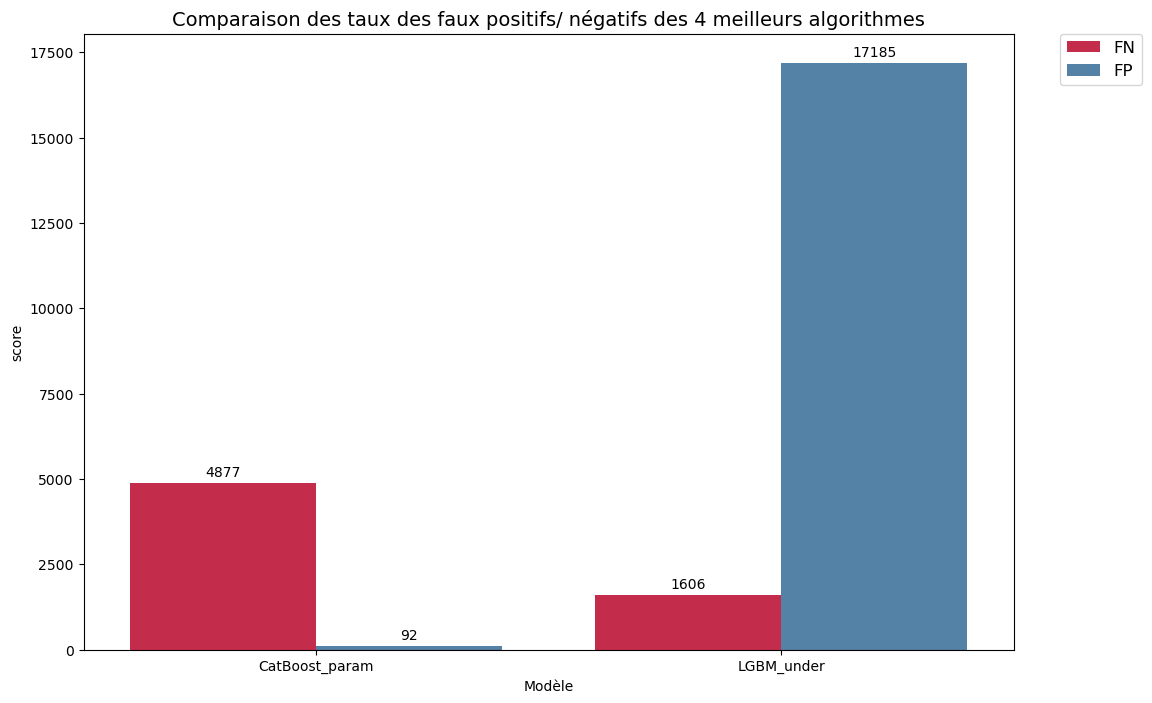

In [97]:
# Comparaison visuelle des 4 algorithmes les plus performants
df_comp_best = df_res_taux[df_res_taux['Modèle'].isin(
    ['CatBoost_param', 'LGBM_under'])]

# Renseignements sur les modèles
df_comp_display = df_comp_best[['Modèle', 'ROC_AUC', 'F10', 'Train_roc_auc_CV', 'Test_roc_auc_CV']].style.hide_index()
display(df_comp_display)

# Faux négatifs/Faux positifs
comparaison_taux_melt_false = \
    pd.melt(df_comp_best, id_vars=['Modèle'], value_name='score',
            value_vars=['FN', 'FP'])
# Visualisation
plt.figure(figsize=(12, 8))
ax= sns.barplot(x=comparaison_taux_melt_false['Modèle'],
                y=comparaison_taux_melt_false['score'],
            hue=comparaison_taux_melt_false['variable'],
            palette=['Crimson', 'SteelBlue', 'Crimson', 'SteelBlue'])
plt.title('Comparaison des taux des faux positifs/ négatifs des 4 meilleurs algorithmes', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 200,
            int(height),
            ha="center") 
plt.show()

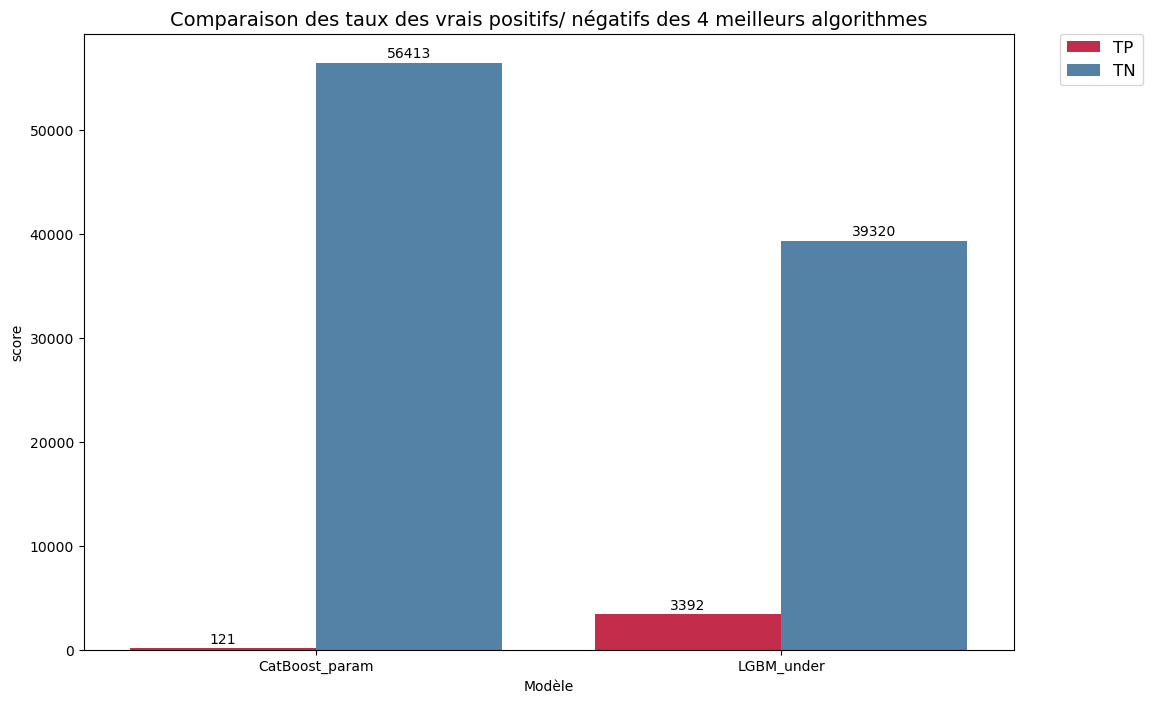

In [98]:
# Vrais négatifs/Vrais positifs
comparaison_taux_melt_true = \
    pd.melt(df_comp_best, id_vars=['Modèle'], value_name='score',
            value_vars=['TP', 'TN'])
# Visualisation
plt.figure(figsize=(12, 8))
total = float(len(comparaison_taux_melt_true))
ax = sns.barplot(x=comparaison_taux_melt_true['Modèle'],
                 y=comparaison_taux_melt_true['score'],
                 hue=comparaison_taux_melt_true['variable'],
                 palette=['Crimson', 'SteelBlue', 'Crimson', 'SteelBlue'])
plt.title('Comparaison des taux des vrais positifs/ négatifs des 4 meilleurs algorithmes', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 500,
            int(height),
            ha="center") 
plt.show()

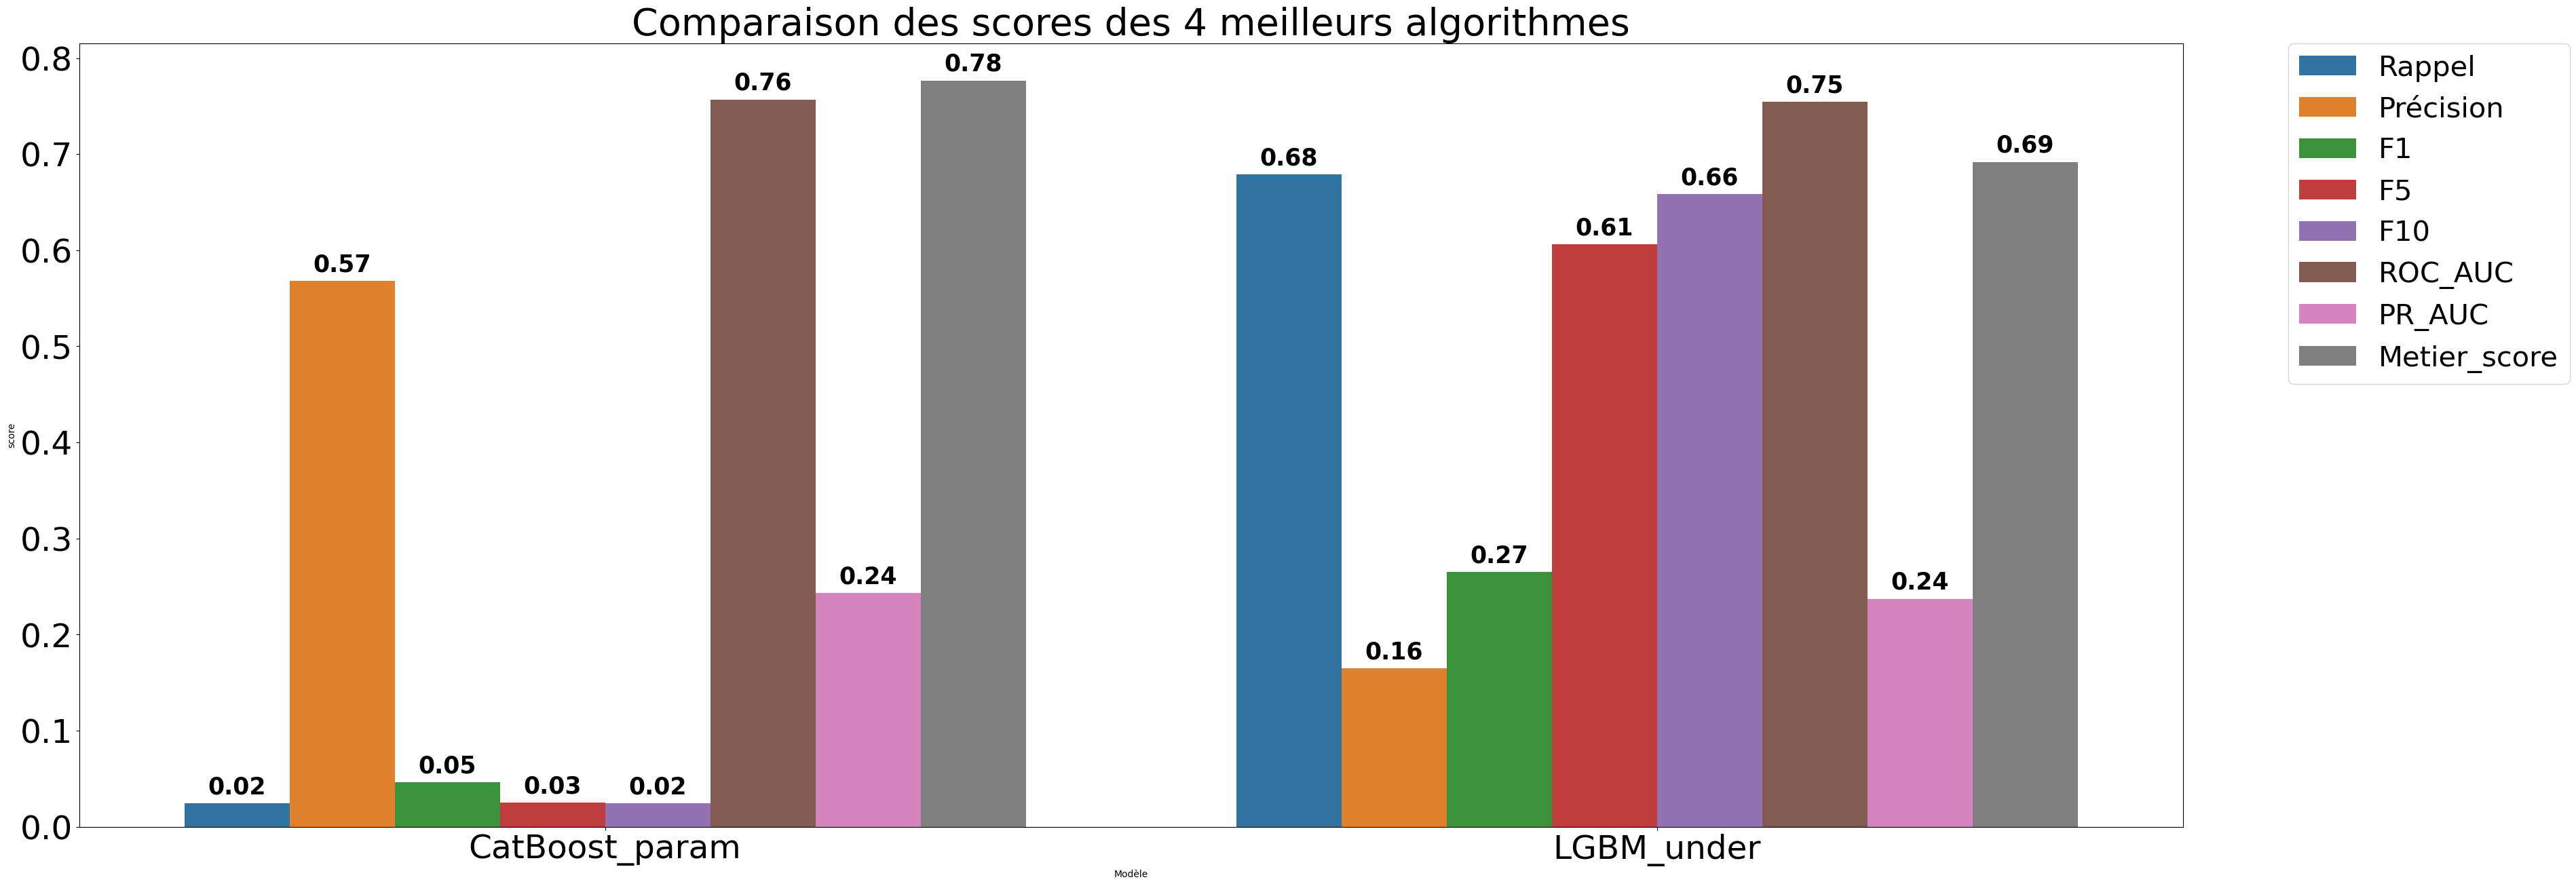

In [99]:
# Comparaison visuelle des 4 algorithmes les plus performants
df_comp_score = df_res_taux[df_res_taux['Modèle'].isin(
    ['CatBoost_param', 'LGBM_under'])]

# Renseignements sur les modèles

display(df_comp_display)

# Scores
comparaison_score_melt = \
    pd.melt(df_comp_score, id_vars=['Modèle'], value_name='score',
            value_vars=['Rappel', 'Précision', 'F1', 'F5', 'F10',
                        'ROC_AUC', 'PR_AUC', 'Metier_score'])
# Visualisation
plt.figure(figsize=(40, 15))
ax= sns.barplot(x=comparaison_score_melt['Modèle'],
                y=comparaison_score_melt['score'],
            hue=comparaison_score_melt['variable'])
plt.title('Comparaison des scores des 4 meilleurs algorithmes',
          fontsize=40)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=30)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center",
            fontsize=25,
            fontweight='bold') 
plt.show()

df_comp_score[['Rappel', 'Précision', 'F1', 'F5', 'F10', 'ROC_AUC',
               'PR_AUC', 'Metier_score']].style.hide_index()

#### Nous allons partir sur LGBM under

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Recherche du seuil optimal</h3></center>
</div>

In [105]:
df_res_seuil = pd.DataFrame({})

### LGBM_under : recherche du seuil pour les meilleurs prédictions

##### score métier 1

Score métrique métier maximal : 0.7894120595002164
Seuil maximal : 0.77
-----------------------------------------------------------




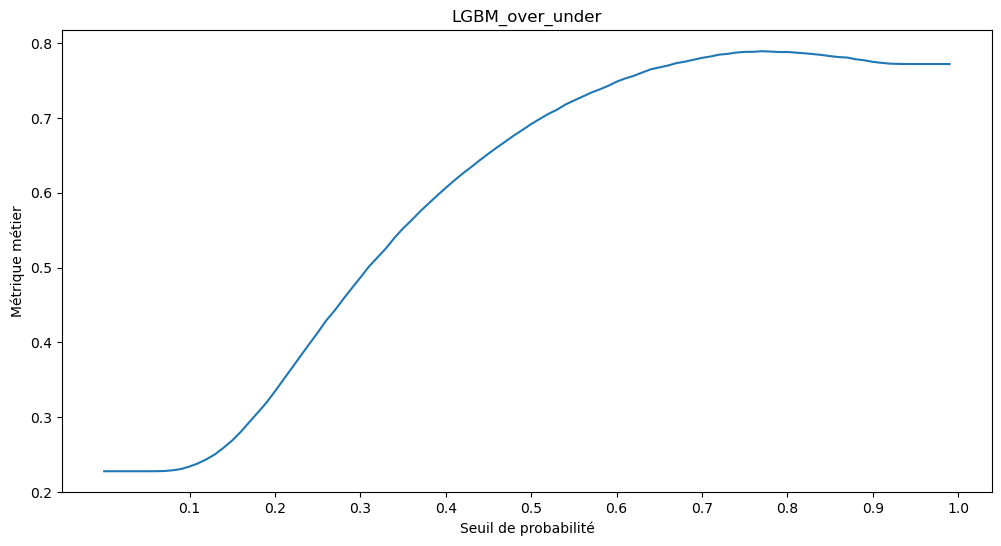

In [101]:
# taux_tn=1, taux_fp=0, taux_fn=-10, taux_tp=0
outils_model.determiner_seuil_probabilite(lgb_under,
                                          X_test, y_test,
                                          'LGBM_under')

Registered model 'LGBM_under_seuil' already exists. Creating a new version of this model...
2023/04/18 05:59:49 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LGBM_under_seuil, version 2
Created version '2' of model 'LGBM_under_seuil'.


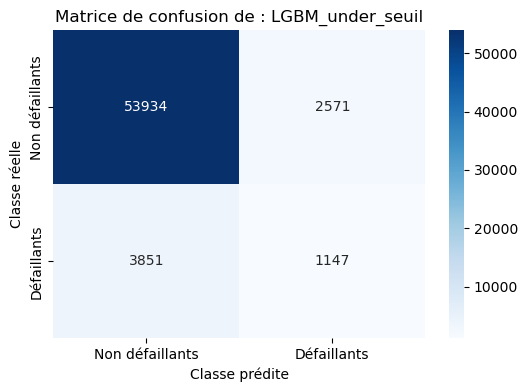

In [106]:
df_res_seuil = outils_model.process_classification_seuil(lgb_under, 0.77,
                                             X_under, X_test, y_under,
                                             y_test, df_res_seuil,
                                            'LGBM_under_seuil')

In [107]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('LGBM_under_seuil', 3851, 2571, 1147, 53934, df_taux)

#### f10 score

LGBM_under
Score F10 maximal : 0.9004449597174585
Seuil maximal : 0.14
-----------------------------------------------------------




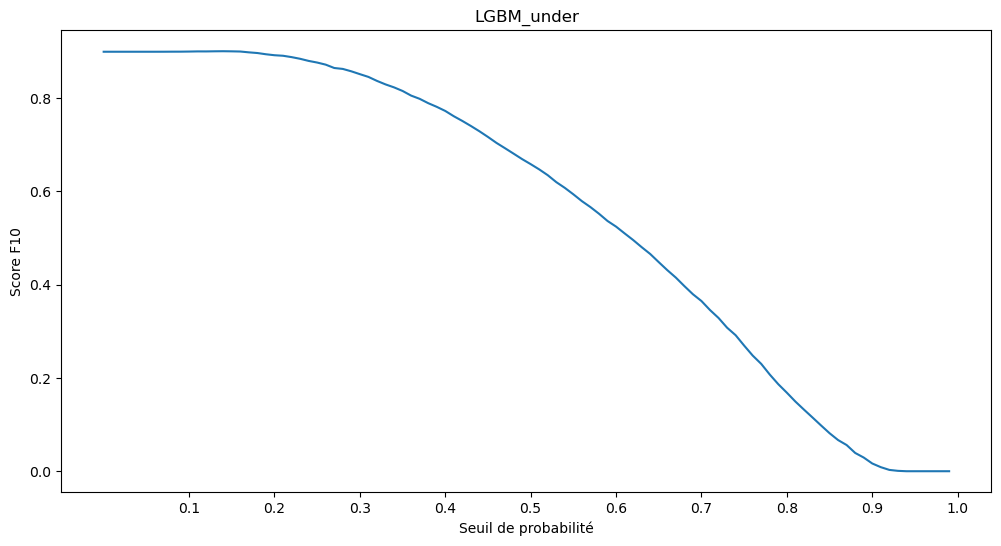

In [103]:
# Score F10 en fonction du seuil
outils_model.determiner_seuil_probabilite_F10(lgb_under,
                                              X_test, y_test,
                                             'LGBM_under')

Successfully registered model 'LGBM_under_seuil_f10'.
2023/04/18 06:01:49 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LGBM_under_seuil_f10, version 1
Created version '1' of model 'LGBM_under_seuil_f10'.


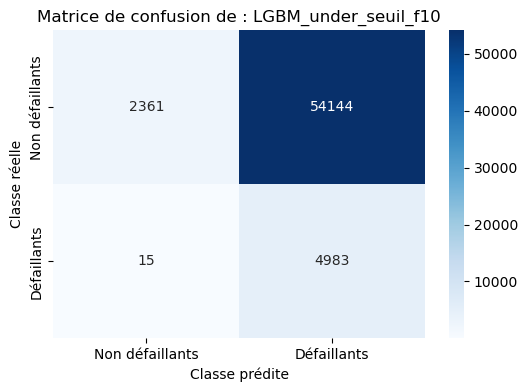

In [108]:
df_res_seuil = outils_model.process_classification_seuil(lgb_under, 0.14,
                                             X_under, X_test, y_under,
                                             y_test, df_res_seuil,
                                            'LGBM_under_seuil_f10')

In [110]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('LGBM_under_seuil_f10', 15, 54144, 4983, 2361, df_taux)

#### score métier 2

Score métier_2 minimal : 33132
Seuil minimal : 0.52
-----------------------------------------------------------




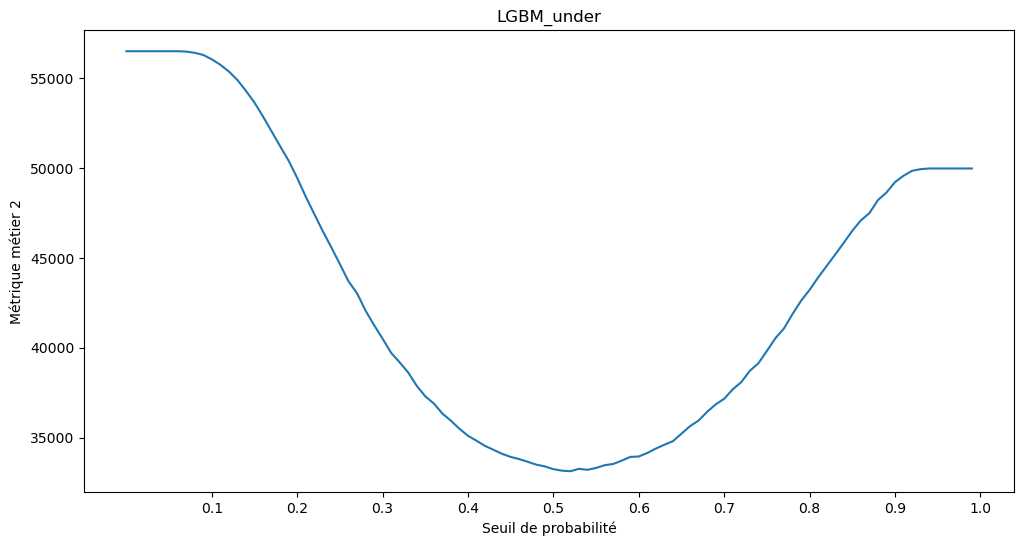

In [109]:
# 10*fn +fp
outils_model.determiner_seuil_probabilite_2(lgb_under,
                                          X_test, y_test,
                                          'LGBM_under')

Successfully registered model 'LGBM_under_seuil_2'.
2023/04/18 06:03:08 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LGBM_under_seuil_2, version 1
Created version '1' of model 'LGBM_under_seuil_2'.


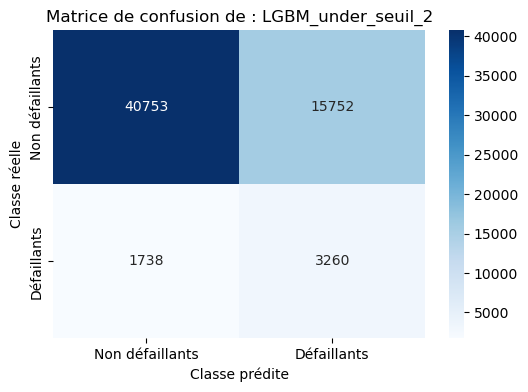

In [111]:
df_res_seuil = outils_model.process_classification_seuil(lgb_under, 0.52,
                                             X_under, X_test, y_under,
                                             y_test, df_res_seuil,
                                            'LGBM_under_seuil_2')

In [112]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('LGBM_under_seuil_2', 1738, 15752, 3260, 40753, df_taux)

#### Resultats

In [113]:
df_res_seuil

Modèle   Rappel  Précision       F1       F5      F10  \
0      LGBM_under_seuil  0.22949    0.30850  0.26319  0.23177  0.23008   
1  LGBM_under_seuil_f10  0.99700    0.08428  0.15542  0.70383  0.90044   
2    LGBM_under_seuil_2  0.65226    0.17147  0.27155  0.58877  0.63464   

   ROC_AUC   PR_AUC  Metier_score  Metier_score_2  Durée_train  Durée_tot  \
0  0.75421  0.23729       0.78941           41081      0.54890    0.73103   
1  0.75421  0.23729       0.25929           54294      0.57615    0.76121   
2  0.75421  0.23729       0.70552           33132      0.74279    0.92944   

   Train_roc_auc_CV  Train_roc_auc_CV +/-  Test_roc_auc_CV  \
0            0.7764               0.00086          0.75595   
1            0.7764               0.00086          0.75595   
2            0.7764               0.00086          0.75595   

   Test_roc_auc_CV +/-  Train_recall_CV  Train_recall_CV +/-  Test_recall_CV  \
0              0.00791          0.69707              0.00216         0.68255   
1              0.00791          0.69707              0.00216         0.68255   
2              0.00791          0.69707              0.00216         0.68255   

   Test_recall_CV +/-  Train_precision_CV  Train_precision_CV +/-  \
0             0.00899             0.70783                 0.00083   
1             0.00899             0.70783                 0.00083   
2             0.00899             0.70783                 0.00083   

   Test_precision_CV  Test_precision_CV +/-  
0            0.69344                0.00811  
1            0.69344                0.00811  
2            0.69344                0.00811

In [114]:
df_taux.iloc[20:,]

Modèle    FN     FP    TP     TN
20      LGBM_under_seuil  3851   2571  1147  53934
21  LGBM_under_seuil_f10    15  54144  4983   2361
22    LGBM_under_seuil_2  1738  15752  3260  40753

#### On peut remarquer que les prédictions sont plus équilibré avec la métrique métier 2. En terme du nombre de prédictions et du temps d'execution, on va choisir le modèle LGBM entrainé sur des donnée under sampling